<a href="https://colab.research.google.com/github/BigRedEye/co-project/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Методы для ускорения невыпуклой оптимизации
## Выполнили: студенты группы 175 Родионов Антон и Скорцов Сергей

В данной работе были реализованы следующие методы оптимизации:
1. SGD
2. Polyak Momentum
3. Nesterov Momentum
4. New Nesterov Momentum

А так же некоторые их аналоги с адаптивным выбором шага:
1. Adam
2. Nadam

Для проверки работы использовались следующие сети:
1. LogisticRegression
2. Two-layer Fully-connected network
3. Simple Convolutional network
4. SqueezeNet v1.1

Все модели обучались на датасете CIFAR10 на протяжении 5 эпох.
В результате работы производится сравнение этих методов при различных значениях batch_size, momentum и learning rate.

Более полные результаты будут выложены чуть позже


### Logistic regression


In [1]:
import torch
from torchsummary import summary

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.flatten(x)
        outputs = self.linear(x)
        return outputs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = LogisticRegression(32 * 32 * 3, 10).to(device)
print(summary(net, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 10]          30,730
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.15
----------------------------------------------------------------
None


### Two-layer FC network

In [2]:
import torch
from torchsummary import summary

class FullyConnected(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnected, self).__init__()
        self.l1 = torch.nn.Linear(input_dim, hidden_dim)
        self.l2 = torch.nn.Linear(hidden_dim, output_dim)
        self.flatten = torch.nn.Flatten()
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.sigmoid(x)
        x = self.l2(x)
        x = self.sigmoid(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = FullyConnected(32 * 32 * 3, 128, 10).to(device)
print(summary(net, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 128]         393,344
           Sigmoid-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
           Sigmoid-5                   [-1, 10]               0
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 1.51
Estimated Total Size (MB): 1.54
----------------------------------------------------------------
None


### Small ConvNet

In [3]:
import torch
import torch.nn
from torchsummary import summary

class ConvNet(torch.nn.Module):
    def __init__(self, in_ch, output_dim):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_ch, 32, kernel_size=5, stride=1, padding=2)
        self.relu = torch.nn.LeakyReLU()
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv4 = torch.nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.drop_out = torch.nn.Dropout()
        self.gap = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.conv5 = torch.nn.Conv2d(128, output_dim, kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.drop_out(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.gap(x)
        return torch.flatten(x, 1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ConvNet(3, 10).to(device)
print(summary(net, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
         LeakyReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]          25,632
         LeakyReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          51,264
         LeakyReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]         204,928
        LeakyReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
          Dropout-13            [-1, 128, 2, 2]               0
           Conv2d-14             [-1, 1

### SqueezeNet(Implemented in Pytorch)

In [4]:
from torchvision.models import squeezenet1_1 as SqueezeNet
from torchsummary import summary

net = SqueezeNet().to(device)
print(summary(net, (3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]           1,792
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4             [-1, 16, 7, 7]           1,040
              ReLU-5             [-1, 16, 7, 7]               0
            Conv2d-6             [-1, 64, 7, 7]           1,088
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]           9,280
              ReLU-9             [-1, 64, 7, 7]               0
             Fire-10            [-1, 128, 7, 7]               0
           Conv2d-11             [-1, 16, 7, 7]           2,064
             ReLU-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 64, 7, 7]           1,088
             ReLU-14             [-1, 6

### SGD + Momentum + Nesterov momentum

In [5]:
import torch

class SGDOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0, nesterov=0, eps=1e-6, **kwargs):
        if lr <= 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum parameter: {} - should be >= 0.0".format(momentum))
        defaults = dict(lr=lr, momentum=momentum, nesterov=nesterov, eps=eps)
        super(SGDOptimizer, self).__init__(params, defaults)
    
    def step1(self, criterion, inputs, labels ,closure = None):
        return self.step()
    
    @torch.no_grad()
    def step(self, closure=None):
        loss = None

        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                #grad = p.grad.data
                #if grad.is_sparse:
                #    raise RuntimeError("Optimizer does not support sparse gradients, please consider SparseOptimizer instead")
                momentum = group["momentum"]
                nesterov = group["nesterov"]
                lr = group["lr"]

                state = self.state[p]
                buffer = p.grad
                if momentum != 0:
                    if len(state) == 0:
                        state["momentum_buffer"] = torch.clone(p.grad).detach()
                    buffer = state["momentum_buffer"]
                    if nesterov:
                        #https://arxiv.org/pdf/1212.0901v2.pdf or https://cs231n.github.io/neural-networks-3/#sgd
                        buffer_prev = buffer.clone().detach()

                        buffer.mul_(momentum).add_(p.grad, alpha=lr)
                        p.add_(buffer_prev, alpha=-momentum).sub_(buffer, alpha=1+momentum)
                    else:
                        buffer.mul_(momentum).add_(p.grad, alpha=lr)
                        p.add_(buffer, alpha=-1)
                else:
                    p.add_(buffer, alpha=-lr)
        return loss

### New Nesterov Momentum

In [6]:
import torch
import copy

class NewNesterovOptimizer(torch.optim.Optimizer):
    def __init__(self, params, net, lr=1e-3, eps=1e-6, **kwargs):
        if lr <= 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        defaults = dict(lr=lr, eps=eps, net=net)
        super(NewNesterovOptimizer, self).__init__(params, defaults)

    def step1(self, criterion, inputs, labels, closure = None):
        for group in self.param_groups:
            group["criterion"] = criterion
            group["inputs"] = inputs
            group["labels"] = labels
        return self.step()
    
    def step(self, closure=None):
        loss = None

        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            tau = torch.zeros(100);
            net = group["net"]
            net_params = net.parameters()

            criterion = group["criterion"]
            inputs = group["inputs"]
            labels = group["labels"]
            with torch.no_grad():
                for np, p in zip(net.parameters(), group["params"]):
                    np.data = copy.deepcopy(p.data)
            
            for np in net.parameters():
                if np.grad is None:
                    continue
                np.grad.zero_()

            # calculate grad at point y_k
            outputs = net(inputs)
            psi = criterion(outputs, labels)
            
            psi.backward()
            with torch.no_grad():
                for np, p in zip(net.parameters(), group["params"]):
                    if p.grad is None:
                        continue
                        #grad = p.grad.data
                        #if grad.is_sparse:
                        #    raise RuntimeError("Optimizer does not support sparse gradients, please consider SparseOptimizer instead")
                    lr = group["lr"]

                    state = self.state[p]
                    if len(state) == 0:
                        state["x_buf"] = torch.clone(p).detach()
                        state["x_buf_p"] = torch.clone(p).detach()
                        state["y_buf"] = torch.clone(np).detach()
                        np.sub_(np.grad, alpha=lr) # y_1 = T(x_0)
                        # state["y_buf"] = torch.clone(p).detach() - it is the p.
                    
                    state["x_buf_p"] = torch.clone(p).detach()
                    p.sub_(np.grad, alpha=lr) ## - x_k = T(y_k)
                    state["y_buf"] = np.clone()
                    np = p.clone()
                    # psi(1) = f(x_k)

            origin_psi = criterion(net(inputs), labels) ## psi(1)
            best_t = None
            t = t_start = 1
            while t > group["eps"]:
                with torch.no_grad():
                    for np, p in zip(net.parameters(), group["params"]):
                        state = self.state[p]
                        if p.grad is None:
                            np = p.clone()
                            continue
                        lr = group["lr"]
                        np = state["x_buf_p"] + p.sub(state["x_buf_p"]).mul(t)
                t_psi = criterion(net(inputs), labels)
                if (t_psi < origin_psi):
                    best_t = t
                t /= 2
            
            if best_t == None:
                best_t = 1
                #print("Tau is 1")
            with torch.no_grad():
                for np, p in zip(net.parameters(), group["params"]):
                    if p.grad is None:
                        continue
                    state = self.state[p]
                    np = state["x_buf_p"] + best_t * (p - state["x_buf_p"])

                    
        return loss

### Adam + NAdam

In [7]:
import torch
import math

class NadamOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, mu_nu=(0.9, 0.999), eps=1e-8, schedule_decay=0.004, **kwargs):
        mu, nu = mu_nu
        defaults = dict(lr=lr, mu=mu, nu=nu, eps=eps, schedule_decay=schedule_decay)
        super(NadamOptimizer, self).__init__(params, defaults)

    def step1(self, criterion, inputs, labels, closure=None):
        return self.step(closure)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
              loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                    
                grad = p.grad.data
                state = self.state[p]
                
                # State initialization
                # http://cs229.stanford.edu/proj2015/054_report.pdf
                if len(state) == 0:
                    state['t'] = 0
                    state['m'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['n'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['mu_prod'] = 1.0

                m, n = state['m'], state['n']
                mu, nu = group['mu'], group['nu']
                eps = group['eps']
                schedule_decay = group['schedule_decay']

                state['t'] += 1
                t = state['t']
                mu_t = mu * (1 - 0.5 * pow(0.96, schedule_decay * t)) 
                mu_t_next = mu * (1 - 0.5 * pow(0.96, schedule_decay * (t + 1)))
                state['mu_prod'] *= mu_t
                mu_prod = state['mu_prod']
                mu_prod_next = mu_prod * mu_t_next
    
                corr_mu = 1 - mu ** t
                corr_nu = 1 - nu ** t
            
                g_hat = torch.div(grad, 1. - mu_prod)

                # m_t <- \mu m_{t - 1} + (1 - \mu) grad
                m.mul_(mu).add_(grad, alpha=1 - mu)
                # n_t <- \nu n_{t - 1} + (1 - \nu) grad^2
                n.mul_(nu).addcmul_(grad, grad, value=1 - nu)
                
                m_hat = torch.div(m, 1 - mu_prod_next)
                m_bar = g_hat.mul_(1 - mu_t).add_(m_hat.mul_(mu_t_next))
                
                denom = (n.sqrt() / math.sqrt(corr_nu)).add_(eps)
                p.addcdiv_(m_bar, denom, value=-group['lr'])

                return loss

            
class AdamOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, mu_nu=(0.9, 0.999), eps=1e-8, **kwargs):
        mu, nu = mu_nu
        defaults = dict(lr=lr, mu=mu, nu=nu, eps=eps)
        super(AdamOptimizer, self).__init__(params, defaults)
    
    def step1(self, criterion, inputs, labels, closure=None):
        return self.step(closure)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                state = self.state[p]

                # State initialization
                # http://cs229.stanford.edu/proj2015/054_report.pdf
                if len(state) == 0:
                    state['t'] = 0
                    state['m'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['n'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                m, n = state['m'], state['n']
                mu, nu = group['mu'], group['nu']
                eps = group['eps']

                state['t'] += 1
                corr_mu = 1 - mu ** state['t']
                corr_nu = 1 - nu ** state['t']

                # m_t <- \mu m_{t - 1} + (1 - \mu) grad
                m.mul_(mu).add_(grad, alpha=1 - mu)
                # n_t <- \nu n_{t - 1} + (1 - \nu) grad^2
                n.mul_(nu).addcmul_(grad, grad, value=1 - nu)
                
                # \theta_t <- \theta_{t - 1} - \eta \frac{\hat{m}_t}{\sqrt{\hat{n}_t} + \eps}
                # denom = \sqrt{\hat{n}_t} + \eps
                #       = \sqrt{\frac{n_t}{1 - \nu^t}} + \eps
                # nom   = \hat{m}_t
                #       = \frac{m_t}{1 - \mu^t}
                denom = (n.sqrt() / math.sqrt(corr_nu)).add_(eps)
                p.addcdiv_(m, denom, value=-group['lr'] / corr_mu)

        return loss

### Adaptive Non-convex Stochastic Gradient Descent
Реализация алгоритма №5 из статьи https://arxiv.org/pdf/1911.08380.pdf.

In [8]:
# Algorithm 5 from https://arxiv.org/pdf/1911.08380.pdf

class AdaptiveNonConvexSGD(torch.optim.Optimizer):
    def __init__(self, params, net, eps=1e-3, l_0=10.0, **kwargs):
        defaults = dict(eps=eps, net=net, L=l_0)
        super(AdaptiveNonConvexSGD, self).__init__(params, defaults)
    
    def step1(self, criterion, inputs, labels, closure=None):
        for group in self.param_groups:
            group["criterion"] = criterion
            group["inputs"] = inputs
            group["labels"] = labels
        return self.step(closure)
    
    def _f(self, group, x):
        net = group["net"]
        criterion = group["criterion"]
        inputs = group["inputs"]
        labels = group["labels"]
        for np, p in zip(net.parameters(), x):
            np.data = copy.deepcopy(p.data)
        outputs = net(inputs)
        return criterion(outputs, labels)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            f_x = self._f(group, group['params'])
            x_next = copy.deepcopy(group['params'])
            
            group['L'] /= 4
            while True:
                group['L'] *= 2
                
                grads = []
                deltas = []
                for p, p_next in zip(group['params'], x_next):
                    if p.grad is None:
                        continue
                    delta = p.grad.div(-2 * group['L'])
                    p_next.data = p.add(delta)
                    grads.append(p.grad.flatten())
                    deltas.append(delta.flatten())
                
                x_delta = torch.cat(deltas)
                x_grad = torch.cat(grads)

                f_x_next = self._f(group, x_next)
                grad_dot_delta = torch.dot(x_grad, x_delta)
                norm_sq = x_delta.norm().square()
                
                lhs = f_x_next
                rhs = f_x + grad_dot_delta + group['L'] * norm_sq + group['eps'] ** 2 / (32 * group['L'])
                if lhs <= rhs:
                    break
            
            for p, p_next in zip(group['params'], x_next):
                if p.grad is None:
                    continue
                p.data = p_next.data

        return loss

### Demon

In [9]:
import torch
import numpy as np
#https://arxiv.org/pdf/1910.04952.pdf
class DemonOptimizer(torch.optim.Optimizer):
    def __init__(self, params, total_steps=1000, lr=0.001, momentum=0.9, nesterov=0, eps=1e-6, **kwargs):
        defaults = dict(lr=lr, eps=eps, total_steps=total_steps, momentum=momentum, nesterov=nesterov)
        self.step_counter = 0
        super(DemonOptimizer, self).__init__(params, defaults)

    def step1(self, criterion, inputs, labels, closure=None):
        return self.step(closure)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            lr = group["lr"]
            eps = group["eps"]
            start_momentum = group["momentum"]
            total_steps = group["total_steps"]
            nesterov = group["nesterov"]

            for p in group["params"]:
                state = self.state[p]
                buffer = p.grad
                if start_momentum != 0:
                    if len(state) == 0:
                        state["momentum_buffer"] = torch.clone(p.grad).detach()
                    buffer = state["momentum_buffer"]
                    momentum = start_momentum * (1.0 - (self.step_counter * 1.0) / total_steps) / ((1 - start_momentum) + start_momentum * (1.0 - (self.step_counter * 1.0) / total_steps))
                    if nesterov:
                        #https://arxiv.org/pdf/1212.0901v2.pdf or https://cs231n.github.io/neural-networks-3/#sgd
                        buffer_prev = buffer.clone().detach()

                        buffer.mul_(momentum).add_(p.grad, alpha=lr)
                        p.add_(buffer_prev, alpha=-momentum).sub_(buffer, alpha=1+momentum)
                    else:
                        buffer.mul_(momentum).add_(p.grad, alpha=lr)
                        p.add_(buffer, alpha=-1)
                else:
                    p.add_(buffer, alpha=-lr)

        self.step_counter += 1
        return loss

## Experiments


In [10]:
import torch
import numpy as np

def validate(model, dataset, dataset_options, device, criterion, batch_number = -1):
    testloader = torch.utils.data.DataLoader(dataset, **dataset_options)

    outputs = np.empty(0)
    labels = np.empty(0)
    losses = 0
    count = 0
    i = 0
    for inputs, label in testloader:
        inputs = inputs.to(device)
        label = label.to(device)
        output = model(inputs)
        loss = criterion(output, label)
        label = label.to("cpu").numpy()
        output = torch.max(output, 1)[1]
        output = output.to("cpu").detach().numpy()
        outputs = np.concatenate((outputs, output))
        labels = np.concatenate((labels, label))
        losses += loss * len(label)
        count += len(label)
        i += 1
        if i == batch_number:
            break
    loss = losses / count
    accuracy = accuracy_score(labels, outputs)
    f1 = f1_score(labels, outputs, average='macro')
    loss = loss.to("cpu").detach().numpy()
    return accuracy, f1, loss

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

def run_expirement(Model, Loss_fn, Optimizer, options):
    model_options = options.get("model_options", {})
    experiment_options = options.get("experiment_options")
    device = options.get("device_option", torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
    optimizer_options = options.get("optimizer_options", {})
    batch = optimizer_options.get('batch_size')

    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                        shuffle=True, num_workers=2, pin_memory=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                        shuffle=False, num_workers=2, pin_memory=True)

    optimizer_options['net'] = Model(**model_options).to(device)
    model = Model(**model_options).to(device)
    criterion = Loss_fn().to(device)
    optimizer = Optimizer(model.parameters(), **optimizer_options)

    steps = []
    accuracys = []
    f1_scores = []
    losses = []
    first_epoch_steps = []

    step = 0
    for epoch in tqdm(range(experiment_options["epochs"]), desc="Epochs", unit="epochs"):
        running_loss = 0.0
        first_epoch_steps.append(step)
        pbar = tqdm(trainloader, desc="Steps", unit="steps", position=0, leave=True)
        for i, (inputs, labels) in enumerate(pbar):
            step += 1

            # get the inputs
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward(retain_graph=True)

            #optimizer.step()
            optimizer.step1(criterion, inputs.clone(), labels)

            # save some statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                a, b, c = validate(model, testset, {"batch_size":batch, "shuffle":False, "num_workers":2, "pin_memory":True}, device, criterion, 2)
                pbar.set_description('Epoch %i/%i, accuracy: %f, f1: %f, loss: %f' % (epoch + 1, experiment_options["epochs"], a, b, c))
                accuracys.append(a)
                f1_scores.append(b)
                losses.append(c)
                steps.append(step)
                running_loss = 0.0
        a, b, c = validate(model, testset, {"batch_size":batch, "shuffle":False, "num_workers":2, "pin_memory":True}, device, criterion, 2)
        pbar.set_description('Epoch %i/%i, accuracy: %f, f1: %f, loss: %f' % (epoch + 1, experiment_options["epochs"], a, b, c))
        accuracys.append(a)
        f1_scores.append(b)
        losses.append(c)
        steps.append(step)
        running_loss = 0.0

    ## TEST ##
    validate(model, testset, {"batch_size":batch, "shuffle":False, "num_workers":2, "pin_memory":True}, device, criterion)
    return steps, first_epoch_steps, accuracys, f1_scores, losses



In [24]:
import matplotlib.pyplot as plt

ALL_METRICS = ('accuracy', 'f1_score', 'loss')

def show_graphs(all_metrics_by_model):
  plt.figure(figsize=(24, 8 * len(all_metrics_by_model.keys())))
  i = 0
  for model_name, all_metrics in all_metrics_by_model.items():
    for metric_name in ALL_METRICS:
      i += 1
      plt.subplot(len(all_metrics_by_model.keys()), 3, i)
      last_config = ''
      for config_name, metric in all_metrics[metric_name].items():
        plt.plot(all_metrics['steps'][config_name], metric, label=config_name)
        last_config = config_name
      bottom, top = plt.gca().get_ylim()
      epoch_label_pos = bottom + (top - bottom) * 0.9
      first_epoch_steps = all_metrics['first_epoch_steps'][last_config][1:]
      for e, step in enumerate(first_epoch_steps):
        plt.axvline(x=step, color='k', linestyle='--')
        plt.text(step + 30, epoch_label_pos, f'Epoch {e + 2}/{len(first_epoch_steps)}', rotation=90, verticalalignment='center')
      plt.title(model_name + ': ' + metric_name + ' / steps')
      plt.xlabel('Number of iterations')
      plt.ylabel(metric_name)
      plt.legend(loc=4)
      plt.grid(True)
  plt.show()

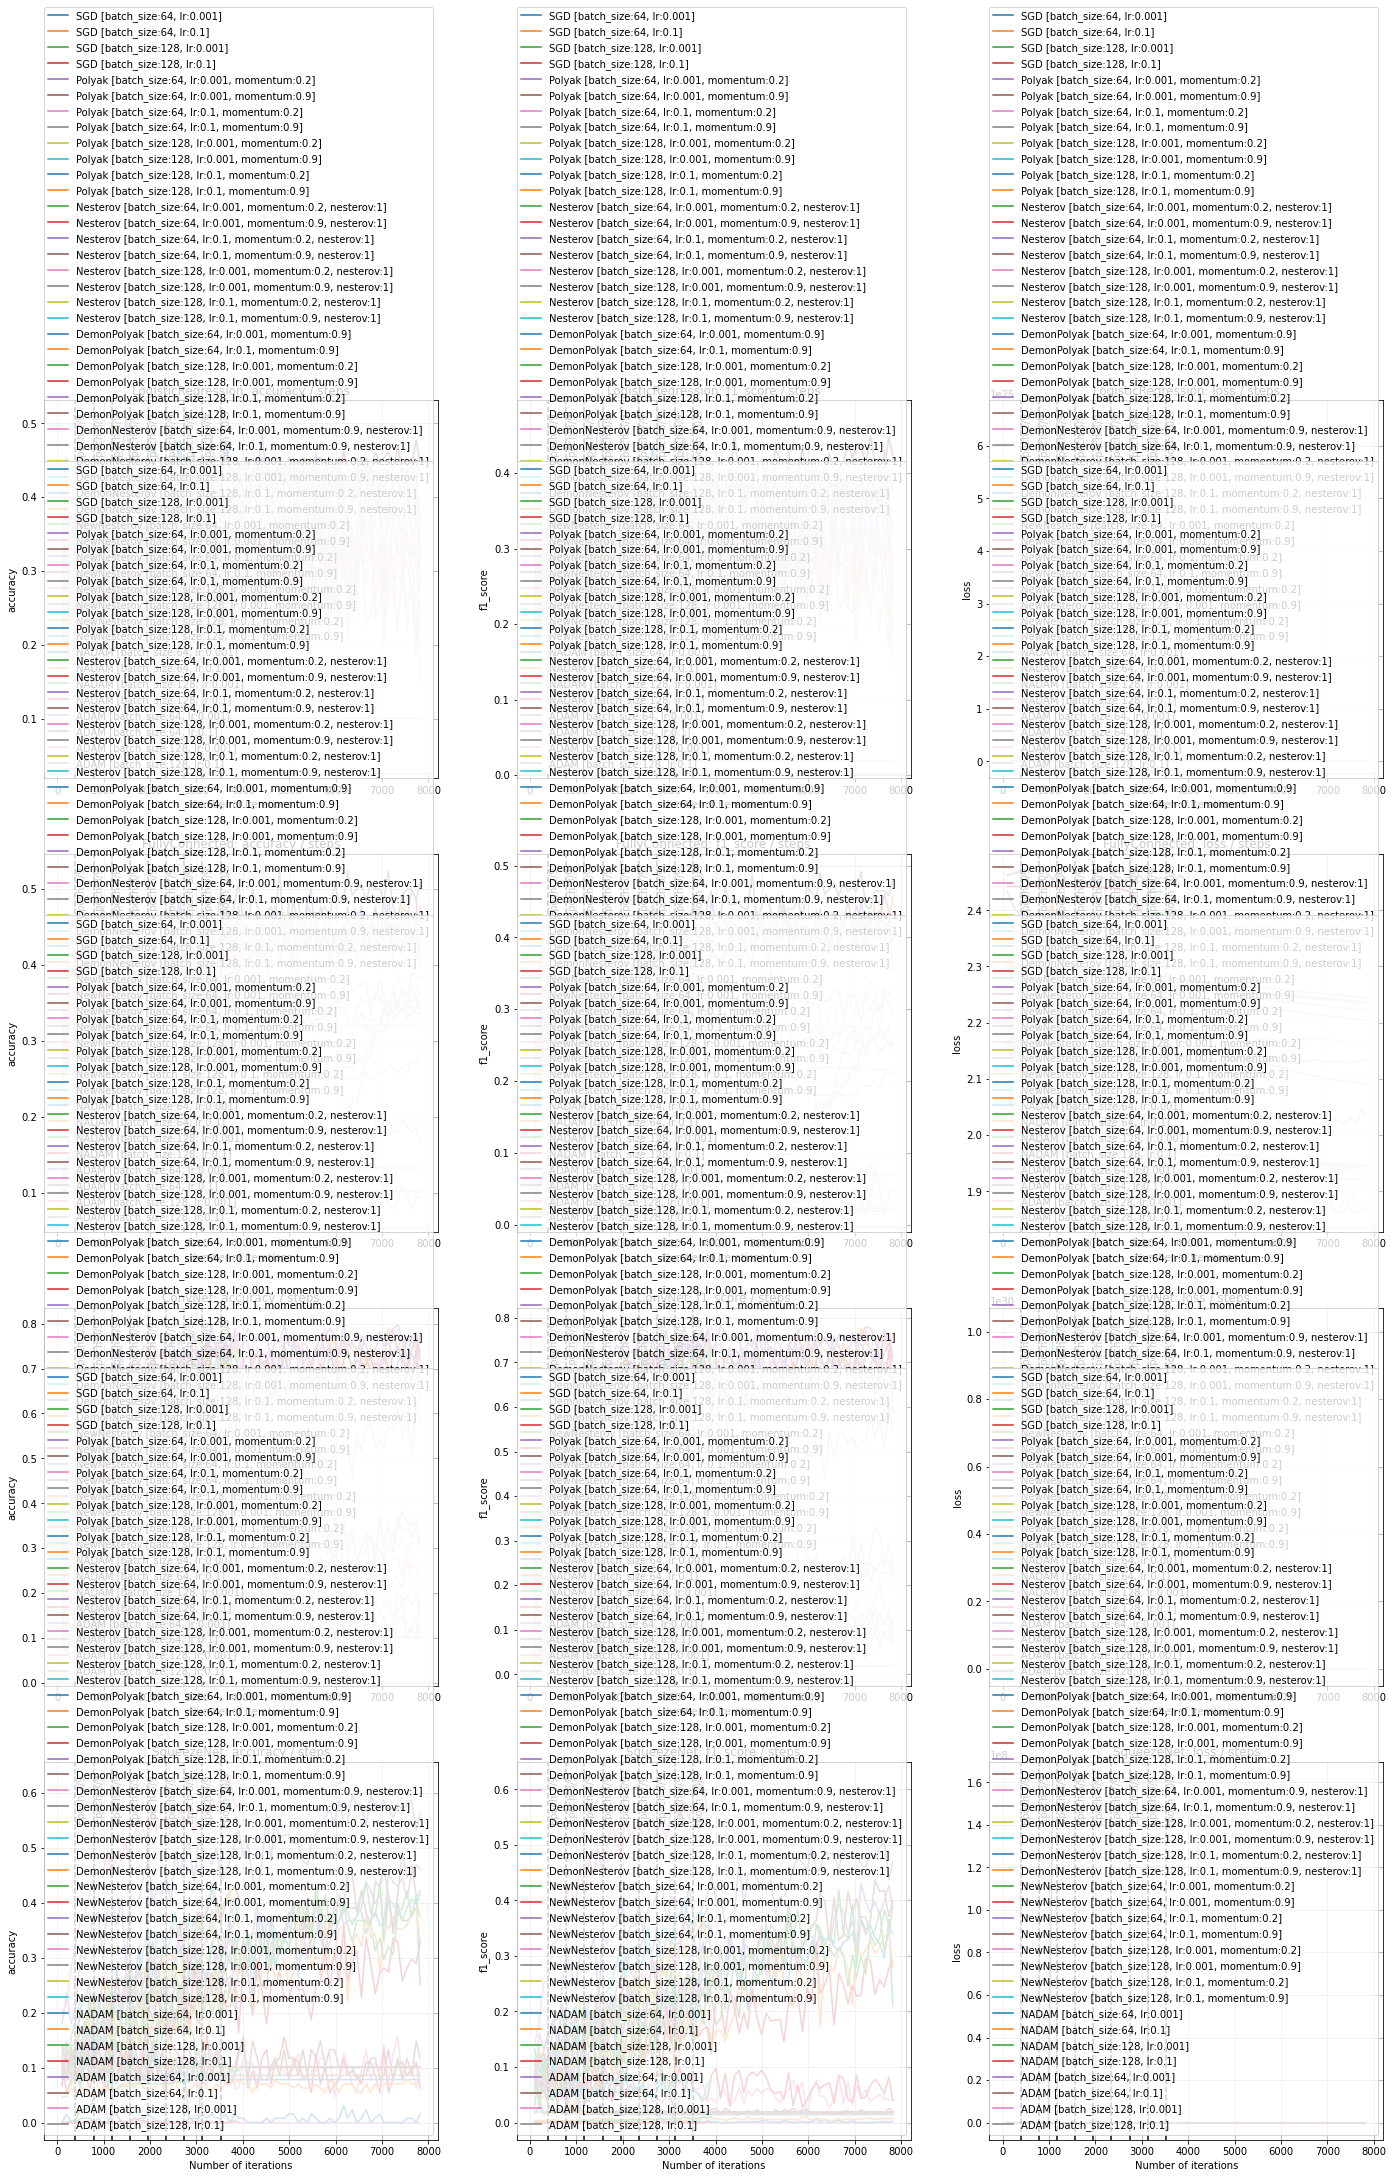

In [25]:
show_graphs(metrics)

In [14]:
import itertools

def generate_all_variants(opts):
    args = []
    for k, v in opts.items():
        args.append([])
        for arg in v:
            args[-1].append((k, arg))
    return map(dict, itertools.product(*args))

def merge_dicts(lhs, rhs):
    return {**lhs, **rhs}

def print_optimizer_opts(opts):
    return ', '.join([f'{k}:{v}' for k, v in opts.items()])

options = {
    "experiment_options":{
        "epochs": 10
    },
    'device_option': 'cuda:0',
}

common_params = {'batch_size': [64, 128], 'lr': [0.001, 0.1]}
default_momentums = [0.2, 0.9]
default_polyak = {'momentum': default_momentums}
default_nesterov = {'momentum': default_momentums, 'nesterov': [1]}

optimizers = [
    #('AdaptiveNonConvexSGD', AdaptiveNonConvexSGD, {'batch_size': [64, 128, 256]}),
    ('SGD', SGDOptimizer, common_params),
    ('Polyak', SGDOptimizer, merge_dicts(common_params, default_polyak)),
    ('Nesterov', SGDOptimizer, merge_dicts(common_params, default_nesterov)),
    ('DemonPolyak', DemonOptimizer, merge_dicts(common_params, default_polyak)),
    ('DemonNesterov', DemonOptimizer, merge_dicts(common_params, default_nesterov)),
    ('NewNesterov', NewNesterovOptimizer, merge_dicts(common_params, default_polyak)),
    ('NADAM', NadamOptimizer, common_params),
    ('ADAM', AdamOptimizer, common_params),
]

models = [
    ('LogisticRegression', LogisticRegression, {'input_dim': 32 * 32 * 3, 'output_dim': 10}),
    ('FullyConnected', FullyConnected, {'input_dim': 32 * 32 * 3, 'hidden_dim': 128, 'output_dim': 10}),
    ('ConvNet', ConvNet, {'in_ch': 3, 'output_dim': 10}),
    ('SqueezeNet', SqueezeNet, {}),
]

metrics = {}

import pickle

state_num = 0
for model_name, model, model_opts in models:
    metrics[model_name] = {
        'steps': {},
        'first_epoch_steps': {},
        'accuracy': {},
        'f1_score': {},
        'loss': {},
    }
    for optimizer_name, optimizer, optimizer_opts_variants in optimizers:
        for optimizer_opts in generate_all_variants(optimizer_opts_variants):
            opt_name_with_params = optimizer_name + ' [' + print_optimizer_opts(optimizer_opts) + ']'
            name = model_name + ' + ' + opt_name_with_params
            print('Start ' + name)
            options['model_options'] = model_opts
            options['optimizer_options'] = optimizer_opts
            try:
                stats = run_expirement(model, torch.nn.CrossEntropyLoss, optimizer, options)
                for m, res in zip(metrics[model_name], stats):
                    metrics[model_name][m][opt_name_with_params] = res
                with open(f'state/{state_num}', 'wb') as f:
                    pickle.dump(metrics, f)
                state_num += 1
            except Exception as e:
                print('ITERATION FAILED! Config is ' + name + ', error is ', e)

show_graphs(steps, first_epoch_steps, metrics)

Start LogisticRegression + SGD [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.359375, f1: 0.301244, loss: 1.881738: 100%|██████████| 782/782 [00:05<00:00, 138.44steps/s]
Epoch 2/10, accuracy: 0.437500, f1: 0.390171, loss: 1.803544: 100%|██████████| 782/782 [00:05<00:00, 140.57steps/s]
Epoch 3/10, accuracy: 0.429688, f1: 0.368707, loss: 1.774328: 100%|██████████| 782/782 [00:05<00:00, 138.91steps/s]
Epoch 4/10, accuracy: 0.421875, f1: 0.361604, loss: 1.756830: 100%|██████████| 782/782 [00:05<00:00, 135.85steps/s]
Epoch 5/10, accuracy: 0.437500, f1: 0.381639, loss: 1.741617: 100%|██████████| 782/782 [00:05<00:00, 136.08steps/s]
Epoch 6/10, accuracy: 0.421875, f1: 0.362510, loss: 1.730877: 100%|██████████| 782/782 [00:05<00:00, 136.46steps/s]
Epoch 7/10, accuracy: 0.437500, f1: 0.381532, loss: 1.721056: 100%|██████████| 782/782 [00:05<00:00, 135.64steps/s]
Epoch 8/10, accuracy: 0.421875, f1: 0.363030, loss: 1.709325: 100%|██████████| 782/782 [00:05<00:00, 135.76steps/s]
Epoch 9/10, accuracy: 0.421875, f1: 0.358920, loss: 1.710907: 100%|█████

Start LogisticRegression + SGD [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.382812, f1: 0.347068, loss: 2.417563: 100%|██████████| 782/782 [00:05<00:00, 135.26steps/s]
Epoch 2/10, accuracy: 0.289062, f1: 0.284678, loss: 2.502921: 100%|██████████| 782/782 [00:05<00:00, 132.51steps/s]
Epoch 3/10, accuracy: 0.406250, f1: 0.348144, loss: 1.974649: 100%|██████████| 782/782 [00:06<00:00, 129.84steps/s]
Epoch 4/10, accuracy: 0.406250, f1: 0.374057, loss: 1.892208: 100%|██████████| 782/782 [00:05<00:00, 134.41steps/s]
Epoch 5/10, accuracy: 0.328125, f1: 0.323409, loss: 2.342489: 100%|██████████| 782/782 [00:05<00:00, 132.99steps/s]
Epoch 6/10, accuracy: 0.273438, f1: 0.257085, loss: 2.352721: 100%|██████████| 782/782 [00:05<00:00, 137.60steps/s]
Epoch 7/10, accuracy: 0.367188, f1: 0.298793, loss: 2.587098: 100%|██████████| 782/782 [00:05<00:00, 137.17steps/s]
Epoch 8/10, accuracy: 0.343750, f1: 0.329801, loss: 2.237809: 100%|██████████| 782/782 [00:05<00:00, 136.11steps/s]
Epoch 9/10, accuracy: 0.382812, f1: 0.374885, loss: 2.073148: 100%|█████

Start LogisticRegression + SGD [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.289062, f1: 0.244462, loss: 1.997419: 100%|██████████| 391/391 [00:04<00:00, 81.43steps/s]
Epoch 2/10, accuracy: 0.324219, f1: 0.288057, loss: 1.933128: 100%|██████████| 391/391 [00:04<00:00, 81.72steps/s]
Epoch 3/10, accuracy: 0.312500, f1: 0.280373, loss: 1.904438: 100%|██████████| 391/391 [00:04<00:00, 80.82steps/s]
Epoch 4/10, accuracy: 0.328125, f1: 0.290081, loss: 1.881667: 100%|██████████| 391/391 [00:04<00:00, 81.22steps/s]
Epoch 5/10, accuracy: 0.335938, f1: 0.303382, loss: 1.871242: 100%|██████████| 391/391 [00:04<00:00, 80.66steps/s]
Epoch 6/10, accuracy: 0.347656, f1: 0.311327, loss: 1.858121: 100%|██████████| 391/391 [00:04<00:00, 81.28steps/s]
Epoch 7/10, accuracy: 0.335938, f1: 0.296200, loss: 1.853684: 100%|██████████| 391/391 [00:04<00:00, 81.72steps/s]
Epoch 8/10, accuracy: 0.339844, f1: 0.304470, loss: 1.848076: 100%|██████████| 391/391 [00:04<00:00, 80.76steps/s]
Epoch 9/10, accuracy: 0.343750, f1: 0.305904, loss: 1.845186: 100%|██████████| 3

Start LogisticRegression + SGD [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.285156, f1: 0.267341, loss: 2.117723: 100%|██████████| 391/391 [00:04<00:00, 81.97steps/s]
Epoch 2/10, accuracy: 0.332031, f1: 0.310830, loss: 2.058394: 100%|██████████| 391/391 [00:04<00:00, 81.69steps/s]
Epoch 3/10, accuracy: 0.359375, f1: 0.321426, loss: 2.014724: 100%|██████████| 391/391 [00:04<00:00, 82.18steps/s]
Epoch 4/10, accuracy: 0.335938, f1: 0.312507, loss: 1.978706: 100%|██████████| 391/391 [00:04<00:00, 81.03steps/s]
Epoch 5/10, accuracy: 0.320312, f1: 0.312289, loss: 2.198272: 100%|██████████| 391/391 [00:04<00:00, 80.35steps/s]
Epoch 6/10, accuracy: 0.304688, f1: 0.294489, loss: 2.152529: 100%|██████████| 391/391 [00:04<00:00, 81.07steps/s]
Epoch 7/10, accuracy: 0.343750, f1: 0.322452, loss: 2.247214: 100%|██████████| 391/391 [00:04<00:00, 80.88steps/s]
Epoch 8/10, accuracy: 0.324219, f1: 0.306930, loss: 2.251271: 100%|██████████| 391/391 [00:04<00:00, 82.92steps/s]
Epoch 9/10, accuracy: 0.289062, f1: 0.268081, loss: 2.261613: 100%|██████████| 3

Start LogisticRegression + Polyak [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.328125, f1: 0.291379, loss: 1.859746: 100%|██████████| 782/782 [00:05<00:00, 133.82steps/s]
Epoch 2/10, accuracy: 0.437500, f1: 0.381571, loss: 1.796630: 100%|██████████| 782/782 [00:05<00:00, 135.23steps/s]
Epoch 3/10, accuracy: 0.437500, f1: 0.382738, loss: 1.774606: 100%|██████████| 782/782 [00:05<00:00, 137.50steps/s]
Epoch 4/10, accuracy: 0.429688, f1: 0.364361, loss: 1.753920: 100%|██████████| 782/782 [00:05<00:00, 136.63steps/s]
Epoch 5/10, accuracy: 0.414062, f1: 0.372315, loss: 1.740328: 100%|██████████| 782/782 [00:05<00:00, 135.25steps/s]
Epoch 6/10, accuracy: 0.390625, f1: 0.352465, loss: 1.733830: 100%|██████████| 782/782 [00:05<00:00, 134.97steps/s]
Epoch 7/10, accuracy: 0.437500, f1: 0.377481, loss: 1.717909: 100%|██████████| 782/782 [00:05<00:00, 136.57steps/s]
Epoch 8/10, accuracy: 0.406250, f1: 0.359837, loss: 1.717978: 100%|██████████| 782/782 [00:05<00:00, 134.87steps/s]
Epoch 9/10, accuracy: 0.429688, f1: 0.369124, loss: 1.697764: 100%|█████

Start LogisticRegression + Polyak [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.281250, f1: 0.259265, loss: 24.507168: 100%|██████████| 782/782 [00:05<00:00, 135.75steps/s]
Epoch 2/10, accuracy: 0.289062, f1: 0.259705, loss: 9.878168: 100%|██████████| 782/782 [00:05<00:00, 136.06steps/s] 
Epoch 3/10, accuracy: 0.351562, f1: 0.316165, loss: 5.417408: 100%|██████████| 782/782 [00:05<00:00, 132.86steps/s]
Epoch 4/10, accuracy: 0.351562, f1: 0.316490, loss: 3.438722: 100%|██████████| 782/782 [00:05<00:00, 134.81steps/s]
Epoch 5/10, accuracy: 0.359375, f1: 0.312902, loss: 2.399209: 100%|██████████| 782/782 [00:05<00:00, 135.32steps/s]
Epoch 6/10, accuracy: 0.429688, f1: 0.408462, loss: 2.046171: 100%|██████████| 782/782 [00:05<00:00, 137.81steps/s]
Epoch 7/10, accuracy: 0.445312, f1: 0.419095, loss: 1.904379: 100%|██████████| 782/782 [00:05<00:00, 135.02steps/s]
Epoch 8/10, accuracy: 0.406250, f1: 0.386761, loss: 1.894176: 100%|██████████| 782/782 [00:05<00:00, 135.77steps/s]
Epoch 9/10, accuracy: 0.445312, f1: 0.420743, loss: 1.803793: 100%|███

Start LogisticRegression + Polyak [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.242188, f1: 0.224368, loss: 2.675477: 100%|██████████| 782/782 [00:05<00:00, 136.81steps/s]
Epoch 2/10, accuracy: 0.382812, f1: 0.351307, loss: 2.674055: 100%|██████████| 782/782 [00:05<00:00, 135.54steps/s]
Epoch 3/10, accuracy: 0.320312, f1: 0.305001, loss: 2.376267: 100%|██████████| 782/782 [00:05<00:00, 139.00steps/s]
Epoch 4/10, accuracy: 0.390625, f1: 0.356381, loss: 2.296778: 100%|██████████| 782/782 [00:05<00:00, 137.01steps/s]
Epoch 5/10, accuracy: 0.406250, f1: 0.352322, loss: 2.177405: 100%|██████████| 782/782 [00:05<00:00, 138.95steps/s]
Epoch 6/10, accuracy: 0.367188, f1: 0.346720, loss: 2.335869: 100%|██████████| 782/782 [00:05<00:00, 135.71steps/s]
Epoch 7/10, accuracy: 0.406250, f1: 0.385323, loss: 1.950396: 100%|██████████| 782/782 [00:05<00:00, 136.16steps/s]
Epoch 8/10, accuracy: 0.390625, f1: 0.342103, loss: 2.078924: 100%|██████████| 782/782 [00:05<00:00, 136.90steps/s]
Epoch 9/10, accuracy: 0.304688, f1: 0.283740, loss: 2.200604: 100%|█████

Start LogisticRegression + Polyak [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.289062, f1: 0.269716, loss: 8.470573: 100%|██████████| 782/782 [00:05<00:00, 135.78steps/s] 
Epoch 2/10, accuracy: 0.335938, f1: 0.317182, loss: 6.960800: 100%|██████████| 782/782 [00:05<00:00, 138.34steps/s]
Epoch 3/10, accuracy: 0.375000, f1: 0.315046, loss: 7.756947: 100%|██████████| 782/782 [00:05<00:00, 135.23steps/s]
Epoch 4/10, accuracy: 0.257812, f1: 0.252762, loss: 8.557499: 100%|██████████| 782/782 [00:05<00:00, 132.94steps/s] 
Epoch 5/10, accuracy: 0.343750, f1: 0.326151, loss: 9.257567: 100%|██████████| 782/782 [00:05<00:00, 133.88steps/s] 
Epoch 6/10, accuracy: 0.289062, f1: 0.249307, loss: 10.228284: 100%|██████████| 782/782 [00:05<00:00, 137.32steps/s]
Epoch 7/10, accuracy: 0.296875, f1: 0.279231, loss: 8.373542: 100%|██████████| 782/782 [00:05<00:00, 134.62steps/s] 
Epoch 8/10, accuracy: 0.312500, f1: 0.301763, loss: 7.663004: 100%|██████████| 782/782 [00:05<00:00, 134.35steps/s] 
Epoch 9/10, accuracy: 0.296875, f1: 0.272296, loss: 8.012437: 100%

Start LogisticRegression + Polyak [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.316406, f1: 0.287252, loss: 1.960489: 100%|██████████| 391/391 [00:04<00:00, 80.10steps/s]
Epoch 2/10, accuracy: 0.351562, f1: 0.313872, loss: 1.912170: 100%|██████████| 391/391 [00:04<00:00, 80.37steps/s]
Epoch 3/10, accuracy: 0.367188, f1: 0.323987, loss: 1.883523: 100%|██████████| 391/391 [00:04<00:00, 80.70steps/s]
Epoch 4/10, accuracy: 0.382812, f1: 0.340700, loss: 1.872279: 100%|██████████| 391/391 [00:05<00:00, 78.06steps/s]
Epoch 5/10, accuracy: 0.371094, f1: 0.334392, loss: 1.863709: 100%|██████████| 391/391 [00:04<00:00, 80.05steps/s]
Epoch 6/10, accuracy: 0.371094, f1: 0.331202, loss: 1.847915: 100%|██████████| 391/391 [00:04<00:00, 81.82steps/s]
Epoch 7/10, accuracy: 0.378906, f1: 0.339474, loss: 1.842375: 100%|██████████| 391/391 [00:04<00:00, 80.52steps/s]
Epoch 8/10, accuracy: 0.386719, f1: 0.346525, loss: 1.837044: 100%|██████████| 391/391 [00:04<00:00, 82.34steps/s]
Epoch 9/10, accuracy: 0.382812, f1: 0.344315, loss: 1.835183: 100%|██████████| 3

Start LogisticRegression + Polyak [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.253906, f1: 0.216513, loss: 46.218811: 100%|██████████| 391/391 [00:04<00:00, 80.37steps/s]
Epoch 2/10, accuracy: 0.292969, f1: 0.266927, loss: 19.332924: 100%|██████████| 391/391 [00:04<00:00, 82.23steps/s]
Epoch 3/10, accuracy: 0.273438, f1: 0.258987, loss: 10.675306: 100%|██████████| 391/391 [00:04<00:00, 82.44steps/s]
Epoch 4/10, accuracy: 0.300781, f1: 0.280631, loss: 6.919930: 100%|██████████| 391/391 [00:04<00:00, 84.00steps/s]
Epoch 5/10, accuracy: 0.285156, f1: 0.270107, loss: 5.062671: 100%|██████████| 391/391 [00:04<00:00, 81.01steps/s]
Epoch 6/10, accuracy: 0.285156, f1: 0.269106, loss: 3.814302: 100%|██████████| 391/391 [00:04<00:00, 81.21steps/s]
Epoch 7/10, accuracy: 0.296875, f1: 0.268876, loss: 3.004438: 100%|██████████| 391/391 [00:04<00:00, 80.39steps/s]
Epoch 8/10, accuracy: 0.296875, f1: 0.267534, loss: 2.572938: 100%|██████████| 391/391 [00:04<00:00, 82.59steps/s]
Epoch 9/10, accuracy: 0.308594, f1: 0.278494, loss: 2.309861: 100%|██████████

Start LogisticRegression + Polyak [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.289062, f1: 0.267167, loss: 2.006711: 100%|██████████| 391/391 [00:04<00:00, 82.18steps/s]
Epoch 2/10, accuracy: 0.285156, f1: 0.284397, loss: 2.556089: 100%|██████████| 391/391 [00:04<00:00, 83.32steps/s]
Epoch 3/10, accuracy: 0.312500, f1: 0.305318, loss: 1.976297: 100%|██████████| 391/391 [00:04<00:00, 81.02steps/s]
Epoch 4/10, accuracy: 0.289062, f1: 0.274366, loss: 2.266663: 100%|██████████| 391/391 [00:04<00:00, 83.57steps/s]
Epoch 5/10, accuracy: 0.320312, f1: 0.293947, loss: 2.009762: 100%|██████████| 391/391 [00:04<00:00, 79.00steps/s]
Epoch 6/10, accuracy: 0.328125, f1: 0.314871, loss: 2.033237: 100%|██████████| 391/391 [00:04<00:00, 84.32steps/s]
Epoch 7/10, accuracy: 0.332031, f1: 0.324518, loss: 2.109551: 100%|██████████| 391/391 [00:04<00:00, 80.56steps/s]
Epoch 8/10, accuracy: 0.312500, f1: 0.297574, loss: 2.143215: 100%|██████████| 391/391 [00:04<00:00, 82.42steps/s]
Epoch 9/10, accuracy: 0.347656, f1: 0.332260, loss: 2.109610: 100%|██████████| 3

Start LogisticRegression + Polyak [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.257812, f1: 0.239487, loss: 5.437446: 100%|██████████| 391/391 [00:04<00:00, 81.09steps/s]
Epoch 2/10, accuracy: 0.257812, f1: 0.253270, loss: 5.672091: 100%|██████████| 391/391 [00:04<00:00, 79.46steps/s]
Epoch 3/10, accuracy: 0.277344, f1: 0.253370, loss: 5.031585: 100%|██████████| 391/391 [00:04<00:00, 82.03steps/s]
Epoch 4/10, accuracy: 0.328125, f1: 0.303687, loss: 4.889567: 100%|██████████| 391/391 [00:04<00:00, 82.54steps/s]
Epoch 5/10, accuracy: 0.242188, f1: 0.217770, loss: 5.400434: 100%|██████████| 391/391 [00:04<00:00, 80.17steps/s]
Epoch 6/10, accuracy: 0.250000, f1: 0.204364, loss: 5.373473: 100%|██████████| 391/391 [00:05<00:00, 78.01steps/s]
Epoch 7/10, accuracy: 0.300781, f1: 0.281426, loss: 4.541704: 100%|██████████| 391/391 [00:04<00:00, 79.12steps/s]
Epoch 8/10, accuracy: 0.261719, f1: 0.241448, loss: 5.733919: 100%|██████████| 391/391 [00:04<00:00, 78.26steps/s]
Epoch 9/10, accuracy: 0.230469, f1: 0.214868, loss: 6.501892: 100%|██████████| 3

Start LogisticRegression + Nesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.375000, f1: 0.330309, loss: 1.928412: 100%|██████████| 782/782 [00:06<00:00, 127.42steps/s]
Epoch 2/10, accuracy: 0.406250, f1: 0.373169, loss: 1.802482: 100%|██████████| 782/782 [00:06<00:00, 123.64steps/s]
Epoch 3/10, accuracy: 0.437500, f1: 0.395287, loss: 1.754803: 100%|██████████| 782/782 [00:06<00:00, 123.70steps/s]
Epoch 4/10, accuracy: 0.382812, f1: 0.341317, loss: 1.746197: 100%|██████████| 782/782 [00:06<00:00, 120.73steps/s]
Epoch 5/10, accuracy: 0.421875, f1: 0.376263, loss: 1.710403: 100%|██████████| 782/782 [00:06<00:00, 123.48steps/s]
Epoch 6/10, accuracy: 0.437500, f1: 0.389979, loss: 1.705900: 100%|██████████| 782/782 [00:06<00:00, 127.49steps/s]
Epoch 7/10, accuracy: 0.406250, f1: 0.354601, loss: 1.689031: 100%|██████████| 782/782 [00:05<00:00, 135.38steps/s]
Epoch 8/10, accuracy: 0.414062, f1: 0.365806, loss: 1.674917: 100%|██████████| 782/782 [00:05<00:00, 133.90steps/s]
Epoch 9/10, accuracy: 0.406250, f1: 0.358626, loss: 1.681588: 100%|█████

Start LogisticRegression + Nesterov [batch_size:64, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.312500, f1: 0.296415, loss: 52.767773: 100%|██████████| 782/782 [00:05<00:00, 135.06steps/s] 
Epoch 2/10, accuracy: 0.382812, f1: 0.360011, loss: 22.147581: 100%|██████████| 782/782 [00:05<00:00, 134.91steps/s]
Epoch 3/10, accuracy: 0.312500, f1: 0.285320, loss: 12.467014: 100%|██████████| 782/782 [00:05<00:00, 133.71steps/s]
Epoch 4/10, accuracy: 0.265625, f1: 0.241498, loss: 7.426782: 100%|██████████| 782/782 [00:05<00:00, 134.70steps/s] 
Epoch 5/10, accuracy: 0.304688, f1: 0.293251, loss: 4.998526: 100%|██████████| 782/782 [00:05<00:00, 133.18steps/s]
Epoch 6/10, accuracy: 0.281250, f1: 0.259258, loss: 3.594203: 100%|██████████| 782/782 [00:05<00:00, 136.56steps/s]
Epoch 7/10, accuracy: 0.312500, f1: 0.295461, loss: 2.940820: 100%|██████████| 782/782 [00:05<00:00, 138.34steps/s]
Epoch 8/10, accuracy: 0.343750, f1: 0.295648, loss: 2.486639: 100%|██████████| 782/782 [00:05<00:00, 138.11steps/s]
Epoch 9/10, accuracy: 0.335938, f1: 0.291652, loss: 2.242744: 100%|

Start LogisticRegression + Nesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.406250, f1: 0.363243, loss: 2.542694: 100%|██████████| 782/782 [00:05<00:00, 140.50steps/s]
Epoch 2/10, accuracy: 0.289062, f1: 0.266214, loss: 2.491838: 100%|██████████| 782/782 [00:05<00:00, 137.08steps/s]
Epoch 3/10, accuracy: 0.328125, f1: 0.277377, loss: 2.516625: 100%|██████████| 782/782 [00:05<00:00, 134.61steps/s]
Epoch 4/10, accuracy: 0.320312, f1: 0.316489, loss: 3.231910: 100%|██████████| 782/782 [00:05<00:00, 133.76steps/s]
Epoch 5/10, accuracy: 0.375000, f1: 0.364599, loss: 2.688269: 100%|██████████| 782/782 [00:05<00:00, 138.42steps/s]
Epoch 6/10, accuracy: 0.289062, f1: 0.275161, loss: 3.009184: 100%|██████████| 782/782 [00:05<00:00, 133.72steps/s]
Epoch 7/10, accuracy: 0.382812, f1: 0.356590, loss: 2.129359: 100%|██████████| 782/782 [00:05<00:00, 136.81steps/s]
Epoch 8/10, accuracy: 0.335938, f1: 0.283347, loss: 3.087901: 100%|██████████| 782/782 [00:05<00:00, 135.32steps/s]
Epoch 9/10, accuracy: 0.335938, f1: 0.326885, loss: 2.270303: 100%|█████

Start LogisticRegression + Nesterov [batch_size:64, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.257812, f1: 0.247363, loss: 42.544823: 100%|██████████| 782/782 [00:05<00:00, 136.28steps/s]
Epoch 2/10, accuracy: 0.335938, f1: 0.297551, loss: 42.889465: 100%|██████████| 782/782 [00:05<00:00, 137.46steps/s]
Epoch 3/10, accuracy: 0.367188, f1: 0.287232, loss: 40.852978: 100%|██████████| 782/782 [00:05<00:00, 135.90steps/s]
Epoch 4/10, accuracy: 0.343750, f1: 0.320311, loss: 48.291840: 100%|██████████| 782/782 [00:05<00:00, 134.64steps/s]
Epoch 5/10, accuracy: 0.304688, f1: 0.288825, loss: 42.996368: 100%|██████████| 782/782 [00:05<00:00, 136.63steps/s]
Epoch 6/10, accuracy: 0.265625, f1: 0.202143, loss: 37.526810: 100%|██████████| 782/782 [00:05<00:00, 137.54steps/s]
Epoch 7/10, accuracy: 0.296875, f1: 0.297276, loss: 49.896622: 100%|██████████| 782/782 [00:05<00:00, 137.07steps/s]
Epoch 8/10, accuracy: 0.320312, f1: 0.296564, loss: 37.520515: 100%|██████████| 782/782 [00:05<00:00, 136.07steps/s]
Epoch 9/10, accuracy: 0.257812, f1: 0.213683, loss: 38.047581: 1

Start LogisticRegression + Nesterov [batch_size:128, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.285156, f1: 0.257336, loss: 2.134076: 100%|██████████| 391/391 [00:04<00:00, 81.53steps/s]
Epoch 2/10, accuracy: 0.335938, f1: 0.304746, loss: 1.889130: 100%|██████████| 391/391 [00:04<00:00, 81.64steps/s]
Epoch 3/10, accuracy: 0.343750, f1: 0.303815, loss: 1.856596: 100%|██████████| 391/391 [00:04<00:00, 82.55steps/s]
Epoch 4/10, accuracy: 0.359375, f1: 0.318994, loss: 1.844827: 100%|██████████| 391/391 [00:04<00:00, 81.28steps/s]
Epoch 5/10, accuracy: 0.367188, f1: 0.327068, loss: 1.827343: 100%|██████████| 391/391 [00:04<00:00, 82.89steps/s]
Epoch 6/10, accuracy: 0.363281, f1: 0.324717, loss: 1.818483: 100%|██████████| 391/391 [00:04<00:00, 79.95steps/s]
Epoch 7/10, accuracy: 0.371094, f1: 0.332326, loss: 1.813713: 100%|██████████| 391/391 [00:04<00:00, 79.54steps/s]
Epoch 8/10, accuracy: 0.355469, f1: 0.317076, loss: 1.812856: 100%|██████████| 391/391 [00:04<00:00, 80.55steps/s]
Epoch 9/10, accuracy: 0.367188, f1: 0.336008, loss: 1.806376: 100%|██████████| 3

Start LogisticRegression + Nesterov [batch_size:128, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.261719, f1: 0.215701, loss: 191.708923: 100%|██████████| 391/391 [00:04<00:00, 80.27steps/s]
Epoch 2/10, accuracy: 0.289062, f1: 0.263399, loss: 79.051277: 100%|██████████| 391/391 [00:04<00:00, 81.10steps/s] 
Epoch 3/10, accuracy: 0.273438, f1: 0.256297, loss: 36.694130: 100%|██████████| 391/391 [00:04<00:00, 81.68steps/s]
Epoch 4/10, accuracy: 0.269531, f1: 0.257449, loss: 25.062584: 100%|██████████| 391/391 [00:04<00:00, 80.39steps/s]
Epoch 5/10, accuracy: 0.269531, f1: 0.259366, loss: 18.392345: 100%|██████████| 391/391 [00:04<00:00, 81.20steps/s]
Epoch 6/10, accuracy: 0.281250, f1: 0.269102, loss: 13.657912: 100%|██████████| 391/391 [00:04<00:00, 82.39steps/s]
Epoch 7/10, accuracy: 0.250000, f1: 0.241612, loss: 10.613646: 100%|██████████| 391/391 [00:04<00:00, 79.56steps/s]
Epoch 8/10, accuracy: 0.269531, f1: 0.258698, loss: 8.054990: 100%|██████████| 391/391 [00:04<00:00, 81.12steps/s]
Epoch 9/10, accuracy: 0.281250, f1: 0.269865, loss: 6.105742: 100%|████

Start LogisticRegression + Nesterov [batch_size:128, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.269531, f1: 0.259429, loss: 2.566548: 100%|██████████| 391/391 [00:04<00:00, 83.48steps/s]
Epoch 2/10, accuracy: 0.378906, f1: 0.353118, loss: 2.042500: 100%|██████████| 391/391 [00:04<00:00, 82.05steps/s]
Epoch 3/10, accuracy: 0.285156, f1: 0.270530, loss: 2.344531: 100%|██████████| 391/391 [00:04<00:00, 82.34steps/s]
Epoch 4/10, accuracy: 0.371094, f1: 0.343946, loss: 2.035691: 100%|██████████| 391/391 [00:04<00:00, 82.18steps/s]
Epoch 5/10, accuracy: 0.332031, f1: 0.310104, loss: 2.219614: 100%|██████████| 391/391 [00:04<00:00, 82.54steps/s]
Epoch 6/10, accuracy: 0.363281, f1: 0.354473, loss: 2.253597: 100%|██████████| 391/391 [00:04<00:00, 80.59steps/s]
Epoch 7/10, accuracy: 0.324219, f1: 0.294482, loss: 2.269443: 100%|██████████| 391/391 [00:04<00:00, 80.37steps/s]
Epoch 8/10, accuracy: 0.335938, f1: 0.320483, loss: 2.183125: 100%|██████████| 391/391 [00:04<00:00, 82.83steps/s]
Epoch 9/10, accuracy: 0.359375, f1: 0.345856, loss: 2.271798: 100%|██████████| 3

Start LogisticRegression + Nesterov [batch_size:128, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.253906, f1: 0.242977, loss: 42.228409: 100%|██████████| 391/391 [00:04<00:00, 81.02steps/s]
Epoch 2/10, accuracy: 0.289062, f1: 0.259415, loss: 38.230782: 100%|██████████| 391/391 [00:04<00:00, 83.66steps/s]
Epoch 3/10, accuracy: 0.304688, f1: 0.281746, loss: 26.204731: 100%|██████████| 391/391 [00:04<00:00, 82.38steps/s]
Epoch 4/10, accuracy: 0.281250, f1: 0.257373, loss: 31.705780: 100%|██████████| 391/391 [00:04<00:00, 83.44steps/s]
Epoch 5/10, accuracy: 0.277344, f1: 0.255197, loss: 39.734413: 100%|██████████| 391/391 [00:04<00:00, 80.88steps/s]
Epoch 6/10, accuracy: 0.230469, f1: 0.213195, loss: 27.815662: 100%|██████████| 391/391 [00:04<00:00, 81.58steps/s]
Epoch 7/10, accuracy: 0.234375, f1: 0.217272, loss: 29.498501: 100%|██████████| 391/391 [00:04<00:00, 81.81steps/s]
Epoch 8/10, accuracy: 0.210938, f1: 0.206704, loss: 31.082077: 100%|██████████| 391/391 [00:04<00:00, 81.64steps/s]
Epoch 9/10, accuracy: 0.191406, f1: 0.179921, loss: 37.212166: 100%|████

Start LogisticRegression + DemonPolyak [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.351562, f1: 0.310980, loss: 1.876339: 100%|██████████| 782/782 [00:05<00:00, 141.40steps/s]
Epoch 2/10, accuracy: 0.406250, f1: 0.355106, loss: 1.819515: 100%|██████████| 782/782 [00:05<00:00, 139.48steps/s]
Epoch 3/10, accuracy: 0.398438, f1: 0.333678, loss: 1.795152: 100%|██████████| 782/782 [00:05<00:00, 136.04steps/s]
Epoch 4/10, accuracy: 0.406250, f1: 0.342812, loss: 1.779410: 100%|██████████| 782/782 [00:05<00:00, 136.58steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.96steps/s]                           
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.76steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 131.83steps/s]
Epochs:  60%|██████    | 6/10 [00:37<00:24,  6.21s/epochs]


ITERATION FAILED! Config is LogisticRegression + DemonPolyak [batch_size:64, lr:0.001, momentum:0.2], error is  float division by zero
Start LogisticRegression + DemonPolyak [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.351562, f1: 0.313054, loss: 35.943535: 100%|██████████| 782/782 [00:05<00:00, 136.60steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.97steps/s]         
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 140.08steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.80steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.99steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 136.50steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.50steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.24steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 1

Start LogisticRegression + DemonPolyak [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.335938, f1: 0.329979, loss: 1.954157: 100%|██████████| 782/782 [00:05<00:00, 134.48steps/s]
Epoch 2/10, accuracy: 0.421875, f1: 0.380303, loss: 1.960126: 100%|██████████| 782/782 [00:05<00:00, 134.40steps/s]
Epoch 3/10, accuracy: 0.406250, f1: 0.371395, loss: 2.697177: 100%|██████████| 782/782 [00:05<00:00, 137.20steps/s]
Epoch 4/10, accuracy: 0.054688, f1: 0.033082, loss: 762.507690: 100%|██████████| 782/782 [00:05<00:00, 133.76steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.66steps/s]                              
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.21steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 129.24steps/s]
Epochs:  60%|██████    | 6/10 [00:37<00:25,  6.31s/epochs]


ITERATION FAILED! Config is LogisticRegression + DemonPolyak [batch_size:64, lr:0.1, momentum:0.2], error is  float division by zero
Start LogisticRegression + DemonPolyak [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.296875, f1: 0.280088, loss: 3.712463: 100%|██████████| 782/782 [00:05<00:00, 137.02steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 139.68steps/s]            
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.84steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.44steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.03steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.51steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.64steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 140.40steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00,

Start LogisticRegression + DemonPolyak [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.308594, f1: 0.270238, loss: 1.955410: 100%|██████████| 391/391 [00:04<00:00, 82.05steps/s]
Epoch 2/10, accuracy: 0.312500, f1: 0.272929, loss: 1.912582: 100%|██████████| 391/391 [00:04<00:00, 80.96steps/s]
Epoch 3/10, accuracy: 0.324219, f1: 0.284215, loss: 1.897669: 100%|██████████| 391/391 [00:04<00:00, 80.71steps/s]
Epoch 4/10, accuracy: 0.335938, f1: 0.290160, loss: 1.882709: 100%|██████████| 391/391 [00:04<00:00, 81.87steps/s]
Epoch 5/10, accuracy: 0.347656, f1: 0.309984, loss: 1.875698: 100%|██████████| 391/391 [00:04<00:00, 80.19steps/s]
Epoch 6/10, accuracy: 0.363281, f1: 0.321445, loss: 1.869569: 100%|██████████| 391/391 [00:04<00:00, 82.97steps/s]
Epoch 7/10, accuracy: 0.351562, f1: 0.314397, loss: 1.865946: 100%|██████████| 391/391 [00:04<00:00, 81.50steps/s]
Epoch 8/10, accuracy: 0.343750, f1: 0.306252, loss: 1.863650: 100%|██████████| 391/391 [00:04<00:00, 80.86steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/39

Start LogisticRegression + DemonPolyak [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.242188, f1: 0.214502, loss: 45.830532: 100%|██████████| 391/391 [00:04<00:00, 80.64steps/s]
Epoch 2/10, accuracy: 0.269531, f1: 0.245014, loss: 25.177658: 100%|██████████| 391/391 [00:04<00:00, 83.25steps/s]
Epoch 3/10, accuracy: 0.113281, f1: 0.071732, loss: 10817.748047: 100%|██████████| 391/391 [00:04<00:00, 81.77steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 84.94steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 83.24steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 83.33steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.62steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 84.02steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.

Start LogisticRegression + DemonPolyak [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.324219, f1: 0.294900, loss: 2.040020: 100%|██████████| 391/391 [00:04<00:00, 79.18steps/s]
Epoch 2/10, accuracy: 0.320312, f1: 0.298875, loss: 1.932310: 100%|██████████| 391/391 [00:04<00:00, 82.75steps/s]
Epoch 3/10, accuracy: 0.304688, f1: 0.291051, loss: 2.372008: 100%|██████████| 391/391 [00:04<00:00, 79.55steps/s]
Epoch 4/10, accuracy: 0.316406, f1: 0.301654, loss: 2.196045: 100%|██████████| 391/391 [00:04<00:00, 81.26steps/s]
Epoch 5/10, accuracy: 0.285156, f1: 0.270293, loss: 2.651271: 100%|██████████| 391/391 [00:04<00:00, 83.61steps/s]
Epoch 6/10, accuracy: 0.320312, f1: 0.313174, loss: 3.573328: 100%|██████████| 391/391 [00:04<00:00, 82.19steps/s]
Epoch 7/10, accuracy: 0.277344, f1: 0.244491, loss: 6.259179: 100%|██████████| 391/391 [00:04<00:00, 82.29steps/s]
Epoch 8/10, accuracy: 0.054688, f1: 0.048080, loss: 468.776001: 100%|██████████| 391/391 [00:04<00:00, 80.09steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/

Start LogisticRegression + DemonPolyak [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.296875, f1: 0.264847, loss: 3.435667: 100%|██████████| 391/391 [00:04<00:00, 82.86steps/s]
Epoch 2/10, accuracy: 0.339844, f1: 0.321880, loss: 2.455409: 100%|██████████| 391/391 [00:04<00:00, 81.51steps/s]
Epoch 3/10, accuracy: 0.105469, f1: 0.036683, loss: 19521744.000000: 100%|██████████| 391/391 [00:04<00:00, 82.42steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 82.56steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.07steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.78steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 83.07steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.31steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 82

Start LogisticRegression + DemonNesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.359375, f1: 0.299716, loss: 1.859421: 100%|██████████| 782/782 [00:05<00:00, 136.50steps/s]
Epoch 2/10, accuracy: 0.367188, f1: 0.298695, loss: 1.777197: 100%|██████████| 782/782 [00:05<00:00, 134.08steps/s]
Epoch 3/10, accuracy: 0.375000, f1: 0.307885, loss: 1.759305: 100%|██████████| 782/782 [00:05<00:00, 138.31steps/s]
Epoch 4/10, accuracy: 0.367188, f1: 0.303017, loss: 1.849035: 100%|██████████| 782/782 [00:05<00:00, 138.82steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.88steps/s]                           
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 139.94steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 133.09steps/s]
Epochs:  60%|██████    | 6/10 [00:37<00:24,  6.21s/epochs]


ITERATION FAILED! Config is LogisticRegression + DemonNesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1], error is  float division by zero
Start LogisticRegression + DemonNesterov [batch_size:64, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.273438, f1: 0.220365, loss: 154.865112: 100%|██████████| 782/782 [00:05<00:00, 135.45steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.47steps/s]        
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.97steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.07steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.61steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.88steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.89steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.09steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 1

Start LogisticRegression + DemonNesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.296875, f1: 0.292675, loss: 2.483568: 100%|██████████| 782/782 [00:05<00:00, 139.21steps/s]
Epoch 2/10, accuracy: 0.343750, f1: 0.328782, loss: 2.084561: 100%|██████████| 782/782 [00:05<00:00, 136.37steps/s]
Epoch 3/10, accuracy: 0.406250, f1: 0.347527, loss: 2.936338: 100%|██████████| 782/782 [00:05<00:00, 139.61steps/s]
Epoch 4/10, accuracy: 0.140625, f1: 0.051894, loss: 1500.416626: 100%|██████████| 782/782 [00:05<00:00, 138.16steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.70steps/s]                             
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.89steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 130.66steps/s]
Epochs:  60%|██████    | 6/10 [00:37<00:24,  6.18s/epochs]


ITERATION FAILED! Config is LogisticRegression + DemonNesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1], error is  float division by zero
Start LogisticRegression + DemonNesterov [batch_size:64, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.335938, f1: 0.318451, loss: 11.863783: 100%|██████████| 782/782 [00:05<00:00, 137.42steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 139.76steps/s]           
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.15steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.43steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 140.47steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.15steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.04steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 138.04steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00,

Start LogisticRegression + DemonNesterov [batch_size:128, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.304688, f1: 0.277938, loss: 2.097886: 100%|██████████| 391/391 [00:04<00:00, 82.22steps/s]
Epoch 2/10, accuracy: 0.304688, f1: 0.280805, loss: 1.929956: 100%|██████████| 391/391 [00:04<00:00, 79.76steps/s]
Epoch 3/10, accuracy: 0.332031, f1: 0.306059, loss: 1.893281: 100%|██████████| 391/391 [00:04<00:00, 79.70steps/s]
Epoch 4/10, accuracy: 0.316406, f1: 0.289960, loss: 1.880682: 100%|██████████| 391/391 [00:04<00:00, 81.43steps/s]
Epoch 5/10, accuracy: 0.320312, f1: 0.290245, loss: 1.872695: 100%|██████████| 391/391 [00:04<00:00, 83.50steps/s]
Epoch 6/10, accuracy: 0.324219, f1: 0.295447, loss: 1.871519: 100%|██████████| 391/391 [00:04<00:00, 80.63steps/s]
Epoch 7/10, accuracy: 0.324219, f1: 0.296215, loss: 1.874255: 100%|██████████| 391/391 [00:04<00:00, 81.29steps/s]
Epoch 8/10, accuracy: 0.328125, f1: 0.291803, loss: 1.922714: 100%|██████████| 391/391 [00:04<00:00, 81.79steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/39

Start LogisticRegression + DemonNesterov [batch_size:128, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.246094, f1: 0.204987, loss: 151.414291: 100%|██████████| 391/391 [00:04<00:00, 82.04steps/s]
Epoch 2/10, accuracy: 0.289062, f1: 0.256801, loss: 93.735710: 100%|██████████| 391/391 [00:04<00:00, 80.28steps/s] 
Epoch 3/10, accuracy: 0.148438, f1: 0.097748, loss: 6038.386230: 100%|██████████| 391/391 [00:04<00:00, 81.78steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.57steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 83.89steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 82.70steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 82.38steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 82.43steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 82

Start LogisticRegression + DemonNesterov [batch_size:128, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.292969, f1: 0.270352, loss: 2.358554: 100%|██████████| 391/391 [00:04<00:00, 82.58steps/s]
Epoch 2/10, accuracy: 0.289062, f1: 0.271491, loss: 2.471586: 100%|██████████| 391/391 [00:04<00:00, 80.51steps/s]
Epoch 3/10, accuracy: 0.320312, f1: 0.306789, loss: 2.439933: 100%|██████████| 391/391 [00:04<00:00, 82.40steps/s]
Epoch 4/10, accuracy: 0.355469, f1: 0.330092, loss: 1.958659: 100%|██████████| 391/391 [00:04<00:00, 82.65steps/s]
Epoch 5/10, accuracy: 0.328125, f1: 0.288501, loss: 2.424978: 100%|██████████| 391/391 [00:04<00:00, 81.70steps/s]
Epoch 6/10, accuracy: 0.253906, f1: 0.226273, loss: 4.167376: 100%|██████████| 391/391 [00:04<00:00, 78.92steps/s]
Epoch 7/10, accuracy: 0.074219, f1: 0.025614, loss: 304.843048: 100%|██████████| 391/391 [00:04<00:00, 81.72steps/s]
Epoch 8/10, accuracy: 0.078125, f1: 0.027367, loss: 1762.003174: 100%|██████████| 391/391 [00:04<00:00, 84.36steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 3

Start LogisticRegression + DemonNesterov [batch_size:128, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.269531, f1: 0.244823, loss: 26.772457: 100%|██████████| 391/391 [00:04<00:00, 82.90steps/s]
Epoch 2/10, accuracy: 0.253906, f1: 0.241742, loss: 13.911312: 100%|██████████| 391/391 [00:04<00:00, 80.16steps/s]
Epoch 3/10, accuracy: 0.093750, f1: 0.055488, loss: 8287758.000000: 100%|██████████| 391/391 [00:04<00:00, 83.03steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 83.06steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.18steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.64steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.06steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 82.10steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 8

Start LogisticRegression + NewNesterov [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.398438, f1: 0.334805, loss: 1.878623: 100%|██████████| 782/782 [00:07<00:00, 102.74steps/s]
Epoch 2/10, accuracy: 0.453125, f1: 0.402233, loss: 1.814117: 100%|██████████| 782/782 [00:07<00:00, 101.72steps/s]
Epoch 3/10, accuracy: 0.445312, f1: 0.402086, loss: 1.784482: 100%|██████████| 782/782 [00:07<00:00, 100.43steps/s]
Epoch 4/10, accuracy: 0.421875, f1: 0.358971, loss: 1.755367: 100%|██████████| 782/782 [00:07<00:00, 98.74steps/s] 
Epoch 5/10, accuracy: 0.421875, f1: 0.355910, loss: 1.743664: 100%|██████████| 782/782 [00:07<00:00, 99.83steps/s] 
Epoch 6/10, accuracy: 0.421875, f1: 0.366459, loss: 1.725635: 100%|██████████| 782/782 [00:07<00:00, 101.38steps/s]
Epoch 7/10, accuracy: 0.414062, f1: 0.352509, loss: 1.716758: 100%|██████████| 782/782 [00:07<00:00, 98.97steps/s] 
Epoch 8/10, accuracy: 0.421875, f1: 0.360192, loss: 1.717835: 100%|██████████| 782/782 [00:07<00:00, 99.24steps/s] 
Epoch 9/10, accuracy: 0.421875, f1: 0.360776, loss: 1.709537: 100%|█████

Start LogisticRegression + NewNesterov [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.375000, f1: 0.313120, loss: 1.883058: 100%|██████████| 782/782 [00:07<00:00, 101.82steps/s]
Epoch 2/10, accuracy: 0.390625, f1: 0.337881, loss: 1.814633: 100%|██████████| 782/782 [00:07<00:00, 100.63steps/s]
Epoch 3/10, accuracy: 0.398438, f1: 0.346539, loss: 1.781240: 100%|██████████| 782/782 [00:07<00:00, 99.94steps/s] 
Epoch 4/10, accuracy: 0.414062, f1: 0.354306, loss: 1.750072: 100%|██████████| 782/782 [00:07<00:00, 98.50steps/s] 
Epoch 5/10, accuracy: 0.437500, f1: 0.386303, loss: 1.741043: 100%|██████████| 782/782 [00:07<00:00, 98.77steps/s] 
Epoch 6/10, accuracy: 0.429688, f1: 0.376002, loss: 1.732859: 100%|██████████| 782/782 [00:07<00:00, 98.53steps/s] 
Epoch 7/10, accuracy: 0.445312, f1: 0.398121, loss: 1.724030: 100%|██████████| 782/782 [00:07<00:00, 99.52steps/s] 
Epoch 8/10, accuracy: 0.460938, f1: 0.406758, loss: 1.712559: 100%|██████████| 782/782 [00:07<00:00, 102.35steps/s]
Epoch 9/10, accuracy: 0.414062, f1: 0.349463, loss: 1.691437: 100%|█████

Start LogisticRegression + NewNesterov [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.335938, f1: 0.299124, loss: 2.382427: 100%|██████████| 782/782 [00:07<00:00, 99.02steps/s] 
Epoch 2/10, accuracy: 0.343750, f1: 0.317083, loss: 2.257519: 100%|██████████| 782/782 [00:07<00:00, 101.48steps/s]
Epoch 3/10, accuracy: 0.382812, f1: 0.351155, loss: 2.004391: 100%|██████████| 782/782 [00:07<00:00, 102.22steps/s]
Epoch 4/10, accuracy: 0.398438, f1: 0.343377, loss: 1.964633: 100%|██████████| 782/782 [00:07<00:00, 102.03steps/s]
Epoch 5/10, accuracy: 0.312500, f1: 0.268366, loss: 2.124516: 100%|██████████| 782/782 [00:07<00:00, 101.46steps/s]
Epoch 6/10, accuracy: 0.429688, f1: 0.378271, loss: 1.940140: 100%|██████████| 782/782 [00:07<00:00, 99.63steps/s] 
Epoch 7/10, accuracy: 0.359375, f1: 0.317407, loss: 2.119343: 100%|██████████| 782/782 [00:07<00:00, 101.91steps/s]
Epoch 8/10, accuracy: 0.343750, f1: 0.291703, loss: 2.195371: 100%|██████████| 782/782 [00:07<00:00, 101.59steps/s]
Epoch 9/10, accuracy: 0.328125, f1: 0.319007, loss: 2.666138: 100%|█████

Start LogisticRegression + NewNesterov [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.390625, f1: 0.332583, loss: 1.872012: 100%|██████████| 782/782 [00:07<00:00, 102.88steps/s]
Epoch 2/10, accuracy: 0.335938, f1: 0.323400, loss: 2.293916: 100%|██████████| 782/782 [00:07<00:00, 101.05steps/s]
Epoch 3/10, accuracy: 0.359375, f1: 0.325857, loss: 2.044526: 100%|██████████| 782/782 [00:07<00:00, 101.80steps/s]
Epoch 4/10, accuracy: 0.351562, f1: 0.358853, loss: 2.319462: 100%|██████████| 782/782 [00:07<00:00, 98.95steps/s] 
Epoch 5/10, accuracy: 0.296875, f1: 0.293669, loss: 2.370308: 100%|██████████| 782/782 [00:07<00:00, 102.32steps/s]
Epoch 6/10, accuracy: 0.335938, f1: 0.287832, loss: 2.177413: 100%|██████████| 782/782 [00:07<00:00, 100.33steps/s]
Epoch 7/10, accuracy: 0.382812, f1: 0.331926, loss: 2.032895: 100%|██████████| 782/782 [00:07<00:00, 99.47steps/s] 
Epoch 8/10, accuracy: 0.351562, f1: 0.325444, loss: 2.327660: 100%|██████████| 782/782 [00:07<00:00, 100.92steps/s]
Epoch 9/10, accuracy: 0.414062, f1: 0.334093, loss: 2.217996: 100%|█████

Start LogisticRegression + NewNesterov [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.289062, f1: 0.236402, loss: 2.007707: 100%|██████████| 391/391 [00:04<00:00, 79.53steps/s]
Epoch 2/10, accuracy: 0.316406, f1: 0.274801, loss: 1.941993: 100%|██████████| 391/391 [00:04<00:00, 79.65steps/s]
Epoch 3/10, accuracy: 0.324219, f1: 0.282152, loss: 1.914021: 100%|██████████| 391/391 [00:04<00:00, 82.91steps/s]
Epoch 4/10, accuracy: 0.328125, f1: 0.289819, loss: 1.888673: 100%|██████████| 391/391 [00:04<00:00, 78.46steps/s]
Epoch 5/10, accuracy: 0.343750, f1: 0.309850, loss: 1.886761: 100%|██████████| 391/391 [00:04<00:00, 79.48steps/s]
Epoch 6/10, accuracy: 0.339844, f1: 0.303203, loss: 1.865160: 100%|██████████| 391/391 [00:04<00:00, 80.35steps/s]
Epoch 7/10, accuracy: 0.347656, f1: 0.314135, loss: 1.859514: 100%|██████████| 391/391 [00:04<00:00, 78.99steps/s]
Epoch 8/10, accuracy: 0.347656, f1: 0.312595, loss: 1.855666: 100%|██████████| 391/391 [00:05<00:00, 77.86steps/s]
Epoch 9/10, accuracy: 0.339844, f1: 0.298227, loss: 1.846339: 100%|██████████| 3

Start LogisticRegression + NewNesterov [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.289062, f1: 0.250081, loss: 1.989250: 100%|██████████| 391/391 [00:04<00:00, 79.05steps/s]
Epoch 2/10, accuracy: 0.324219, f1: 0.291867, loss: 1.923269: 100%|██████████| 391/391 [00:04<00:00, 80.77steps/s]
Epoch 3/10, accuracy: 0.332031, f1: 0.300110, loss: 1.892177: 100%|██████████| 391/391 [00:05<00:00, 78.09steps/s]
Epoch 4/10, accuracy: 0.343750, f1: 0.304060, loss: 1.869765: 100%|██████████| 391/391 [00:04<00:00, 80.32steps/s]
Epoch 5/10, accuracy: 0.355469, f1: 0.315611, loss: 1.865326: 100%|██████████| 391/391 [00:04<00:00, 80.83steps/s]
Epoch 6/10, accuracy: 0.367188, f1: 0.326170, loss: 1.853794: 100%|██████████| 391/391 [00:05<00:00, 77.95steps/s]
Epoch 7/10, accuracy: 0.355469, f1: 0.316232, loss: 1.848022: 100%|██████████| 391/391 [00:04<00:00, 81.20steps/s]
Epoch 8/10, accuracy: 0.363281, f1: 0.326788, loss: 1.840877: 100%|██████████| 391/391 [00:04<00:00, 78.73steps/s]
Epoch 9/10, accuracy: 0.363281, f1: 0.329195, loss: 1.837595: 100%|██████████| 3

Start LogisticRegression + NewNesterov [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.324219, f1: 0.284730, loss: 1.979509: 100%|██████████| 391/391 [00:04<00:00, 78.90steps/s]
Epoch 2/10, accuracy: 0.312500, f1: 0.286996, loss: 2.294790: 100%|██████████| 391/391 [00:04<00:00, 78.74steps/s]
Epoch 3/10, accuracy: 0.320312, f1: 0.281861, loss: 2.148050: 100%|██████████| 391/391 [00:04<00:00, 79.31steps/s]
Epoch 4/10, accuracy: 0.289062, f1: 0.278842, loss: 2.226621: 100%|██████████| 391/391 [00:04<00:00, 78.77steps/s]
Epoch 5/10, accuracy: 0.347656, f1: 0.322662, loss: 2.006095: 100%|██████████| 391/391 [00:04<00:00, 78.49steps/s]
Epoch 6/10, accuracy: 0.347656, f1: 0.311883, loss: 2.132385: 100%|██████████| 391/391 [00:04<00:00, 79.06steps/s]
Epoch 7/10, accuracy: 0.347656, f1: 0.333460, loss: 2.035476: 100%|██████████| 391/391 [00:04<00:00, 80.35steps/s]
Epoch 8/10, accuracy: 0.351562, f1: 0.332163, loss: 2.050708: 100%|██████████| 391/391 [00:05<00:00, 77.72steps/s]
Epoch 9/10, accuracy: 0.328125, f1: 0.296555, loss: 1.978318: 100%|██████████| 3

Start LogisticRegression + NewNesterov [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.289062, f1: 0.270882, loss: 2.276214: 100%|██████████| 391/391 [00:04<00:00, 79.86steps/s]
Epoch 2/10, accuracy: 0.304688, f1: 0.277327, loss: 2.090583: 100%|██████████| 391/391 [00:05<00:00, 77.77steps/s]
Epoch 3/10, accuracy: 0.304688, f1: 0.278705, loss: 2.088785: 100%|██████████| 391/391 [00:04<00:00, 81.57steps/s]
Epoch 4/10, accuracy: 0.363281, f1: 0.328621, loss: 1.990247: 100%|██████████| 391/391 [00:04<00:00, 80.15steps/s]
Epoch 5/10, accuracy: 0.355469, f1: 0.325061, loss: 1.902745: 100%|██████████| 391/391 [00:04<00:00, 79.74steps/s]
Epoch 6/10, accuracy: 0.304688, f1: 0.285586, loss: 2.202310: 100%|██████████| 391/391 [00:04<00:00, 81.34steps/s]
Epoch 7/10, accuracy: 0.347656, f1: 0.329983, loss: 2.054610: 100%|██████████| 391/391 [00:04<00:00, 78.99steps/s]
Epoch 8/10, accuracy: 0.355469, f1: 0.322029, loss: 2.029186: 100%|██████████| 391/391 [00:04<00:00, 80.77steps/s]
Epoch 9/10, accuracy: 0.320312, f1: 0.299457, loss: 2.347955: 100%|██████████| 3

Start LogisticRegression + NADAM [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.414062, f1: 0.380682, loss: 1.722566: 100%|██████████| 782/782 [00:05<00:00, 134.28steps/s]
Epoch 2/10, accuracy: 0.406250, f1: 0.359684, loss: 1.700539: 100%|██████████| 782/782 [00:05<00:00, 139.71steps/s]
Epoch 3/10, accuracy: 0.421875, f1: 0.379786, loss: 1.779194: 100%|██████████| 782/782 [00:05<00:00, 137.61steps/s]
Epoch 4/10, accuracy: 0.382812, f1: 0.348109, loss: 1.700320: 100%|██████████| 782/782 [00:05<00:00, 136.06steps/s]
Epoch 5/10, accuracy: 0.406250, f1: 0.373060, loss: 1.726773: 100%|██████████| 782/782 [00:05<00:00, 136.26steps/s]
Epoch 6/10, accuracy: 0.414062, f1: 0.374414, loss: 1.694951: 100%|██████████| 782/782 [00:05<00:00, 138.43steps/s]
Epoch 7/10, accuracy: 0.421875, f1: 0.387801, loss: 1.663962: 100%|██████████| 782/782 [00:05<00:00, 138.83steps/s]
Epoch 8/10, accuracy: 0.390625, f1: 0.371307, loss: 1.680084: 100%|██████████| 782/782 [00:05<00:00, 136.61steps/s]
Epoch 9/10, accuracy: 0.367188, f1: 0.333815, loss: 1.756618: 100%|█████

Start LogisticRegression + NADAM [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.265625, f1: 0.257473, loss: 35.412888: 100%|██████████| 782/782 [00:05<00:00, 137.63steps/s]
Epoch 2/10, accuracy: 0.296875, f1: 0.279869, loss: 21.711853: 100%|██████████| 782/782 [00:05<00:00, 138.03steps/s]
Epoch 3/10, accuracy: 0.312500, f1: 0.269261, loss: 25.701889: 100%|██████████| 782/782 [00:05<00:00, 136.08steps/s]
Epoch 4/10, accuracy: 0.250000, f1: 0.233601, loss: 25.843643: 100%|██████████| 782/782 [00:05<00:00, 135.54steps/s]
Epoch 5/10, accuracy: 0.312500, f1: 0.312364, loss: 23.169228: 100%|██████████| 782/782 [00:05<00:00, 133.93steps/s]
Epoch 6/10, accuracy: 0.281250, f1: 0.225749, loss: 24.787991: 100%|██████████| 782/782 [00:05<00:00, 134.04steps/s]
Epoch 7/10, accuracy: 0.281250, f1: 0.267108, loss: 25.966608: 100%|██████████| 782/782 [00:05<00:00, 133.75steps/s]
Epoch 8/10, accuracy: 0.304688, f1: 0.268061, loss: 22.180891: 100%|██████████| 782/782 [00:05<00:00, 133.80steps/s]
Epoch 9/10, accuracy: 0.304688, f1: 0.279621, loss: 22.737087: 1

Start LogisticRegression + NADAM [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.347656, f1: 0.315382, loss: 1.845496: 100%|██████████| 391/391 [00:04<00:00, 80.06steps/s]
Epoch 2/10, accuracy: 0.363281, f1: 0.318701, loss: 1.868267: 100%|██████████| 391/391 [00:04<00:00, 81.42steps/s]
Epoch 3/10, accuracy: 0.320312, f1: 0.293708, loss: 1.882172: 100%|██████████| 391/391 [00:04<00:00, 83.07steps/s]
Epoch 4/10, accuracy: 0.394531, f1: 0.358317, loss: 1.892878: 100%|██████████| 391/391 [00:04<00:00, 81.15steps/s]
Epoch 5/10, accuracy: 0.339844, f1: 0.316822, loss: 1.885510: 100%|██████████| 391/391 [00:04<00:00, 81.50steps/s]
Epoch 6/10, accuracy: 0.390625, f1: 0.355076, loss: 1.851903: 100%|██████████| 391/391 [00:04<00:00, 80.24steps/s]
Epoch 7/10, accuracy: 0.359375, f1: 0.329464, loss: 1.858262: 100%|██████████| 391/391 [00:04<00:00, 80.26steps/s]
Epoch 8/10, accuracy: 0.367188, f1: 0.326121, loss: 1.859257: 100%|██████████| 391/391 [00:04<00:00, 82.81steps/s]
Epoch 9/10, accuracy: 0.339844, f1: 0.316756, loss: 1.882621: 100%|██████████| 3

Start LogisticRegression + NADAM [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.261719, f1: 0.245881, loss: 31.410439: 100%|██████████| 391/391 [00:04<00:00, 81.72steps/s]
Epoch 2/10, accuracy: 0.289062, f1: 0.251446, loss: 29.256220: 100%|██████████| 391/391 [00:04<00:00, 81.35steps/s]
Epoch 3/10, accuracy: 0.246094, f1: 0.251198, loss: 36.272739: 100%|██████████| 391/391 [00:04<00:00, 83.35steps/s]
Epoch 4/10, accuracy: 0.261719, f1: 0.239070, loss: 22.791145: 100%|██████████| 391/391 [00:04<00:00, 82.56steps/s]
Epoch 5/10, accuracy: 0.214844, f1: 0.208449, loss: 37.546112: 100%|██████████| 391/391 [00:04<00:00, 81.88steps/s]
Epoch 6/10, accuracy: 0.210938, f1: 0.199691, loss: 25.022743: 100%|██████████| 391/391 [00:04<00:00, 84.12steps/s]
Epoch 7/10, accuracy: 0.226562, f1: 0.209284, loss: 33.042213: 100%|██████████| 391/391 [00:04<00:00, 81.62steps/s]
Epoch 8/10, accuracy: 0.253906, f1: 0.238219, loss: 28.599445: 100%|██████████| 391/391 [00:04<00:00, 81.42steps/s]
Epoch 9/10, accuracy: 0.246094, f1: 0.238386, loss: 20.564552: 100%|████

Start LogisticRegression + ADAM [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.367188, f1: 0.329678, loss: 1.760586: 100%|██████████| 782/782 [00:05<00:00, 136.19steps/s]
Epoch 2/10, accuracy: 0.507812, f1: 0.473615, loss: 1.617642: 100%|██████████| 782/782 [00:05<00:00, 136.90steps/s]
Epoch 3/10, accuracy: 0.375000, f1: 0.356458, loss: 1.796815: 100%|██████████| 782/782 [00:05<00:00, 136.04steps/s]
Epoch 4/10, accuracy: 0.406250, f1: 0.372464, loss: 1.763591: 100%|██████████| 782/782 [00:05<00:00, 139.46steps/s]
Epoch 5/10, accuracy: 0.445312, f1: 0.396920, loss: 1.735533: 100%|██████████| 782/782 [00:05<00:00, 135.28steps/s]
Epoch 6/10, accuracy: 0.421875, f1: 0.388898, loss: 1.735862: 100%|██████████| 782/782 [00:05<00:00, 137.26steps/s]
Epoch 7/10, accuracy: 0.398438, f1: 0.349911, loss: 1.749047: 100%|██████████| 782/782 [00:05<00:00, 138.30steps/s]
Epoch 8/10, accuracy: 0.421875, f1: 0.377794, loss: 1.682054: 100%|██████████| 782/782 [00:05<00:00, 136.82steps/s]
Epoch 9/10, accuracy: 0.437500, f1: 0.392254, loss: 1.723645: 100%|█████

Start LogisticRegression + ADAM [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.226562, f1: 0.202841, loss: 24.765778: 100%|██████████| 782/782 [00:05<00:00, 136.71steps/s]
Epoch 2/10, accuracy: 0.242188, f1: 0.213158, loss: 23.233727: 100%|██████████| 782/782 [00:05<00:00, 136.13steps/s]
Epoch 3/10, accuracy: 0.304688, f1: 0.252116, loss: 26.314648: 100%|██████████| 782/782 [00:05<00:00, 137.13steps/s]
Epoch 4/10, accuracy: 0.343750, f1: 0.297391, loss: 28.833847: 100%|██████████| 782/782 [00:05<00:00, 137.15steps/s]
Epoch 5/10, accuracy: 0.320312, f1: 0.289933, loss: 25.379524: 100%|██████████| 782/782 [00:05<00:00, 133.37steps/s]
Epoch 6/10, accuracy: 0.289062, f1: 0.273672, loss: 22.470196: 100%|██████████| 782/782 [00:05<00:00, 135.65steps/s]
Epoch 7/10, accuracy: 0.343750, f1: 0.326252, loss: 28.242172: 100%|██████████| 782/782 [00:05<00:00, 135.53steps/s]
Epoch 8/10, accuracy: 0.289062, f1: 0.270042, loss: 24.698986: 100%|██████████| 782/782 [00:05<00:00, 139.93steps/s]
Epoch 9/10, accuracy: 0.296875, f1: 0.277777, loss: 24.847256: 1

Start LogisticRegression + ADAM [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.328125, f1: 0.306852, loss: 1.854264: 100%|██████████| 391/391 [00:04<00:00, 80.70steps/s]
Epoch 2/10, accuracy: 0.363281, f1: 0.335937, loss: 1.844245: 100%|██████████| 391/391 [00:04<00:00, 80.38steps/s]
Epoch 3/10, accuracy: 0.343750, f1: 0.315171, loss: 1.843833: 100%|██████████| 391/391 [00:04<00:00, 81.33steps/s]
Epoch 4/10, accuracy: 0.355469, f1: 0.328276, loss: 1.853482: 100%|██████████| 391/391 [00:04<00:00, 83.26steps/s]
Epoch 5/10, accuracy: 0.371094, f1: 0.354910, loss: 1.828581: 100%|██████████| 391/391 [00:04<00:00, 80.18steps/s]
Epoch 6/10, accuracy: 0.394531, f1: 0.370771, loss: 1.793916: 100%|██████████| 391/391 [00:04<00:00, 80.28steps/s]
Epoch 7/10, accuracy: 0.378906, f1: 0.346885, loss: 1.872431: 100%|██████████| 391/391 [00:04<00:00, 81.38steps/s]
Epoch 8/10, accuracy: 0.355469, f1: 0.332560, loss: 1.789778: 100%|██████████| 391/391 [00:04<00:00, 80.37steps/s]
Epoch 9/10, accuracy: 0.363281, f1: 0.345038, loss: 1.884927: 100%|██████████| 3

Start LogisticRegression + ADAM [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.253906, f1: 0.238666, loss: 18.618301: 100%|██████████| 391/391 [00:04<00:00, 79.97steps/s]
Epoch 2/10, accuracy: 0.253906, f1: 0.241464, loss: 18.122726: 100%|██████████| 391/391 [00:04<00:00, 81.41steps/s]
Epoch 3/10, accuracy: 0.242188, f1: 0.225825, loss: 19.234142: 100%|██████████| 391/391 [00:04<00:00, 83.84steps/s]
Epoch 4/10, accuracy: 0.261719, f1: 0.258719, loss: 22.328470: 100%|██████████| 391/391 [00:04<00:00, 81.97steps/s]
Epoch 5/10, accuracy: 0.257812, f1: 0.239367, loss: 17.191574: 100%|██████████| 391/391 [00:04<00:00, 81.64steps/s]
Epoch 6/10, accuracy: 0.218750, f1: 0.210119, loss: 23.190622: 100%|██████████| 391/391 [00:04<00:00, 79.97steps/s]
Epoch 7/10, accuracy: 0.304688, f1: 0.259455, loss: 21.344719: 100%|██████████| 391/391 [00:04<00:00, 81.27steps/s]
Epoch 8/10, accuracy: 0.261719, f1: 0.250880, loss: 17.979202: 100%|██████████| 391/391 [00:04<00:00, 80.76steps/s]
Epoch 9/10, accuracy: 0.265625, f1: 0.249769, loss: 17.635506: 100%|████

Start FullyConnected + SGD [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.156250, f1: 0.107506, loss: 2.292347: 100%|██████████| 782/782 [00:05<00:00, 141.21steps/s]
Epoch 2/10, accuracy: 0.226562, f1: 0.133540, loss: 2.285488: 100%|██████████| 782/782 [00:05<00:00, 134.95steps/s]
Epoch 3/10, accuracy: 0.281250, f1: 0.170596, loss: 2.278926: 100%|██████████| 782/782 [00:05<00:00, 138.40steps/s]
Epoch 4/10, accuracy: 0.289062, f1: 0.168126, loss: 2.272695: 100%|██████████| 782/782 [00:05<00:00, 138.35steps/s]
Epoch 5/10, accuracy: 0.289062, f1: 0.184456, loss: 2.266666: 100%|██████████| 782/782 [00:05<00:00, 136.49steps/s]
Epoch 6/10, accuracy: 0.304688, f1: 0.215322, loss: 2.260757: 100%|██████████| 782/782 [00:05<00:00, 138.95steps/s]
Epoch 7/10, accuracy: 0.335938, f1: 0.249660, loss: 2.254894: 100%|██████████| 782/782 [00:05<00:00, 137.15steps/s]
Epoch 8/10, accuracy: 0.343750, f1: 0.260435, loss: 2.249243: 100%|██████████| 782/782 [00:05<00:00, 136.26steps/s]
Epoch 9/10, accuracy: 0.328125, f1: 0.238603, loss: 2.243792: 100%|█████

Start FullyConnected + SGD [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.367188, f1: 0.285844, loss: 2.089758: 100%|██████████| 782/782 [00:05<00:00, 133.59steps/s]
Epoch 2/10, accuracy: 0.390625, f1: 0.336397, loss: 2.043600: 100%|██████████| 782/782 [00:05<00:00, 136.89steps/s]
Epoch 3/10, accuracy: 0.390625, f1: 0.338920, loss: 2.013942: 100%|██████████| 782/782 [00:05<00:00, 134.71steps/s]
Epoch 4/10, accuracy: 0.414062, f1: 0.374490, loss: 1.993803: 100%|██████████| 782/782 [00:05<00:00, 133.62steps/s]
Epoch 5/10, accuracy: 0.460938, f1: 0.425206, loss: 1.981168: 100%|██████████| 782/782 [00:05<00:00, 133.35steps/s]
Epoch 6/10, accuracy: 0.445312, f1: 0.413065, loss: 1.969668: 100%|██████████| 782/782 [00:05<00:00, 136.14steps/s]
Epoch 7/10, accuracy: 0.429688, f1: 0.399012, loss: 1.960679: 100%|██████████| 782/782 [00:05<00:00, 137.28steps/s]
Epoch 8/10, accuracy: 0.429688, f1: 0.402235, loss: 1.954008: 100%|██████████| 782/782 [00:05<00:00, 134.37steps/s]
Epoch 9/10, accuracy: 0.445312, f1: 0.428516, loss: 1.950912: 100%|█████

Start FullyConnected + SGD [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.152344, f1: 0.059438, loss: 2.299683: 100%|██████████| 391/391 [00:04<00:00, 81.02steps/s]
Epoch 2/10, accuracy: 0.160156, f1: 0.057966, loss: 2.296725: 100%|██████████| 391/391 [00:04<00:00, 81.44steps/s]
Epoch 3/10, accuracy: 0.156250, f1: 0.059309, loss: 2.293746: 100%|██████████| 391/391 [00:04<00:00, 79.45steps/s]
Epoch 4/10, accuracy: 0.167969, f1: 0.074802, loss: 2.290884: 100%|██████████| 391/391 [00:04<00:00, 81.87steps/s]
Epoch 5/10, accuracy: 0.191406, f1: 0.094869, loss: 2.288022: 100%|██████████| 391/391 [00:04<00:00, 79.84steps/s]
Epoch 6/10, accuracy: 0.199219, f1: 0.099373, loss: 2.285191: 100%|██████████| 391/391 [00:04<00:00, 79.29steps/s]
Epoch 7/10, accuracy: 0.199219, f1: 0.101007, loss: 2.282418: 100%|██████████| 391/391 [00:04<00:00, 81.27steps/s]
Epoch 8/10, accuracy: 0.210938, f1: 0.112919, loss: 2.279691: 100%|██████████| 391/391 [00:04<00:00, 78.87steps/s]
Epoch 9/10, accuracy: 0.210938, f1: 0.113514, loss: 2.277048: 100%|██████████| 3

Start FullyConnected + SGD [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.289062, f1: 0.235738, loss: 2.163982: 100%|██████████| 391/391 [00:04<00:00, 81.52steps/s]
Epoch 2/10, accuracy: 0.316406, f1: 0.268051, loss: 2.106520: 100%|██████████| 391/391 [00:04<00:00, 78.64steps/s]
Epoch 3/10, accuracy: 0.335938, f1: 0.290456, loss: 2.081067: 100%|██████████| 391/391 [00:04<00:00, 80.08steps/s]
Epoch 4/10, accuracy: 0.308594, f1: 0.270754, loss: 2.063165: 100%|██████████| 391/391 [00:04<00:00, 80.19steps/s]
Epoch 5/10, accuracy: 0.328125, f1: 0.291371, loss: 2.051608: 100%|██████████| 391/391 [00:04<00:00, 80.66steps/s]
Epoch 6/10, accuracy: 0.324219, f1: 0.284164, loss: 2.040977: 100%|██████████| 391/391 [00:05<00:00, 77.36steps/s]
Epoch 7/10, accuracy: 0.332031, f1: 0.300247, loss: 2.034466: 100%|██████████| 391/391 [00:04<00:00, 80.30steps/s]
Epoch 8/10, accuracy: 0.335938, f1: 0.303941, loss: 2.026771: 100%|██████████| 391/391 [00:04<00:00, 80.23steps/s]
Epoch 9/10, accuracy: 0.371094, f1: 0.346048, loss: 2.020725: 100%|██████████| 3

Start FullyConnected + Polyak [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.093750, f1: 0.041373, loss: 2.299044: 100%|██████████| 782/782 [00:05<00:00, 133.79steps/s]
Epoch 2/10, accuracy: 0.093750, f1: 0.037711, loss: 2.288549: 100%|██████████| 782/782 [00:05<00:00, 130.68steps/s]
Epoch 3/10, accuracy: 0.171875, f1: 0.110927, loss: 2.278547: 100%|██████████| 782/782 [00:05<00:00, 131.76steps/s]
Epoch 4/10, accuracy: 0.265625, f1: 0.192511, loss: 2.269246: 100%|██████████| 782/782 [00:05<00:00, 134.93steps/s]
Epoch 5/10, accuracy: 0.304688, f1: 0.218288, loss: 2.260539: 100%|██████████| 782/782 [00:05<00:00, 137.98steps/s]
Epoch 6/10, accuracy: 0.320312, f1: 0.228450, loss: 2.252113: 100%|██████████| 782/782 [00:05<00:00, 133.97steps/s]
Epoch 7/10, accuracy: 0.320312, f1: 0.219797, loss: 2.244297: 100%|██████████| 782/782 [00:05<00:00, 134.79steps/s]
Epoch 8/10, accuracy: 0.320312, f1: 0.217610, loss: 2.236887: 100%|██████████| 782/782 [00:05<00:00, 136.07steps/s]
Epoch 9/10, accuracy: 0.320312, f1: 0.216957, loss: 2.229885: 100%|█████

Start FullyConnected + Polyak [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.078125, f1: 0.014493, loss: 2.271174: 100%|██████████| 782/782 [00:05<00:00, 134.34steps/s]
Epoch 2/10, accuracy: 0.078125, f1: 0.014493, loss: 2.210626: 100%|██████████| 782/782 [00:05<00:00, 134.60steps/s]
Epoch 3/10, accuracy: 0.078125, f1: 0.014493, loss: 2.183043: 100%|██████████| 782/782 [00:05<00:00, 132.60steps/s]
Epoch 4/10, accuracy: 0.078125, f1: 0.014493, loss: 2.166933: 100%|██████████| 782/782 [00:05<00:00, 135.50steps/s]
Epoch 5/10, accuracy: 0.117188, f1: 0.058745, loss: 2.153738: 100%|██████████| 782/782 [00:05<00:00, 134.68steps/s]
Epoch 6/10, accuracy: 0.132812, f1: 0.081862, loss: 2.143200: 100%|██████████| 782/782 [00:05<00:00, 135.32steps/s]
Epoch 7/10, accuracy: 0.156250, f1: 0.098116, loss: 2.132004: 100%|██████████| 782/782 [00:05<00:00, 136.26steps/s]
Epoch 8/10, accuracy: 0.203125, f1: 0.145367, loss: 2.116478: 100%|██████████| 782/782 [00:05<00:00, 135.77steps/s]
Epoch 9/10, accuracy: 0.320312, f1: 0.267524, loss: 2.101493: 100%|█████

Start FullyConnected + Polyak [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.375000, f1: 0.305487, loss: 2.073346: 100%|██████████| 782/782 [00:05<00:00, 137.76steps/s]
Epoch 2/10, accuracy: 0.398438, f1: 0.332331, loss: 2.028050: 100%|██████████| 782/782 [00:05<00:00, 136.79steps/s]
Epoch 3/10, accuracy: 0.375000, f1: 0.332221, loss: 2.001469: 100%|██████████| 782/782 [00:05<00:00, 137.32steps/s]
Epoch 4/10, accuracy: 0.437500, f1: 0.410511, loss: 1.986811: 100%|██████████| 782/782 [00:05<00:00, 134.33steps/s]
Epoch 5/10, accuracy: 0.437500, f1: 0.403903, loss: 1.968337: 100%|██████████| 782/782 [00:05<00:00, 135.51steps/s]
Epoch 6/10, accuracy: 0.421875, f1: 0.405095, loss: 1.960822: 100%|██████████| 782/782 [00:05<00:00, 136.39steps/s]
Epoch 7/10, accuracy: 0.429688, f1: 0.402471, loss: 1.953179: 100%|██████████| 782/782 [00:05<00:00, 138.97steps/s]
Epoch 8/10, accuracy: 0.429688, f1: 0.403651, loss: 1.944817: 100%|██████████| 782/782 [00:05<00:00, 137.06steps/s]
Epoch 9/10, accuracy: 0.429688, f1: 0.409169, loss: 1.942424: 100%|█████

Start FullyConnected + Polyak [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.453125, f1: 0.419210, loss: 1.954265: 100%|██████████| 782/782 [00:05<00:00, 135.11steps/s]
Epoch 2/10, accuracy: 0.445312, f1: 0.414885, loss: 1.933940: 100%|██████████| 782/782 [00:05<00:00, 132.88steps/s]
Epoch 3/10, accuracy: 0.429688, f1: 0.396832, loss: 1.905169: 100%|██████████| 782/782 [00:05<00:00, 134.37steps/s]
Epoch 4/10, accuracy: 0.429688, f1: 0.384865, loss: 1.909107: 100%|██████████| 782/782 [00:05<00:00, 137.11steps/s]
Epoch 5/10, accuracy: 0.484375, f1: 0.447131, loss: 1.883305: 100%|██████████| 782/782 [00:05<00:00, 136.35steps/s]
Epoch 6/10, accuracy: 0.476562, f1: 0.439747, loss: 1.870889: 100%|██████████| 782/782 [00:05<00:00, 135.92steps/s]
Epoch 7/10, accuracy: 0.476562, f1: 0.447323, loss: 1.867957: 100%|██████████| 782/782 [00:05<00:00, 134.03steps/s]
Epoch 8/10, accuracy: 0.484375, f1: 0.456237, loss: 1.876598: 100%|██████████| 782/782 [00:05<00:00, 136.29steps/s]
Epoch 9/10, accuracy: 0.500000, f1: 0.469844, loss: 1.865370: 100%|█████

Start FullyConnected + Polyak [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.093750, f1: 0.029295, loss: 2.304250: 100%|██████████| 391/391 [00:04<00:00, 80.03steps/s]
Epoch 2/10, accuracy: 0.078125, f1: 0.028588, loss: 2.300346: 100%|██████████| 391/391 [00:04<00:00, 79.59steps/s]
Epoch 3/10, accuracy: 0.109375, f1: 0.061968, loss: 2.296516: 100%|██████████| 391/391 [00:04<00:00, 80.56steps/s]
Epoch 4/10, accuracy: 0.113281, f1: 0.065784, loss: 2.292844: 100%|██████████| 391/391 [00:04<00:00, 80.05steps/s]
Epoch 5/10, accuracy: 0.121094, f1: 0.078642, loss: 2.289117: 100%|██████████| 391/391 [00:04<00:00, 81.21steps/s]
Epoch 6/10, accuracy: 0.148438, f1: 0.114485, loss: 2.285628: 100%|██████████| 391/391 [00:04<00:00, 80.34steps/s]
Epoch 7/10, accuracy: 0.156250, f1: 0.120780, loss: 2.282108: 100%|██████████| 391/391 [00:04<00:00, 79.36steps/s]
Epoch 8/10, accuracy: 0.183594, f1: 0.141517, loss: 2.278841: 100%|██████████| 391/391 [00:04<00:00, 80.59steps/s]
Epoch 9/10, accuracy: 0.191406, f1: 0.148108, loss: 2.275448: 100%|██████████| 3

Start FullyConnected + Polyak [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.144531, f1: 0.054101, loss: 2.283893: 100%|██████████| 391/391 [00:04<00:00, 81.13steps/s]
Epoch 2/10, accuracy: 0.144531, f1: 0.052784, loss: 2.241098: 100%|██████████| 391/391 [00:04<00:00, 78.69steps/s]
Epoch 3/10, accuracy: 0.148438, f1: 0.061338, loss: 2.211814: 100%|██████████| 391/391 [00:04<00:00, 82.85steps/s]
Epoch 4/10, accuracy: 0.250000, f1: 0.177115, loss: 2.191486: 100%|██████████| 391/391 [00:04<00:00, 82.70steps/s]
Epoch 5/10, accuracy: 0.273438, f1: 0.207218, loss: 2.177784: 100%|██████████| 391/391 [00:04<00:00, 81.93steps/s]
Epoch 6/10, accuracy: 0.292969, f1: 0.230866, loss: 2.166631: 100%|██████████| 391/391 [00:04<00:00, 79.10steps/s]
Epoch 7/10, accuracy: 0.292969, f1: 0.224844, loss: 2.157869: 100%|██████████| 391/391 [00:04<00:00, 79.08steps/s]
Epoch 8/10, accuracy: 0.289062, f1: 0.220858, loss: 2.149897: 100%|██████████| 391/391 [00:04<00:00, 81.38steps/s]
Epoch 9/10, accuracy: 0.285156, f1: 0.215977, loss: 2.142863: 100%|██████████| 3

Start FullyConnected + Polyak [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.285156, f1: 0.234201, loss: 2.148423: 100%|██████████| 391/391 [00:04<00:00, 80.24steps/s]
Epoch 2/10, accuracy: 0.312500, f1: 0.262029, loss: 2.091982: 100%|██████████| 391/391 [00:04<00:00, 80.00steps/s]
Epoch 3/10, accuracy: 0.324219, f1: 0.277018, loss: 2.067018: 100%|██████████| 391/391 [00:04<00:00, 80.11steps/s]
Epoch 4/10, accuracy: 0.320312, f1: 0.281063, loss: 2.049714: 100%|██████████| 391/391 [00:04<00:00, 80.80steps/s]
Epoch 5/10, accuracy: 0.335938, f1: 0.306187, loss: 2.038573: 100%|██████████| 391/391 [00:04<00:00, 82.04steps/s]
Epoch 6/10, accuracy: 0.351562, f1: 0.326491, loss: 2.028216: 100%|██████████| 391/391 [00:04<00:00, 80.64steps/s]
Epoch 7/10, accuracy: 0.355469, f1: 0.331902, loss: 2.021390: 100%|██████████| 391/391 [00:04<00:00, 81.04steps/s]
Epoch 8/10, accuracy: 0.355469, f1: 0.337189, loss: 2.016197: 100%|██████████| 391/391 [00:04<00:00, 80.24steps/s]
Epoch 9/10, accuracy: 0.355469, f1: 0.336389, loss: 2.012463: 100%|██████████| 3

Start FullyConnected + Polyak [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.347656, f1: 0.319483, loss: 2.035088: 100%|██████████| 391/391 [00:04<00:00, 80.77steps/s]
Epoch 2/10, accuracy: 0.382812, f1: 0.359801, loss: 2.000963: 100%|██████████| 391/391 [00:04<00:00, 82.31steps/s]
Epoch 3/10, accuracy: 0.378906, f1: 0.351871, loss: 1.983228: 100%|██████████| 391/391 [00:04<00:00, 82.64steps/s]
Epoch 4/10, accuracy: 0.367188, f1: 0.338718, loss: 1.977474: 100%|██████████| 391/391 [00:04<00:00, 81.86steps/s]
Epoch 5/10, accuracy: 0.382812, f1: 0.357731, loss: 1.966715: 100%|██████████| 391/391 [00:04<00:00, 82.59steps/s]
Epoch 6/10, accuracy: 0.394531, f1: 0.369290, loss: 1.963930: 100%|██████████| 391/391 [00:04<00:00, 78.78steps/s]
Epoch 7/10, accuracy: 0.382812, f1: 0.367437, loss: 1.960158: 100%|██████████| 391/391 [00:04<00:00, 80.45steps/s]
Epoch 8/10, accuracy: 0.382812, f1: 0.356404, loss: 1.953495: 100%|██████████| 391/391 [00:04<00:00, 80.38steps/s]
Epoch 9/10, accuracy: 0.378906, f1: 0.345077, loss: 1.947421: 100%|██████████| 3

Start FullyConnected + Nesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.020979, loss: 2.292310: 100%|██████████| 782/782 [00:05<00:00, 135.59steps/s]
Epoch 2/10, accuracy: 0.140625, f1: 0.055556, loss: 2.280140: 100%|██████████| 782/782 [00:05<00:00, 134.48steps/s]
Epoch 3/10, accuracy: 0.210938, f1: 0.124572, loss: 2.269285: 100%|██████████| 782/782 [00:05<00:00, 136.99steps/s]
Epoch 4/10, accuracy: 0.312500, f1: 0.219088, loss: 2.258767: 100%|██████████| 782/782 [00:05<00:00, 136.43steps/s]
Epoch 5/10, accuracy: 0.351562, f1: 0.255286, loss: 2.248733: 100%|██████████| 782/782 [00:05<00:00, 135.98steps/s]
Epoch 6/10, accuracy: 0.328125, f1: 0.229269, loss: 2.239002: 100%|██████████| 782/782 [00:05<00:00, 137.57steps/s]
Epoch 7/10, accuracy: 0.335938, f1: 0.247004, loss: 2.229618: 100%|██████████| 782/782 [00:05<00:00, 136.01steps/s]
Epoch 8/10, accuracy: 0.359375, f1: 0.276945, loss: 2.220892: 100%|██████████| 782/782 [00:05<00:00, 134.91steps/s]
Epoch 9/10, accuracy: 0.359375, f1: 0.275628, loss: 2.212737: 100%|█████

Start FullyConnected + Nesterov [batch_size:64, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.132812, f1: 0.023448, loss: 2.442098: 100%|██████████| 782/782 [00:05<00:00, 134.31steps/s]
Epoch 2/10, accuracy: 0.132812, f1: 0.023448, loss: 2.441651: 100%|██████████| 782/782 [00:05<00:00, 136.24steps/s]
Epoch 3/10, accuracy: 0.132812, f1: 0.023448, loss: 2.440074: 100%|██████████| 782/782 [00:05<00:00, 136.19steps/s]
Epoch 4/10, accuracy: 0.132812, f1: 0.023448, loss: 2.384766: 100%|██████████| 782/782 [00:05<00:00, 136.11steps/s]
Epoch 5/10, accuracy: 0.132812, f1: 0.023448, loss: 2.362267: 100%|██████████| 782/782 [00:05<00:00, 135.80steps/s]
Epoch 6/10, accuracy: 0.132812, f1: 0.023448, loss: 2.359097: 100%|██████████| 782/782 [00:05<00:00, 134.33steps/s]
Epoch 7/10, accuracy: 0.132812, f1: 0.023448, loss: 2.355986: 100%|██████████| 782/782 [00:05<00:00, 132.36steps/s]
Epoch 8/10, accuracy: 0.132812, f1: 0.023448, loss: 2.350649: 100%|██████████| 782/782 [00:05<00:00, 136.27steps/s]
Epoch 9/10, accuracy: 0.132812, f1: 0.023448, loss: 2.348752: 100%|█████

Start FullyConnected + Nesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.414062, f1: 0.354953, loss: 2.052098: 100%|██████████| 782/782 [00:05<00:00, 133.58steps/s]
Epoch 2/10, accuracy: 0.375000, f1: 0.326871, loss: 2.004075: 100%|██████████| 782/782 [00:05<00:00, 137.50steps/s]
Epoch 3/10, accuracy: 0.429688, f1: 0.393224, loss: 1.979785: 100%|██████████| 782/782 [00:05<00:00, 134.71steps/s]
Epoch 4/10, accuracy: 0.421875, f1: 0.396673, loss: 1.963498: 100%|██████████| 782/782 [00:05<00:00, 135.18steps/s]
Epoch 5/10, accuracy: 0.406250, f1: 0.381639, loss: 1.952285: 100%|██████████| 782/782 [00:05<00:00, 133.44steps/s]
Epoch 6/10, accuracy: 0.414062, f1: 0.394103, loss: 1.945122: 100%|██████████| 782/782 [00:05<00:00, 137.13steps/s]
Epoch 7/10, accuracy: 0.429688, f1: 0.403349, loss: 1.932752: 100%|██████████| 782/782 [00:05<00:00, 134.43steps/s]
Epoch 8/10, accuracy: 0.421875, f1: 0.397611, loss: 1.930660: 100%|██████████| 782/782 [00:05<00:00, 138.85steps/s]
Epoch 9/10, accuracy: 0.437500, f1: 0.412501, loss: 1.927912: 100%|█████

Start FullyConnected + Nesterov [batch_size:64, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.078125, f1: 0.014493, loss: 2.084943: 100%|██████████| 782/782 [00:05<00:00, 136.96steps/s]
Epoch 2/10, accuracy: 0.078125, f1: 0.014493, loss: 2.050276: 100%|██████████| 782/782 [00:05<00:00, 133.54steps/s]
Epoch 3/10, accuracy: 0.078125, f1: 0.014493, loss: 2.027807: 100%|██████████| 782/782 [00:05<00:00, 140.74steps/s]
Epoch 4/10, accuracy: 0.078125, f1: 0.014493, loss: 2.037846: 100%|██████████| 782/782 [00:05<00:00, 134.34steps/s]
Epoch 5/10, accuracy: 0.078125, f1: 0.014493, loss: 2.022154: 100%|██████████| 782/782 [00:05<00:00, 135.96steps/s]
Epoch 6/10, accuracy: 0.085938, f1: 0.032780, loss: 2.034606: 100%|██████████| 782/782 [00:05<00:00, 135.59steps/s]
Epoch 7/10, accuracy: 0.085938, f1: 0.032888, loss: 2.032000: 100%|██████████| 782/782 [00:05<00:00, 133.15steps/s]
Epoch 8/10, accuracy: 0.093750, f1: 0.048381, loss: 2.032398: 100%|██████████| 782/782 [00:05<00:00, 135.42steps/s]
Epoch 9/10, accuracy: 0.093750, f1: 0.048381, loss: 2.032913: 100%|█████

Start FullyConnected + Nesterov [batch_size:128, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.082031, f1: 0.021849, loss: 2.296177: 100%|██████████| 391/391 [00:04<00:00, 80.13steps/s]
Epoch 2/10, accuracy: 0.093750, f1: 0.039878, loss: 2.290860: 100%|██████████| 391/391 [00:04<00:00, 80.62steps/s]
Epoch 3/10, accuracy: 0.132812, f1: 0.073470, loss: 2.285420: 100%|██████████| 391/391 [00:04<00:00, 78.91steps/s]
Epoch 4/10, accuracy: 0.167969, f1: 0.105314, loss: 2.280677: 100%|██████████| 391/391 [00:04<00:00, 81.05steps/s]
Epoch 5/10, accuracy: 0.199219, f1: 0.130443, loss: 2.275815: 100%|██████████| 391/391 [00:04<00:00, 80.75steps/s]
Epoch 6/10, accuracy: 0.207031, f1: 0.136881, loss: 2.271072: 100%|██████████| 391/391 [00:04<00:00, 79.30steps/s]
Epoch 7/10, accuracy: 0.214844, f1: 0.147294, loss: 2.266475: 100%|██████████| 391/391 [00:04<00:00, 83.94steps/s]
Epoch 8/10, accuracy: 0.242188, f1: 0.178260, loss: 2.261886: 100%|██████████| 391/391 [00:04<00:00, 79.93steps/s]
Epoch 9/10, accuracy: 0.253906, f1: 0.192038, loss: 2.257521: 100%|██████████| 3

Start FullyConnected + Nesterov [batch_size:128, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.029657, loss: 2.364692: 100%|██████████| 391/391 [00:04<00:00, 81.50steps/s]
Epoch 2/10, accuracy: 0.117188, f1: 0.029476, loss: 2.353771: 100%|██████████| 391/391 [00:04<00:00, 79.22steps/s]
Epoch 3/10, accuracy: 0.117188, f1: 0.029337, loss: 2.327956: 100%|██████████| 391/391 [00:04<00:00, 81.26steps/s]
Epoch 4/10, accuracy: 0.113281, f1: 0.025951, loss: 2.304890: 100%|██████████| 391/391 [00:04<00:00, 81.00steps/s]
Epoch 5/10, accuracy: 0.109375, f1: 0.020896, loss: 2.288571: 100%|██████████| 391/391 [00:04<00:00, 79.61steps/s]
Epoch 6/10, accuracy: 0.113281, f1: 0.020351, loss: 2.267431: 100%|██████████| 391/391 [00:04<00:00, 80.53steps/s]
Epoch 7/10, accuracy: 0.113281, f1: 0.020351, loss: 2.231949: 100%|██████████| 391/391 [00:04<00:00, 80.40steps/s]
Epoch 8/10, accuracy: 0.113281, f1: 0.020351, loss: 2.215008: 100%|██████████| 391/391 [00:04<00:00, 79.81steps/s]
Epoch 9/10, accuracy: 0.113281, f1: 0.020351, loss: 2.202353: 100%|██████████| 3

Start FullyConnected + Nesterov [batch_size:128, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.292969, f1: 0.247398, loss: 2.126827: 100%|██████████| 391/391 [00:04<00:00, 79.75steps/s]
Epoch 2/10, accuracy: 0.324219, f1: 0.275934, loss: 2.072669: 100%|██████████| 391/391 [00:04<00:00, 81.95steps/s]
Epoch 3/10, accuracy: 0.339844, f1: 0.314321, loss: 2.052464: 100%|██████████| 391/391 [00:04<00:00, 79.86steps/s]
Epoch 4/10, accuracy: 0.332031, f1: 0.295130, loss: 2.033142: 100%|██████████| 391/391 [00:04<00:00, 81.03steps/s]
Epoch 5/10, accuracy: 0.367188, f1: 0.342152, loss: 2.022350: 100%|██████████| 391/391 [00:04<00:00, 79.01steps/s]
Epoch 6/10, accuracy: 0.359375, f1: 0.334765, loss: 2.016518: 100%|██████████| 391/391 [00:04<00:00, 79.84steps/s]
Epoch 7/10, accuracy: 0.375000, f1: 0.354936, loss: 2.009834: 100%|██████████| 391/391 [00:04<00:00, 78.27steps/s]
Epoch 8/10, accuracy: 0.351562, f1: 0.337895, loss: 2.005095: 100%|██████████| 391/391 [00:04<00:00, 81.08steps/s]
Epoch 9/10, accuracy: 0.371094, f1: 0.352013, loss: 2.001235: 100%|██████████| 3

Start FullyConnected + Nesterov [batch_size:128, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.304688, f1: 0.279219, loss: 2.051223: 100%|██████████| 391/391 [00:04<00:00, 79.28steps/s]
Epoch 2/10, accuracy: 0.304688, f1: 0.272858, loss: 2.031058: 100%|██████████| 391/391 [00:04<00:00, 82.28steps/s]
Epoch 3/10, accuracy: 0.332031, f1: 0.295116, loss: 2.021120: 100%|██████████| 391/391 [00:04<00:00, 79.37steps/s]
Epoch 4/10, accuracy: 0.394531, f1: 0.379593, loss: 1.957429: 100%|██████████| 391/391 [00:04<00:00, 80.88steps/s]
Epoch 5/10, accuracy: 0.382812, f1: 0.372393, loss: 1.947407: 100%|██████████| 391/391 [00:04<00:00, 80.46steps/s]
Epoch 6/10, accuracy: 0.378906, f1: 0.363890, loss: 1.954088: 100%|██████████| 391/391 [00:04<00:00, 80.82steps/s]
Epoch 7/10, accuracy: 0.406250, f1: 0.388725, loss: 1.942192: 100%|██████████| 391/391 [00:04<00:00, 79.40steps/s]
Epoch 8/10, accuracy: 0.410156, f1: 0.390983, loss: 1.922990: 100%|██████████| 391/391 [00:04<00:00, 79.17steps/s]
Epoch 9/10, accuracy: 0.398438, f1: 0.377470, loss: 1.929046: 100%|██████████| 3

Start FullyConnected + DemonPolyak [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.039344, loss: 2.299749: 100%|██████████| 782/782 [00:05<00:00, 134.86steps/s]
Epoch 2/10, accuracy: 0.117188, f1: 0.066749, loss: 2.293265: 100%|██████████| 782/782 [00:05<00:00, 135.22steps/s]
Epoch 3/10, accuracy: 0.140625, f1: 0.092108, loss: 2.288033: 100%|██████████| 782/782 [00:05<00:00, 135.41steps/s]
Epoch 4/10, accuracy: 0.140625, f1: 0.087339, loss: 2.284529: 100%|██████████| 782/782 [00:05<00:00, 134.31steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.27steps/s]     
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.94steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 125.88steps/s]
Epochs:  60%|██████    | 6/10 [00:38<00:25,  6.35s/epochs]


ITERATION FAILED! Config is FullyConnected + DemonPolyak [batch_size:64, lr:0.001, momentum:0.2], error is  float division by zero
Start FullyConnected + DemonPolyak [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.036335, loss: 2.303428: 100%|██████████| 782/782 [00:05<00:00, 137.26steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.01steps/s]     
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.02steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.37steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.92steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 138.97steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.16steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.33steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.57

Start FullyConnected + DemonPolyak [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.390625, f1: 0.300539, loss: 2.086017: 100%|██████████| 782/782 [00:05<00:00, 134.83steps/s]
Epoch 2/10, accuracy: 0.375000, f1: 0.311315, loss: 2.040415: 100%|██████████| 782/782 [00:05<00:00, 134.76steps/s]
Epoch 3/10, accuracy: 0.390625, f1: 0.341560, loss: 2.020288: 100%|██████████| 782/782 [00:05<00:00, 134.29steps/s]
Epoch 4/10, accuracy: 0.406250, f1: 0.361632, loss: 2.014185: 100%|██████████| 782/782 [00:05<00:00, 136.77steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.93steps/s]     
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.41steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 127.28steps/s]
Epochs:  60%|██████    | 6/10 [00:38<00:25,  6.35s/epochs]


ITERATION FAILED! Config is FullyConnected + DemonPolyak [batch_size:64, lr:0.1, momentum:0.2], error is  float division by zero
Start FullyConnected + DemonPolyak [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.406250, f1: 0.388612, loss: 1.979395: 100%|██████████| 782/782 [00:05<00:00, 135.99steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.55steps/s]     
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.28steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.63steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.76steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.59steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.37steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.44steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.42

Start FullyConnected + DemonPolyak [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.020979, loss: 2.299412: 100%|██████████| 391/391 [00:04<00:00, 79.34steps/s]
Epoch 2/10, accuracy: 0.117188, f1: 0.020979, loss: 2.296321: 100%|██████████| 391/391 [00:04<00:00, 81.91steps/s]
Epoch 3/10, accuracy: 0.125000, f1: 0.034995, loss: 2.293570: 100%|██████████| 391/391 [00:04<00:00, 79.70steps/s]
Epoch 4/10, accuracy: 0.128906, f1: 0.041277, loss: 2.291029: 100%|██████████| 391/391 [00:04<00:00, 81.00steps/s]
Epoch 5/10, accuracy: 0.132812, f1: 0.046898, loss: 2.288867: 100%|██████████| 391/391 [00:04<00:00, 80.78steps/s]
Epoch 6/10, accuracy: 0.140625, f1: 0.056147, loss: 2.286943: 100%|██████████| 391/391 [00:04<00:00, 79.63steps/s]
Epoch 7/10, accuracy: 0.160156, f1: 0.076698, loss: 2.285306: 100%|██████████| 391/391 [00:04<00:00, 78.23steps/s]
Epoch 8/10, accuracy: 0.164062, f1: 0.078709, loss: 2.283920: 100%|██████████| 391/391 [00:04<00:00, 80.48steps/s]
Epoch 9/10, accuracy: 0.093750, f1: 0.017143, loss: 2.395766: 100%|██████████| 3

Start FullyConnected + DemonPolyak [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.020979, loss: 2.296868: 100%|██████████| 391/391 [00:04<00:00, 82.17steps/s]
Epoch 2/10, accuracy: 0.117188, f1: 0.020979, loss: 2.274778: 100%|██████████| 391/391 [00:04<00:00, 81.17steps/s]
Epoch 3/10, accuracy: 0.136719, f1: 0.041285, loss: 2.389509: 100%|██████████| 391/391 [00:04<00:00, 80.03steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 83.20steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.43steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.77steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.06steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.81steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.55step

Start FullyConnected + DemonPolyak [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.296875, f1: 0.237477, loss: 2.148465: 100%|██████████| 391/391 [00:04<00:00, 78.62steps/s]
Epoch 2/10, accuracy: 0.320312, f1: 0.268816, loss: 2.096394: 100%|██████████| 391/391 [00:04<00:00, 79.44steps/s]
Epoch 3/10, accuracy: 0.308594, f1: 0.261090, loss: 2.074734: 100%|██████████| 391/391 [00:04<00:00, 80.36steps/s]
Epoch 4/10, accuracy: 0.324219, f1: 0.279202, loss: 2.059468: 100%|██████████| 391/391 [00:04<00:00, 82.99steps/s]
Epoch 5/10, accuracy: 0.320312, f1: 0.277978, loss: 2.050655: 100%|██████████| 391/391 [00:04<00:00, 81.20steps/s]
Epoch 6/10, accuracy: 0.324219, f1: 0.287162, loss: 2.042583: 100%|██████████| 391/391 [00:04<00:00, 81.26steps/s]
Epoch 7/10, accuracy: 0.339844, f1: 0.310105, loss: 2.038179: 100%|██████████| 391/391 [00:04<00:00, 79.25steps/s]
Epoch 8/10, accuracy: 0.347656, f1: 0.318069, loss: 2.035124: 100%|██████████| 391/391 [00:04<00:00, 78.94steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/39

Start FullyConnected + DemonPolyak [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.332031, f1: 0.304717, loss: 2.041778: 100%|██████████| 391/391 [00:04<00:00, 80.61steps/s]
Epoch 2/10, accuracy: 0.359375, f1: 0.336955, loss: 2.011640: 100%|██████████| 391/391 [00:04<00:00, 81.90steps/s]
Epoch 3/10, accuracy: 0.132812, f1: 0.055568, loss: 2.404056: 100%|██████████| 391/391 [00:04<00:00, 79.94steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.29steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 82.33steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.42steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.29steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 82.19steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.91step

Start FullyConnected + DemonNesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.019118, loss: 2.287148: 100%|██████████| 782/782 [00:05<00:00, 134.50steps/s]
Epoch 2/10, accuracy: 0.125000, f1: 0.053292, loss: 2.281683: 100%|██████████| 782/782 [00:05<00:00, 137.26steps/s]
Epoch 3/10, accuracy: 0.132812, f1: 0.067082, loss: 2.279655: 100%|██████████| 782/782 [00:05<00:00, 136.34steps/s]
Epoch 4/10, accuracy: 0.132812, f1: 0.062275, loss: 2.280905: 100%|██████████| 782/782 [00:05<00:00, 133.39steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.47steps/s]     
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.00steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 126.65steps/s]
Epochs:  60%|██████    | 6/10 [00:38<00:25,  6.34s/epochs]


ITERATION FAILED! Config is FullyConnected + DemonNesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1], error is  float division by zero
Start FullyConnected + DemonNesterov [batch_size:64, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.085938, f1: 0.015827, loss: 2.376899: 100%|██████████| 782/782 [00:05<00:00, 133.92steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.68steps/s]     
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.25steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.94steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 136.26steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.57steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.58steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 136.14steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.35

Start FullyConnected + DemonNesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.382812, f1: 0.314273, loss: 2.065096: 100%|██████████| 782/782 [00:05<00:00, 136.17steps/s]
Epoch 2/10, accuracy: 0.390625, f1: 0.345034, loss: 2.031974: 100%|██████████| 782/782 [00:05<00:00, 136.83steps/s]
Epoch 3/10, accuracy: 0.390625, f1: 0.344869, loss: 2.020072: 100%|██████████| 782/782 [00:05<00:00, 135.74steps/s]
Epoch 4/10, accuracy: 0.273438, f1: 0.234898, loss: 2.143458: 100%|██████████| 782/782 [00:05<00:00, 134.17steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.75steps/s]     
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 136.58steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 127.28steps/s]
Epochs:  60%|██████    | 6/10 [00:37<00:25,  6.31s/epochs]


ITERATION FAILED! Config is FullyConnected + DemonNesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1], error is  float division by zero
Start FullyConnected + DemonNesterov [batch_size:64, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.203125, f1: 0.107353, loss: 2.101495: 100%|██████████| 782/782 [00:05<00:00, 137.07steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 136.09steps/s]     
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 136.34steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.50steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.68steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 136.40steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 137.01steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 138.30steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.73

Start FullyConnected + DemonNesterov [batch_size:128, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.109375, f1: 0.065271, loss: 2.297814: 100%|██████████| 391/391 [00:04<00:00, 82.40steps/s]
Epoch 2/10, accuracy: 0.140625, f1: 0.086840, loss: 2.293570: 100%|██████████| 391/391 [00:04<00:00, 79.65steps/s]
Epoch 3/10, accuracy: 0.187500, f1: 0.137153, loss: 2.290387: 100%|██████████| 391/391 [00:04<00:00, 80.79steps/s]
Epoch 4/10, accuracy: 0.203125, f1: 0.150377, loss: 2.288120: 100%|██████████| 391/391 [00:04<00:00, 80.35steps/s]
Epoch 5/10, accuracy: 0.203125, f1: 0.149993, loss: 2.286721: 100%|██████████| 391/391 [00:04<00:00, 80.83steps/s]
Epoch 6/10, accuracy: 0.195312, f1: 0.145322, loss: 2.286135: 100%|██████████| 391/391 [00:04<00:00, 78.42steps/s]
Epoch 7/10, accuracy: 0.195312, f1: 0.145807, loss: 2.286385: 100%|██████████| 391/391 [00:04<00:00, 80.79steps/s]
Epoch 8/10, accuracy: 0.207031, f1: 0.151891, loss: 2.287474: 100%|██████████| 391/391 [00:04<00:00, 79.71steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: 2.350942: 100%|██████████| 3

Start FullyConnected + DemonNesterov [batch_size:128, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.167969, f1: 0.061538, loss: 2.271428: 100%|██████████| 391/391 [00:04<00:00, 79.89steps/s]
Epoch 2/10, accuracy: 0.152344, f1: 0.060600, loss: 2.242083: 100%|██████████| 391/391 [00:04<00:00, 82.41steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: 2.401896: 100%|██████████| 391/391 [00:04<00:00, 80.37steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.69steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.57steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.18steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.43steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.38steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.89step

Start FullyConnected + DemonNesterov [batch_size:128, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.312500, f1: 0.250885, loss: 2.129704: 100%|██████████| 391/391 [00:04<00:00, 82.28steps/s]
Epoch 2/10, accuracy: 0.308594, f1: 0.260751, loss: 2.081249: 100%|██████████| 391/391 [00:04<00:00, 82.58steps/s]
Epoch 3/10, accuracy: 0.320312, f1: 0.286514, loss: 2.063348: 100%|██████████| 391/391 [00:04<00:00, 81.21steps/s]
Epoch 4/10, accuracy: 0.339844, f1: 0.307334, loss: 2.051683: 100%|██████████| 391/391 [00:04<00:00, 79.44steps/s]
Epoch 5/10, accuracy: 0.328125, f1: 0.292632, loss: 2.045670: 100%|██████████| 391/391 [00:04<00:00, 79.49steps/s]
Epoch 6/10, accuracy: 0.328125, f1: 0.295415, loss: 2.043894: 100%|██████████| 391/391 [00:04<00:00, 81.12steps/s]
Epoch 7/10, accuracy: 0.332031, f1: 0.298027, loss: 2.044874: 100%|██████████| 391/391 [00:04<00:00, 83.29steps/s]
Epoch 8/10, accuracy: 0.285156, f1: 0.239836, loss: 2.061173: 100%|██████████| 391/391 [00:04<00:00, 80.30steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: 2.432973: 100%|██████████| 3

Start FullyConnected + DemonNesterov [batch_size:128, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.390625, f1: 0.363968, loss: 1.992355: 100%|██████████| 391/391 [00:04<00:00, 80.74steps/s]
Epoch 2/10, accuracy: 0.375000, f1: 0.346202, loss: 1.976379: 100%|██████████| 391/391 [00:04<00:00, 79.77steps/s]
Epoch 3/10, accuracy: 0.128906, f1: 0.023158, loss: 2.414058: 100%|██████████| 391/391 [00:04<00:00, 78.40steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.40steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.73steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.85steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.22steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.86steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.48step

Start FullyConnected + NewNesterov [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.078125, f1: 0.014493, loss: 2.309516: 100%|██████████| 782/782 [00:11<00:00, 66.76steps/s]
Epoch 2/10, accuracy: 0.078125, f1: 0.014599, loss: 2.300667: 100%|██████████| 782/782 [00:11<00:00, 66.70steps/s]
Epoch 3/10, accuracy: 0.132812, f1: 0.072058, loss: 2.292629: 100%|██████████| 782/782 [00:11<00:00, 66.56steps/s]
Epoch 4/10, accuracy: 0.179688, f1: 0.118345, loss: 2.284617: 100%|██████████| 782/782 [00:11<00:00, 66.95steps/s]
Epoch 5/10, accuracy: 0.195312, f1: 0.126621, loss: 2.277321: 100%|██████████| 782/782 [00:11<00:00, 65.62steps/s]
Epoch 6/10, accuracy: 0.226562, f1: 0.163634, loss: 2.270455: 100%|██████████| 782/782 [00:11<00:00, 68.36steps/s]
Epoch 7/10, accuracy: 0.242188, f1: 0.177049, loss: 2.263671: 100%|██████████| 782/782 [00:11<00:00, 66.58steps/s]
Epoch 8/10, accuracy: 0.250000, f1: 0.180292, loss: 2.257278: 100%|██████████| 782/782 [00:11<00:00, 65.42steps/s]
Epoch 9/10, accuracy: 0.257812, f1: 0.183599, loss: 2.251122: 100%|██████████| 7

Start FullyConnected + NewNesterov [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018705, loss: 2.292629: 100%|██████████| 782/782 [00:11<00:00, 65.67steps/s]
Epoch 2/10, accuracy: 0.117188, f1: 0.053719, loss: 2.285064: 100%|██████████| 782/782 [00:11<00:00, 68.24steps/s]
Epoch 3/10, accuracy: 0.171875, f1: 0.084997, loss: 2.277790: 100%|██████████| 782/782 [00:11<00:00, 68.24steps/s]
Epoch 4/10, accuracy: 0.210938, f1: 0.111126, loss: 2.270873: 100%|██████████| 782/782 [00:11<00:00, 67.17steps/s]
Epoch 5/10, accuracy: 0.218750, f1: 0.128295, loss: 2.264489: 100%|██████████| 782/782 [00:11<00:00, 66.60steps/s]
Epoch 6/10, accuracy: 0.234375, f1: 0.145152, loss: 2.258289: 100%|██████████| 782/782 [00:11<00:00, 67.88steps/s]
Epoch 7/10, accuracy: 0.250000, f1: 0.153275, loss: 2.252332: 100%|██████████| 782/782 [00:11<00:00, 66.21steps/s]
Epoch 8/10, accuracy: 0.265625, f1: 0.170487, loss: 2.246665: 100%|██████████| 782/782 [00:11<00:00, 66.10steps/s]
Epoch 9/10, accuracy: 0.312500, f1: 0.219080, loss: 2.241136: 100%|██████████| 7

Start FullyConnected + NewNesterov [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.382812, f1: 0.312056, loss: 2.097246: 100%|██████████| 782/782 [00:11<00:00, 66.75steps/s]
Epoch 2/10, accuracy: 0.367188, f1: 0.309046, loss: 2.047180: 100%|██████████| 782/782 [00:11<00:00, 67.82steps/s]
Epoch 3/10, accuracy: 0.421875, f1: 0.378967, loss: 2.019855: 100%|██████████| 782/782 [00:11<00:00, 67.42steps/s]
Epoch 4/10, accuracy: 0.429688, f1: 0.383883, loss: 1.993584: 100%|██████████| 782/782 [00:11<00:00, 65.36steps/s]
Epoch 5/10, accuracy: 0.421875, f1: 0.386533, loss: 1.983390: 100%|██████████| 782/782 [00:11<00:00, 67.20steps/s]
Epoch 6/10, accuracy: 0.429688, f1: 0.395549, loss: 1.969900: 100%|██████████| 782/782 [00:11<00:00, 66.36steps/s]
Epoch 7/10, accuracy: 0.429688, f1: 0.410569, loss: 1.961816: 100%|██████████| 782/782 [00:11<00:00, 66.70steps/s]
Epoch 8/10, accuracy: 0.437500, f1: 0.412428, loss: 1.953189: 100%|██████████| 782/782 [00:11<00:00, 67.12steps/s]
Epoch 9/10, accuracy: 0.437500, f1: 0.417490, loss: 1.949781: 100%|██████████| 7

Start FullyConnected + NewNesterov [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.359375, f1: 0.277045, loss: 2.094659: 100%|██████████| 782/782 [00:11<00:00, 68.48steps/s]
Epoch 2/10, accuracy: 0.359375, f1: 0.292760, loss: 2.046085: 100%|██████████| 782/782 [00:11<00:00, 67.25steps/s]
Epoch 3/10, accuracy: 0.367188, f1: 0.322686, loss: 2.017216: 100%|██████████| 782/782 [00:11<00:00, 67.67steps/s]
Epoch 4/10, accuracy: 0.390625, f1: 0.348031, loss: 1.996325: 100%|██████████| 782/782 [00:11<00:00, 66.31steps/s]
Epoch 5/10, accuracy: 0.429688, f1: 0.398064, loss: 1.983150: 100%|██████████| 782/782 [00:11<00:00, 66.25steps/s]
Epoch 6/10, accuracy: 0.429688, f1: 0.406835, loss: 1.969857: 100%|██████████| 782/782 [00:11<00:00, 67.43steps/s]
Epoch 7/10, accuracy: 0.421875, f1: 0.393455, loss: 1.962349: 100%|██████████| 782/782 [00:11<00:00, 68.74steps/s]
Epoch 8/10, accuracy: 0.453125, f1: 0.435951, loss: 1.954854: 100%|██████████| 782/782 [00:11<00:00, 67.45steps/s]
Epoch 9/10, accuracy: 0.445312, f1: 0.422009, loss: 1.948321: 100%|██████████| 7

Start FullyConnected + NewNesterov [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.078125, f1: 0.014493, loss: 2.301490: 100%|██████████| 391/391 [00:05<00:00, 65.56steps/s]
Epoch 2/10, accuracy: 0.078125, f1: 0.014493, loss: 2.298569: 100%|██████████| 391/391 [00:06<00:00, 63.36steps/s]
Epoch 3/10, accuracy: 0.070312, f1: 0.013187, loss: 2.295837: 100%|██████████| 391/391 [00:06<00:00, 64.52steps/s]
Epoch 4/10, accuracy: 0.078125, f1: 0.023007, loss: 2.293065: 100%|██████████| 391/391 [00:05<00:00, 65.71steps/s]
Epoch 5/10, accuracy: 0.105469, f1: 0.045865, loss: 2.290363: 100%|██████████| 391/391 [00:06<00:00, 64.45steps/s]
Epoch 6/10, accuracy: 0.125000, f1: 0.063179, loss: 2.287687: 100%|██████████| 391/391 [00:06<00:00, 64.86steps/s]
Epoch 7/10, accuracy: 0.144531, f1: 0.082389, loss: 2.285084: 100%|██████████| 391/391 [00:06<00:00, 63.86steps/s]
Epoch 8/10, accuracy: 0.156250, f1: 0.092412, loss: 2.282510: 100%|██████████| 391/391 [00:05<00:00, 66.47steps/s]
Epoch 9/10, accuracy: 0.183594, f1: 0.107153, loss: 2.279940: 100%|██████████| 3

Start FullyConnected + NewNesterov [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.093750, f1: 0.017143, loss: 2.304651: 100%|██████████| 391/391 [00:05<00:00, 65.70steps/s]
Epoch 2/10, accuracy: 0.093750, f1: 0.017143, loss: 2.301660: 100%|██████████| 391/391 [00:06<00:00, 63.09steps/s]
Epoch 3/10, accuracy: 0.093750, f1: 0.017143, loss: 2.298678: 100%|██████████| 391/391 [00:06<00:00, 64.50steps/s]
Epoch 4/10, accuracy: 0.093750, f1: 0.017204, loss: 2.295742: 100%|██████████| 391/391 [00:05<00:00, 66.35steps/s]
Epoch 5/10, accuracy: 0.085938, f1: 0.016418, loss: 2.292884: 100%|██████████| 391/391 [00:05<00:00, 67.62steps/s]
Epoch 6/10, accuracy: 0.109375, f1: 0.053970, loss: 2.289994: 100%|██████████| 391/391 [00:06<00:00, 64.57steps/s]
Epoch 7/10, accuracy: 0.140625, f1: 0.096890, loss: 2.287230: 100%|██████████| 391/391 [00:06<00:00, 62.46steps/s]
Epoch 8/10, accuracy: 0.171875, f1: 0.125146, loss: 2.284429: 100%|██████████| 391/391 [00:05<00:00, 65.61steps/s]
Epoch 9/10, accuracy: 0.191406, f1: 0.139233, loss: 2.281734: 100%|██████████| 3

Start FullyConnected + NewNesterov [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.281250, f1: 0.202952, loss: 2.160033: 100%|██████████| 391/391 [00:06<00:00, 63.75steps/s]
Epoch 2/10, accuracy: 0.316406, f1: 0.280690, loss: 2.107198: 100%|██████████| 391/391 [00:05<00:00, 67.26steps/s]
Epoch 3/10, accuracy: 0.320312, f1: 0.274987, loss: 2.082590: 100%|██████████| 391/391 [00:05<00:00, 66.01steps/s]
Epoch 4/10, accuracy: 0.320312, f1: 0.280149, loss: 2.064593: 100%|██████████| 391/391 [00:06<00:00, 64.99steps/s]
Epoch 5/10, accuracy: 0.320312, f1: 0.285178, loss: 2.052751: 100%|██████████| 391/391 [00:05<00:00, 65.94steps/s]
Epoch 6/10, accuracy: 0.312500, f1: 0.274088, loss: 2.042047: 100%|██████████| 391/391 [00:05<00:00, 65.66steps/s]
Epoch 7/10, accuracy: 0.343750, f1: 0.308422, loss: 2.033921: 100%|██████████| 391/391 [00:05<00:00, 65.18steps/s]
Epoch 8/10, accuracy: 0.351562, f1: 0.318297, loss: 2.028840: 100%|██████████| 391/391 [00:05<00:00, 65.19steps/s]
Epoch 9/10, accuracy: 0.343750, f1: 0.320864, loss: 2.021619: 100%|██████████| 3

Start FullyConnected + NewNesterov [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.273438, f1: 0.213524, loss: 2.161501: 100%|██████████| 391/391 [00:05<00:00, 65.25steps/s]
Epoch 2/10, accuracy: 0.300781, f1: 0.243788, loss: 2.105772: 100%|██████████| 391/391 [00:06<00:00, 65.00steps/s]
Epoch 3/10, accuracy: 0.320312, f1: 0.280678, loss: 2.080981: 100%|██████████| 391/391 [00:06<00:00, 64.83steps/s]
Epoch 4/10, accuracy: 0.320312, f1: 0.286507, loss: 2.063439: 100%|██████████| 391/391 [00:05<00:00, 66.52steps/s]
Epoch 5/10, accuracy: 0.320312, f1: 0.281451, loss: 2.050385: 100%|██████████| 391/391 [00:06<00:00, 63.89steps/s]
Epoch 6/10, accuracy: 0.332031, f1: 0.298532, loss: 2.040718: 100%|██████████| 391/391 [00:05<00:00, 65.20steps/s]
Epoch 7/10, accuracy: 0.355469, f1: 0.326423, loss: 2.033447: 100%|██████████| 391/391 [00:06<00:00, 64.26steps/s]
Epoch 8/10, accuracy: 0.343750, f1: 0.318636, loss: 2.026488: 100%|██████████| 391/391 [00:05<00:00, 65.20steps/s]
Epoch 9/10, accuracy: 0.355469, f1: 0.331791, loss: 2.020809: 100%|██████████| 3

Start FullyConnected + NADAM [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.375000, f1: 0.336019, loss: 2.145408: 100%|██████████| 782/782 [00:05<00:00, 130.84steps/s]
Epoch 2/10, accuracy: 0.367188, f1: 0.326142, loss: 2.142001: 100%|██████████| 782/782 [00:05<00:00, 131.26steps/s]
Epoch 3/10, accuracy: 0.343750, f1: 0.301084, loss: 2.140293: 100%|██████████| 782/782 [00:05<00:00, 131.04steps/s]
Epoch 4/10, accuracy: 0.390625, f1: 0.341974, loss: 2.136348: 100%|██████████| 782/782 [00:05<00:00, 134.64steps/s]
Epoch 5/10, accuracy: 0.343750, f1: 0.297334, loss: 2.136994: 100%|██████████| 782/782 [00:06<00:00, 128.42steps/s]
Epoch 6/10, accuracy: 0.351562, f1: 0.309041, loss: 2.133499: 100%|██████████| 782/782 [00:05<00:00, 132.36steps/s]
Epoch 7/10, accuracy: 0.382812, f1: 0.333868, loss: 2.132350: 100%|██████████| 782/782 [00:05<00:00, 135.44steps/s]
Epoch 8/10, accuracy: 0.367188, f1: 0.318021, loss: 2.130471: 100%|██████████| 782/782 [00:05<00:00, 134.31steps/s]
Epoch 9/10, accuracy: 0.382812, f1: 0.321335, loss: 2.130659: 100%|█████

Start FullyConnected + NADAM [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.343750, f1: 0.296773, loss: 2.179952: 100%|██████████| 782/782 [00:05<00:00, 132.27steps/s]
Epoch 2/10, accuracy: 0.273438, f1: 0.251728, loss: 2.179664: 100%|██████████| 782/782 [00:05<00:00, 134.55steps/s]
Epoch 3/10, accuracy: 0.351562, f1: 0.312557, loss: 2.174216: 100%|██████████| 782/782 [00:05<00:00, 136.23steps/s]
Epoch 4/10, accuracy: 0.289062, f1: 0.268220, loss: 2.177387: 100%|██████████| 782/782 [00:05<00:00, 136.68steps/s]
Epoch 5/10, accuracy: 0.328125, f1: 0.295847, loss: 2.167169: 100%|██████████| 782/782 [00:05<00:00, 140.37steps/s]
Epoch 6/10, accuracy: 0.273438, f1: 0.243202, loss: 2.172843: 100%|██████████| 782/782 [00:05<00:00, 136.49steps/s]
Epoch 7/10, accuracy: 0.367188, f1: 0.321984, loss: 2.167916: 100%|██████████| 782/782 [00:05<00:00, 134.56steps/s]
Epoch 8/10, accuracy: 0.375000, f1: 0.332068, loss: 2.165487: 100%|██████████| 782/782 [00:05<00:00, 137.27steps/s]
Epoch 9/10, accuracy: 0.351562, f1: 0.292323, loss: 2.168903: 100%|█████

Start FullyConnected + NADAM [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.320312, f1: 0.255717, loss: 2.168163: 100%|██████████| 391/391 [00:04<00:00, 80.27steps/s]
Epoch 2/10, accuracy: 0.343750, f1: 0.271867, loss: 2.160425: 100%|██████████| 391/391 [00:05<00:00, 77.27steps/s]
Epoch 3/10, accuracy: 0.332031, f1: 0.261111, loss: 2.160941: 100%|██████████| 391/391 [00:04<00:00, 80.24steps/s]
Epoch 4/10, accuracy: 0.351562, f1: 0.281984, loss: 2.156304: 100%|██████████| 391/391 [00:04<00:00, 78.43steps/s]
Epoch 5/10, accuracy: 0.367188, f1: 0.313192, loss: 2.156771: 100%|██████████| 391/391 [00:04<00:00, 81.73steps/s]
Epoch 6/10, accuracy: 0.367188, f1: 0.296895, loss: 2.154454: 100%|██████████| 391/391 [00:04<00:00, 80.27steps/s]
Epoch 7/10, accuracy: 0.359375, f1: 0.289231, loss: 2.153409: 100%|██████████| 391/391 [00:04<00:00, 80.53steps/s]
Epoch 8/10, accuracy: 0.363281, f1: 0.295165, loss: 2.155830: 100%|██████████| 391/391 [00:04<00:00, 80.46steps/s]
Epoch 9/10, accuracy: 0.359375, f1: 0.290982, loss: 2.153868: 100%|██████████| 3

Start FullyConnected + NADAM [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.347656, f1: 0.280087, loss: 2.186153: 100%|██████████| 391/391 [00:04<00:00, 80.60steps/s]
Epoch 2/10, accuracy: 0.269531, f1: 0.234516, loss: 2.192677: 100%|██████████| 391/391 [00:04<00:00, 78.92steps/s]
Epoch 3/10, accuracy: 0.316406, f1: 0.256180, loss: 2.183390: 100%|██████████| 391/391 [00:04<00:00, 80.45steps/s]
Epoch 4/10, accuracy: 0.351562, f1: 0.293742, loss: 2.179658: 100%|██████████| 391/391 [00:04<00:00, 82.79steps/s]
Epoch 5/10, accuracy: 0.347656, f1: 0.285754, loss: 2.181136: 100%|██████████| 391/391 [00:04<00:00, 82.68steps/s]
Epoch 6/10, accuracy: 0.355469, f1: 0.303473, loss: 2.177878: 100%|██████████| 391/391 [00:04<00:00, 80.60steps/s]
Epoch 7/10, accuracy: 0.332031, f1: 0.281813, loss: 2.177936: 100%|██████████| 391/391 [00:04<00:00, 81.10steps/s]
Epoch 8/10, accuracy: 0.324219, f1: 0.266679, loss: 2.176465: 100%|██████████| 391/391 [00:04<00:00, 81.16steps/s]
Epoch 9/10, accuracy: 0.355469, f1: 0.304402, loss: 2.173948: 100%|██████████| 3

Start FullyConnected + ADAM [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.453125, f1: 0.423582, loss: 1.953202: 100%|██████████| 782/782 [00:05<00:00, 134.96steps/s]
Epoch 2/10, accuracy: 0.429688, f1: 0.406649, loss: 1.923456: 100%|██████████| 782/782 [00:05<00:00, 135.04steps/s]
Epoch 3/10, accuracy: 0.406250, f1: 0.360331, loss: 1.921238: 100%|██████████| 782/782 [00:05<00:00, 136.26steps/s]
Epoch 4/10, accuracy: 0.460938, f1: 0.428512, loss: 1.909104: 100%|██████████| 782/782 [00:05<00:00, 133.33steps/s]
Epoch 5/10, accuracy: 0.453125, f1: 0.411715, loss: 1.888051: 100%|██████████| 782/782 [00:05<00:00, 132.01steps/s]
Epoch 6/10, accuracy: 0.414062, f1: 0.379342, loss: 1.896456: 100%|██████████| 782/782 [00:05<00:00, 133.63steps/s]
Epoch 7/10, accuracy: 0.484375, f1: 0.432491, loss: 1.895593: 100%|██████████| 782/782 [00:05<00:00, 135.37steps/s]
Epoch 8/10, accuracy: 0.406250, f1: 0.368684, loss: 1.891100: 100%|██████████| 782/782 [00:05<00:00, 133.87steps/s]
Epoch 9/10, accuracy: 0.445312, f1: 0.402887, loss: 1.880508: 100%|█████

Start FullyConnected + ADAM [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.156250, f1: 0.069448, loss: 2.359363: 100%|██████████| 782/782 [00:05<00:00, 135.30steps/s]
Epoch 2/10, accuracy: 0.164062, f1: 0.065327, loss: 2.366936: 100%|██████████| 782/782 [00:05<00:00, 136.39steps/s]
Epoch 3/10, accuracy: 0.171875, f1: 0.070523, loss: 2.362571: 100%|██████████| 782/782 [00:05<00:00, 134.86steps/s]
Epoch 4/10, accuracy: 0.195312, f1: 0.076182, loss: 2.369261: 100%|██████████| 782/782 [00:05<00:00, 133.55steps/s]
Epoch 5/10, accuracy: 0.187500, f1: 0.070175, loss: 2.374780: 100%|██████████| 782/782 [00:05<00:00, 134.82steps/s]
Epoch 6/10, accuracy: 0.195312, f1: 0.076876, loss: 2.355558: 100%|██████████| 782/782 [00:05<00:00, 134.59steps/s]
Epoch 7/10, accuracy: 0.164062, f1: 0.063347, loss: 2.360497: 100%|██████████| 782/782 [00:05<00:00, 139.04steps/s]
Epoch 8/10, accuracy: 0.164062, f1: 0.064141, loss: 2.360736: 100%|██████████| 782/782 [00:05<00:00, 135.87steps/s]
Epoch 9/10, accuracy: 0.195312, f1: 0.079014, loss: 2.352851: 100%|█████

Start FullyConnected + ADAM [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.324219, f1: 0.303730, loss: 2.021362: 100%|██████████| 391/391 [00:04<00:00, 81.39steps/s]
Epoch 2/10, accuracy: 0.367188, f1: 0.345490, loss: 1.987869: 100%|██████████| 391/391 [00:04<00:00, 79.60steps/s]
Epoch 3/10, accuracy: 0.378906, f1: 0.353474, loss: 1.972586: 100%|██████████| 391/391 [00:04<00:00, 79.65steps/s]
Epoch 4/10, accuracy: 0.382812, f1: 0.355986, loss: 1.967595: 100%|██████████| 391/391 [00:04<00:00, 82.24steps/s]
Epoch 5/10, accuracy: 0.382812, f1: 0.358296, loss: 1.960445: 100%|██████████| 391/391 [00:04<00:00, 81.69steps/s]
Epoch 6/10, accuracy: 0.386719, f1: 0.363396, loss: 1.954152: 100%|██████████| 391/391 [00:04<00:00, 80.54steps/s]
Epoch 7/10, accuracy: 0.382812, f1: 0.357115, loss: 1.946157: 100%|██████████| 391/391 [00:04<00:00, 79.69steps/s]
Epoch 8/10, accuracy: 0.371094, f1: 0.346233, loss: 1.957728: 100%|██████████| 391/391 [00:04<00:00, 80.53steps/s]
Epoch 9/10, accuracy: 0.406250, f1: 0.378211, loss: 1.935554: 100%|██████████| 3

Start FullyConnected + ADAM [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.078125, f1: 0.014493, loss: 2.466744: 100%|██████████| 391/391 [00:04<00:00, 78.79steps/s]
Epoch 2/10, accuracy: 0.078125, f1: 0.014493, loss: 2.452415: 100%|██████████| 391/391 [00:04<00:00, 81.56steps/s]
Epoch 3/10, accuracy: 0.078125, f1: 0.014493, loss: 2.454892: 100%|██████████| 391/391 [00:04<00:00, 81.26steps/s]
Epoch 4/10, accuracy: 0.078125, f1: 0.014493, loss: 2.445083: 100%|██████████| 391/391 [00:04<00:00, 81.33steps/s]
Epoch 5/10, accuracy: 0.078125, f1: 0.014493, loss: 2.450248: 100%|██████████| 391/391 [00:04<00:00, 80.89steps/s]
Epoch 6/10, accuracy: 0.078125, f1: 0.014493, loss: 2.453871: 100%|██████████| 391/391 [00:04<00:00, 79.79steps/s]
Epoch 7/10, accuracy: 0.078125, f1: 0.014493, loss: 2.452901: 100%|██████████| 391/391 [00:04<00:00, 79.43steps/s]
Epoch 8/10, accuracy: 0.078125, f1: 0.014493, loss: 2.454273: 100%|██████████| 391/391 [00:04<00:00, 79.38steps/s]
Epoch 9/10, accuracy: 0.078125, f1: 0.014493, loss: 2.457106: 100%|██████████| 3

Start ConvNet + SGD [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.093750, f1: 0.055205, loss: 2.302594: 100%|██████████| 782/782 [00:05<00:00, 132.08steps/s]
Epoch 2/10, accuracy: 0.117188, f1: 0.080503, loss: 2.301740: 100%|██████████| 782/782 [00:05<00:00, 132.21steps/s]
Epoch 3/10, accuracy: 0.164062, f1: 0.101044, loss: 2.298680: 100%|██████████| 782/782 [00:05<00:00, 133.04steps/s]
Epoch 4/10, accuracy: 0.148438, f1: 0.093455, loss: 2.295998: 100%|██████████| 782/782 [00:06<00:00, 129.60steps/s]
Epoch 5/10, accuracy: 0.179688, f1: 0.101257, loss: 2.289147: 100%|██████████| 782/782 [00:05<00:00, 131.54steps/s]
Epoch 6/10, accuracy: 0.234375, f1: 0.116862, loss: 2.278356: 100%|██████████| 782/782 [00:05<00:00, 133.30steps/s]
Epoch 7/10, accuracy: 0.257812, f1: 0.147708, loss: 2.249790: 100%|██████████| 782/782 [00:05<00:00, 130.48steps/s]
Epoch 8/10, accuracy: 0.257812, f1: 0.164156, loss: 2.180753: 100%|██████████| 782/782 [00:05<00:00, 132.05steps/s]
Epoch 9/10, accuracy: 0.296875, f1: 0.190348, loss: 2.119217: 100%|█████

Start ConvNet + SGD [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.523438, f1: 0.491894, loss: 1.492979: 100%|██████████| 782/782 [00:05<00:00, 134.66steps/s]
Epoch 2/10, accuracy: 0.593750, f1: 0.581607, loss: 1.177419: 100%|██████████| 782/782 [00:06<00:00, 129.59steps/s]
Epoch 3/10, accuracy: 0.656250, f1: 0.646847, loss: 0.946486: 100%|██████████| 782/782 [00:05<00:00, 130.52steps/s]
Epoch 4/10, accuracy: 0.664062, f1: 0.660058, loss: 0.914410: 100%|██████████| 782/782 [00:06<00:00, 129.92steps/s]
Epoch 5/10, accuracy: 0.765625, f1: 0.742147, loss: 0.799427: 100%|██████████| 782/782 [00:05<00:00, 131.83steps/s]
Epoch 6/10, accuracy: 0.710938, f1: 0.694977, loss: 0.797704: 100%|██████████| 782/782 [00:05<00:00, 131.48steps/s]
Epoch 7/10, accuracy: 0.710938, f1: 0.685369, loss: 0.771812: 100%|██████████| 782/782 [00:05<00:00, 131.51steps/s]
Epoch 8/10, accuracy: 0.765625, f1: 0.753086, loss: 0.804239: 100%|██████████| 782/782 [00:05<00:00, 134.11steps/s]
Epoch 9/10, accuracy: 0.734375, f1: 0.729743, loss: 0.790372: 100%|█████

Start ConvNet + SGD [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.026503, loss: 2.298364: 100%|██████████| 391/391 [00:04<00:00, 80.56steps/s]
Epoch 2/10, accuracy: 0.117188, f1: 0.031181, loss: 2.301157: 100%|██████████| 391/391 [00:05<00:00, 78.04steps/s]
Epoch 3/10, accuracy: 0.128906, f1: 0.045693, loss: 2.297740: 100%|██████████| 391/391 [00:04<00:00, 79.51steps/s]
Epoch 4/10, accuracy: 0.132812, f1: 0.045556, loss: 2.295353: 100%|██████████| 391/391 [00:04<00:00, 79.48steps/s]
Epoch 5/10, accuracy: 0.164062, f1: 0.082350, loss: 2.294908: 100%|██████████| 391/391 [00:05<00:00, 77.50steps/s]
Epoch 6/10, accuracy: 0.214844, f1: 0.116483, loss: 2.290886: 100%|██████████| 391/391 [00:04<00:00, 78.65steps/s]
Epoch 7/10, accuracy: 0.226562, f1: 0.121328, loss: 2.286362: 100%|██████████| 391/391 [00:04<00:00, 78.40steps/s]
Epoch 8/10, accuracy: 0.226562, f1: 0.133698, loss: 2.281170: 100%|██████████| 391/391 [00:04<00:00, 79.16steps/s]
Epoch 9/10, accuracy: 0.250000, f1: 0.164764, loss: 2.271729: 100%|██████████| 3

Start ConvNet + SGD [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.394531, f1: 0.350350, loss: 1.720814: 100%|██████████| 391/391 [00:05<00:00, 77.69steps/s]
Epoch 2/10, accuracy: 0.472656, f1: 0.441291, loss: 1.487604: 100%|██████████| 391/391 [00:04<00:00, 79.50steps/s]
Epoch 3/10, accuracy: 0.496094, f1: 0.476972, loss: 1.355018: 100%|██████████| 391/391 [00:04<00:00, 78.26steps/s]
Epoch 4/10, accuracy: 0.589844, f1: 0.588166, loss: 1.167930: 100%|██████████| 391/391 [00:04<00:00, 79.28steps/s]
Epoch 5/10, accuracy: 0.644531, f1: 0.631062, loss: 0.966748: 100%|██████████| 391/391 [00:04<00:00, 80.28steps/s]
Epoch 6/10, accuracy: 0.703125, f1: 0.698763, loss: 0.927018: 100%|██████████| 391/391 [00:04<00:00, 79.92steps/s]
Epoch 7/10, accuracy: 0.718750, f1: 0.712701, loss: 0.842953: 100%|██████████| 391/391 [00:04<00:00, 80.68steps/s]
Epoch 8/10, accuracy: 0.699219, f1: 0.686846, loss: 0.786871: 100%|██████████| 391/391 [00:04<00:00, 78.58steps/s]
Epoch 9/10, accuracy: 0.730469, f1: 0.724954, loss: 0.819656: 100%|██████████| 3

Start ConvNet + Polyak [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.156250, f1: 0.064828, loss: 2.298566: 100%|██████████| 782/782 [00:05<00:00, 138.16steps/s]
Epoch 2/10, accuracy: 0.218750, f1: 0.113589, loss: 2.293643: 100%|██████████| 782/782 [00:05<00:00, 130.82steps/s]
Epoch 3/10, accuracy: 0.156250, f1: 0.117164, loss: 2.293665: 100%|██████████| 782/782 [00:05<00:00, 133.38steps/s]
Epoch 4/10, accuracy: 0.164062, f1: 0.109175, loss: 2.287793: 100%|██████████| 782/782 [00:05<00:00, 132.74steps/s]
Epoch 5/10, accuracy: 0.203125, f1: 0.127748, loss: 2.268918: 100%|██████████| 782/782 [00:05<00:00, 132.56steps/s]
Epoch 6/10, accuracy: 0.195312, f1: 0.118686, loss: 2.249288: 100%|██████████| 782/782 [00:05<00:00, 131.45steps/s]
Epoch 7/10, accuracy: 0.281250, f1: 0.165249, loss: 2.187718: 100%|██████████| 782/782 [00:05<00:00, 131.64steps/s]
Epoch 8/10, accuracy: 0.343750, f1: 0.246158, loss: 2.113891: 100%|██████████| 782/782 [00:05<00:00, 132.21steps/s]
Epoch 9/10, accuracy: 0.343750, f1: 0.251204, loss: 2.061159: 100%|█████

Start ConvNet + Polyak [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.109375, f1: 0.057199, loss: 2.297616: 100%|██████████| 782/782 [00:05<00:00, 130.44steps/s]
Epoch 2/10, accuracy: 0.250000, f1: 0.163786, loss: 2.186921: 100%|██████████| 782/782 [00:05<00:00, 135.98steps/s]
Epoch 3/10, accuracy: 0.343750, f1: 0.219983, loss: 2.012217: 100%|██████████| 782/782 [00:05<00:00, 133.97steps/s]
Epoch 4/10, accuracy: 0.343750, f1: 0.318793, loss: 1.839526: 100%|██████████| 782/782 [00:05<00:00, 130.71steps/s]
Epoch 5/10, accuracy: 0.375000, f1: 0.349695, loss: 1.785412: 100%|██████████| 782/782 [00:05<00:00, 131.96steps/s]
Epoch 6/10, accuracy: 0.453125, f1: 0.426889, loss: 1.554479: 100%|██████████| 782/782 [00:05<00:00, 131.49steps/s]
Epoch 7/10, accuracy: 0.523438, f1: 0.497465, loss: 1.468337: 100%|██████████| 782/782 [00:05<00:00, 130.81steps/s]
Epoch 8/10, accuracy: 0.515625, f1: 0.501879, loss: 1.459827: 100%|██████████| 782/782 [00:05<00:00, 132.95steps/s]
Epoch 9/10, accuracy: 0.539062, f1: 0.530560, loss: 1.271440: 100%|█████

Start ConvNet + Polyak [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.531250, f1: 0.501782, loss: 1.376835: 100%|██████████| 782/782 [00:05<00:00, 132.61steps/s]
Epoch 2/10, accuracy: 0.640625, f1: 0.619027, loss: 1.084918: 100%|██████████| 782/782 [00:05<00:00, 131.56steps/s]
Epoch 3/10, accuracy: 0.671875, f1: 0.653314, loss: 0.955988: 100%|██████████| 782/782 [00:06<00:00, 130.12steps/s]
Epoch 4/10, accuracy: 0.703125, f1: 0.696059, loss: 0.889430: 100%|██████████| 782/782 [00:05<00:00, 134.54steps/s]
Epoch 5/10, accuracy: 0.781250, f1: 0.773811, loss: 0.790098: 100%|██████████| 782/782 [00:05<00:00, 134.98steps/s]
Epoch 6/10, accuracy: 0.742188, f1: 0.732056, loss: 0.846990: 100%|██████████| 782/782 [00:05<00:00, 133.12steps/s]
Epoch 7/10, accuracy: 0.750000, f1: 0.739403, loss: 0.765894: 100%|██████████| 782/782 [00:05<00:00, 134.11steps/s]
Epoch 8/10, accuracy: 0.734375, f1: 0.730233, loss: 0.864885: 100%|██████████| 782/782 [00:06<00:00, 128.59steps/s]
Epoch 9/10, accuracy: 0.687500, f1: 0.667549, loss: 0.877078: 100%|█████

Start ConvNet + Polyak [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.125000, f1: 0.058089, loss: 2.309480: 100%|██████████| 782/782 [00:05<00:00, 130.65steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.57steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.43steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.43steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.19steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.40steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.88steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.78steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.57steps

Start ConvNet + Polyak [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.105469, f1: 0.061953, loss: 2.303457: 100%|██████████| 391/391 [00:04<00:00, 79.49steps/s]
Epoch 2/10, accuracy: 0.093750, f1: 0.047252, loss: 2.303320: 100%|██████████| 391/391 [00:04<00:00, 78.91steps/s]
Epoch 3/10, accuracy: 0.093750, f1: 0.043194, loss: 2.302456: 100%|██████████| 391/391 [00:04<00:00, 79.41steps/s]
Epoch 4/10, accuracy: 0.097656, f1: 0.044023, loss: 2.302966: 100%|██████████| 391/391 [00:04<00:00, 79.61steps/s]
Epoch 5/10, accuracy: 0.082031, f1: 0.044082, loss: 2.302175: 100%|██████████| 391/391 [00:04<00:00, 78.27steps/s]
Epoch 6/10, accuracy: 0.105469, f1: 0.065564, loss: 2.302304: 100%|██████████| 391/391 [00:05<00:00, 77.03steps/s]
Epoch 7/10, accuracy: 0.136719, f1: 0.085852, loss: 2.300225: 100%|██████████| 391/391 [00:04<00:00, 78.66steps/s]
Epoch 8/10, accuracy: 0.121094, f1: 0.072455, loss: 2.299673: 100%|██████████| 391/391 [00:05<00:00, 77.98steps/s]
Epoch 9/10, accuracy: 0.160156, f1: 0.111764, loss: 2.299311: 100%|██████████| 3

Start ConvNet + Polyak [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.160156, f1: 0.090129, loss: 2.297935: 100%|██████████| 391/391 [00:04<00:00, 80.23steps/s]
Epoch 2/10, accuracy: 0.175781, f1: 0.095435, loss: 2.288791: 100%|██████████| 391/391 [00:04<00:00, 78.73steps/s]
Epoch 3/10, accuracy: 0.214844, f1: 0.118247, loss: 2.237820: 100%|██████████| 391/391 [00:04<00:00, 80.80steps/s]
Epoch 4/10, accuracy: 0.273438, f1: 0.204472, loss: 2.101110: 100%|██████████| 391/391 [00:05<00:00, 76.54steps/s]
Epoch 5/10, accuracy: 0.292969, f1: 0.260023, loss: 2.040812: 100%|██████████| 391/391 [00:05<00:00, 78.08steps/s]
Epoch 6/10, accuracy: 0.292969, f1: 0.245230, loss: 1.964662: 100%|██████████| 391/391 [00:04<00:00, 79.49steps/s]
Epoch 7/10, accuracy: 0.316406, f1: 0.251023, loss: 1.913215: 100%|██████████| 391/391 [00:04<00:00, 79.24steps/s]
Epoch 8/10, accuracy: 0.328125, f1: 0.287438, loss: 1.889590: 100%|██████████| 391/391 [00:04<00:00, 78.53steps/s]
Epoch 9/10, accuracy: 0.378906, f1: 0.339798, loss: 1.783035: 100%|██████████| 3

Start ConvNet + Polyak [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.367188, f1: 0.339415, loss: 1.764084: 100%|██████████| 391/391 [00:04<00:00, 82.87steps/s]
Epoch 2/10, accuracy: 0.515625, f1: 0.488310, loss: 1.408338: 100%|██████████| 391/391 [00:04<00:00, 78.41steps/s]
Epoch 3/10, accuracy: 0.597656, f1: 0.596937, loss: 1.222024: 100%|██████████| 391/391 [00:04<00:00, 80.86steps/s]
Epoch 4/10, accuracy: 0.617188, f1: 0.614051, loss: 1.122452: 100%|██████████| 391/391 [00:04<00:00, 80.03steps/s]
Epoch 5/10, accuracy: 0.664062, f1: 0.661846, loss: 0.998253: 100%|██████████| 391/391 [00:04<00:00, 81.25steps/s]
Epoch 6/10, accuracy: 0.699219, f1: 0.683085, loss: 0.938587: 100%|██████████| 391/391 [00:04<00:00, 80.33steps/s]
Epoch 7/10, accuracy: 0.703125, f1: 0.691063, loss: 0.921918: 100%|██████████| 391/391 [00:04<00:00, 79.15steps/s]
Epoch 8/10, accuracy: 0.742188, f1: 0.729482, loss: 0.785000: 100%|██████████| 391/391 [00:04<00:00, 81.44steps/s]
Epoch 9/10, accuracy: 0.734375, f1: 0.730058, loss: 0.782129: 100%|██████████| 3

Start ConvNet + Polyak [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.417969, f1: 0.393344, loss: 1.649497: 100%|██████████| 391/391 [00:04<00:00, 80.69steps/s]
Epoch 2/10, accuracy: 0.429688, f1: 0.418221, loss: 1.627300: 100%|██████████| 391/391 [00:04<00:00, 79.60steps/s]
Epoch 3/10, accuracy: 0.429688, f1: 0.429586, loss: 1.629342: 100%|██████████| 391/391 [00:04<00:00, 80.68steps/s]
Epoch 4/10, accuracy: 0.480469, f1: 0.443781, loss: 1.597654: 100%|██████████| 391/391 [00:04<00:00, 80.82steps/s]
Epoch 5/10, accuracy: 0.492188, f1: 0.474198, loss: 1.422674: 100%|██████████| 391/391 [00:04<00:00, 79.92steps/s]
Epoch 6/10, accuracy: 0.449219, f1: 0.437983, loss: 1.664279: 100%|██████████| 391/391 [00:05<00:00, 77.85steps/s]
Epoch 7/10, accuracy: 0.539062, f1: 0.527703, loss: 1.374292: 100%|██████████| 391/391 [00:04<00:00, 78.39steps/s]
Epoch 8/10, accuracy: 0.558594, f1: 0.540584, loss: 1.215787: 100%|██████████| 391/391 [00:05<00:00, 77.11steps/s]
Epoch 9/10, accuracy: 0.558594, f1: 0.551874, loss: 1.226837: 100%|██████████| 3

Start ConvNet + Nesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.125000, f1: 0.044197, loss: 2.301405: 100%|██████████| 782/782 [00:06<00:00, 130.27steps/s]
Epoch 2/10, accuracy: 0.140625, f1: 0.074641, loss: 2.298177: 100%|██████████| 782/782 [00:05<00:00, 130.46steps/s]
Epoch 3/10, accuracy: 0.171875, f1: 0.097718, loss: 2.295210: 100%|██████████| 782/782 [00:05<00:00, 131.33steps/s]
Epoch 4/10, accuracy: 0.179688, f1: 0.113297, loss: 2.279605: 100%|██████████| 782/782 [00:06<00:00, 129.42steps/s]
Epoch 5/10, accuracy: 0.234375, f1: 0.150322, loss: 2.235416: 100%|██████████| 782/782 [00:05<00:00, 130.70steps/s]
Epoch 6/10, accuracy: 0.265625, f1: 0.182780, loss: 2.157410: 100%|██████████| 782/782 [00:05<00:00, 133.27steps/s]
Epoch 7/10, accuracy: 0.343750, f1: 0.242042, loss: 2.015274: 100%|██████████| 782/782 [00:05<00:00, 130.82steps/s]
Epoch 8/10, accuracy: 0.359375, f1: 0.270436, loss: 1.969160: 100%|██████████| 782/782 [00:05<00:00, 133.56steps/s]
Epoch 9/10, accuracy: 0.375000, f1: 0.308716, loss: 1.929461: 100%|█████

Start ConvNet + Nesterov [batch_size:64, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.343750, f1: 0.298984, loss: 1.736579: 100%|██████████| 782/782 [00:05<00:00, 134.22steps/s]
Epoch 2/10, accuracy: 0.515625, f1: 0.490090, loss: 1.497493: 100%|██████████| 782/782 [00:05<00:00, 130.42steps/s]
Epoch 3/10, accuracy: 0.531250, f1: 0.514198, loss: 1.391071: 100%|██████████| 782/782 [00:05<00:00, 131.96steps/s]
Epoch 4/10, accuracy: 0.585938, f1: 0.563988, loss: 1.282361: 100%|██████████| 782/782 [00:05<00:00, 130.41steps/s]
Epoch 5/10, accuracy: 0.687500, f1: 0.672118, loss: 1.034364: 100%|██████████| 782/782 [00:05<00:00, 132.71steps/s]
Epoch 6/10, accuracy: 0.648438, f1: 0.643833, loss: 0.989870: 100%|██████████| 782/782 [00:06<00:00, 129.41steps/s]
Epoch 7/10, accuracy: 0.679688, f1: 0.665323, loss: 0.952094: 100%|██████████| 782/782 [00:05<00:00, 133.33steps/s]
Epoch 8/10, accuracy: 0.703125, f1: 0.674407, loss: 0.857674: 100%|██████████| 782/782 [00:05<00:00, 136.81steps/s]
Epoch 9/10, accuracy: 0.710938, f1: 0.676651, loss: 0.844082: 100%|█████

Start ConvNet + Nesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.507812, f1: 0.490921, loss: 1.377137: 100%|██████████| 782/782 [00:05<00:00, 132.11steps/s]
Epoch 2/10, accuracy: 0.640625, f1: 0.639126, loss: 1.158825: 100%|██████████| 782/782 [00:05<00:00, 131.57steps/s]
Epoch 3/10, accuracy: 0.679688, f1: 0.659919, loss: 0.949520: 100%|██████████| 782/782 [00:05<00:00, 131.06steps/s]
Epoch 4/10, accuracy: 0.726562, f1: 0.715035, loss: 0.995336: 100%|██████████| 782/782 [00:06<00:00, 129.96steps/s]
Epoch 5/10, accuracy: 0.703125, f1: 0.675152, loss: 0.898057: 100%|██████████| 782/782 [00:05<00:00, 130.64steps/s]
Epoch 6/10, accuracy: 0.742188, f1: 0.723085, loss: 0.934337: 100%|██████████| 782/782 [00:05<00:00, 132.82steps/s]
Epoch 7/10, accuracy: 0.687500, f1: 0.673817, loss: 0.986908: 100%|██████████| 782/782 [00:05<00:00, 134.12steps/s]
Epoch 8/10, accuracy: 0.710938, f1: 0.703120, loss: 0.896929: 100%|██████████| 782/782 [00:05<00:00, 130.50steps/s]
Epoch 9/10, accuracy: 0.703125, f1: 0.680576, loss: 0.839019: 100%|█████

Start ConvNet + Nesterov [batch_size:64, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.45steps/s]     
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.46steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.70steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.83steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.42steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.41steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.78steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 130.07steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.14steps

Start ConvNet + Nesterov [batch_size:128, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.049005, loss: 2.301987: 100%|██████████| 391/391 [00:04<00:00, 79.12steps/s]
Epoch 2/10, accuracy: 0.125000, f1: 0.076217, loss: 2.299212: 100%|██████████| 391/391 [00:04<00:00, 78.25steps/s]
Epoch 3/10, accuracy: 0.160156, f1: 0.111412, loss: 2.296119: 100%|██████████| 391/391 [00:04<00:00, 79.21steps/s]
Epoch 4/10, accuracy: 0.167969, f1: 0.118077, loss: 2.288454: 100%|██████████| 391/391 [00:05<00:00, 77.68steps/s]
Epoch 5/10, accuracy: 0.210938, f1: 0.150958, loss: 2.278980: 100%|██████████| 391/391 [00:04<00:00, 78.24steps/s]
Epoch 6/10, accuracy: 0.191406, f1: 0.145808, loss: 2.259447: 100%|██████████| 391/391 [00:04<00:00, 79.39steps/s]
Epoch 7/10, accuracy: 0.210938, f1: 0.161382, loss: 2.219763: 100%|██████████| 391/391 [00:04<00:00, 78.91steps/s]
Epoch 8/10, accuracy: 0.250000, f1: 0.180247, loss: 2.153482: 100%|██████████| 391/391 [00:04<00:00, 79.86steps/s]
Epoch 9/10, accuracy: 0.234375, f1: 0.180880, loss: 2.096303: 100%|██████████| 3

Start ConvNet + Nesterov [batch_size:128, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.097656, f1: 0.073523, loss: 2.302862: 100%|██████████| 391/391 [00:04<00:00, 79.48steps/s]
Epoch 2/10, accuracy: 0.097656, f1: 0.069857, loss: 2.305968: 100%|██████████| 391/391 [00:04<00:00, 80.89steps/s]
Epoch 3/10, accuracy: 0.203125, f1: 0.182199, loss: 2.143705: 100%|██████████| 391/391 [00:04<00:00, 80.33steps/s]
Epoch 4/10, accuracy: 0.332031, f1: 0.307635, loss: 1.884781: 100%|██████████| 391/391 [00:04<00:00, 78.58steps/s]
Epoch 5/10, accuracy: 0.371094, f1: 0.349561, loss: 1.769512: 100%|██████████| 391/391 [00:04<00:00, 78.55steps/s]
Epoch 6/10, accuracy: 0.406250, f1: 0.375896, loss: 1.682476: 100%|██████████| 391/391 [00:05<00:00, 77.73steps/s]
Epoch 7/10, accuracy: 0.445312, f1: 0.406473, loss: 1.587616: 100%|██████████| 391/391 [00:04<00:00, 78.77steps/s]
Epoch 8/10, accuracy: 0.488281, f1: 0.458174, loss: 1.529498: 100%|██████████| 391/391 [00:04<00:00, 78.91steps/s]
Epoch 9/10, accuracy: 0.539062, f1: 0.531515, loss: 1.282042: 100%|██████████| 3

Start ConvNet + Nesterov [batch_size:128, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.433594, f1: 0.409550, loss: 1.693931: 100%|██████████| 391/391 [00:04<00:00, 81.36steps/s]
Epoch 2/10, accuracy: 0.515625, f1: 0.489592, loss: 1.354166: 100%|██████████| 391/391 [00:04<00:00, 78.69steps/s]
Epoch 3/10, accuracy: 0.632812, f1: 0.619218, loss: 1.056080: 100%|██████████| 391/391 [00:05<00:00, 77.07steps/s]
Epoch 4/10, accuracy: 0.675781, f1: 0.666559, loss: 0.945545: 100%|██████████| 391/391 [00:05<00:00, 77.83steps/s]
Epoch 5/10, accuracy: 0.695312, f1: 0.684098, loss: 0.871286: 100%|██████████| 391/391 [00:04<00:00, 81.37steps/s]
Epoch 6/10, accuracy: 0.695312, f1: 0.688144, loss: 0.844381: 100%|██████████| 391/391 [00:04<00:00, 78.80steps/s]
Epoch 7/10, accuracy: 0.730469, f1: 0.723543, loss: 0.808327: 100%|██████████| 391/391 [00:05<00:00, 77.99steps/s]
Epoch 8/10, accuracy: 0.761719, f1: 0.751701, loss: 0.844883: 100%|██████████| 391/391 [00:04<00:00, 79.09steps/s]
Epoch 9/10, accuracy: 0.734375, f1: 0.727002, loss: 0.818777: 100%|██████████| 3

Start ConvNet + Nesterov [batch_size:128, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.92steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.05steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.02steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:05<00:00, 77.69steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.30steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.29steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:05<00:00, 77.42steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.55steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.66steps/s]
Epoch 10/1

Start ConvNet + DemonPolyak [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.093750, f1: 0.044055, loss: 2.304440: 100%|██████████| 782/782 [00:05<00:00, 132.17steps/s]
Epoch 2/10, accuracy: 0.078125, f1: 0.015152, loss: 2.305594: 100%|██████████| 782/782 [00:05<00:00, 133.10steps/s]
Epoch 3/10, accuracy: 0.070312, f1: 0.013953, loss: 2.305698: 100%|██████████| 782/782 [00:05<00:00, 133.31steps/s]
Epoch 4/10, accuracy: 0.093750, f1: 0.039593, loss: 2.304591: 100%|██████████| 782/782 [00:05<00:00, 133.86steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.88steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 135.07steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 129.02steps/s]
Epochs:  60%|██████    | 6/10 [00:38<00:25,  6.42s/epochs]


ITERATION FAILED! Config is ConvNet + DemonPolyak [batch_size:64, lr:0.001, momentum:0.2], error is  float division by zero
Start ConvNet + DemonPolyak [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.148438, f1: 0.099530, loss: 2.287673: 100%|██████████| 782/782 [00:06<00:00, 130.01steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.60steps/s]                                   
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 130.12steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.94steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 129.52steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.75steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 129.81steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.23steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████

Start ConvNet + DemonPolyak [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.406250, f1: 0.380618, loss: 1.594423: 100%|██████████| 782/782 [00:05<00:00, 133.78steps/s]
Epoch 2/10, accuracy: 0.585938, f1: 0.578730, loss: 1.203248: 100%|██████████| 782/782 [00:05<00:00, 131.32steps/s]
Epoch 3/10, accuracy: 0.554688, f1: 0.544600, loss: 1.176606: 100%|██████████| 782/782 [00:05<00:00, 134.06steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.79steps/s]     
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 129.09steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.34steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 119.86steps/s]
Epochs:  60%|██████    | 6/10 [00:38<00:25,  6.49s/epochs]


ITERATION FAILED! Config is ConvNet + DemonPolyak [batch_size:64, lr:0.1, momentum:0.2], error is  float division by zero
Start ConvNet + DemonPolyak [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.382812, f1: 0.342049, loss: 1.562160: 100%|██████████| 782/782 [00:05<00:00, 131.28steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.04steps/s]     
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.95steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 130.30steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.43steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.34steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.86steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.02steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 129.13

Start ConvNet + DemonPolyak [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.121094, f1: 0.046735, loss: 2.301408: 100%|██████████| 391/391 [00:04<00:00, 78.88steps/s]
Epoch 2/10, accuracy: 0.125000, f1: 0.061488, loss: 2.301720: 100%|██████████| 391/391 [00:04<00:00, 80.27steps/s]
Epoch 3/10, accuracy: 0.144531, f1: 0.077351, loss: 2.300010: 100%|██████████| 391/391 [00:04<00:00, 79.40steps/s]
Epoch 4/10, accuracy: 0.132812, f1: 0.062460, loss: 2.300431: 100%|██████████| 391/391 [00:05<00:00, 77.67steps/s]
Epoch 5/10, accuracy: 0.160156, f1: 0.086790, loss: 2.299809: 100%|██████████| 391/391 [00:04<00:00, 80.61steps/s]
Epoch 6/10, accuracy: 0.179688, f1: 0.099145, loss: 2.298675: 100%|██████████| 391/391 [00:04<00:00, 79.72steps/s]
Epoch 7/10, accuracy: 0.179688, f1: 0.110381, loss: 2.297985: 100%|██████████| 391/391 [00:04<00:00, 79.61steps/s]
Epoch 8/10, accuracy: 0.167969, f1: 0.096696, loss: 2.297709: 100%|██████████| 391/391 [00:05<00:00, 77.50steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/39

Start ConvNet + DemonPolyak [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.025769, loss: 2.296726: 100%|██████████| 391/391 [00:04<00:00, 80.77steps/s]
Epoch 2/10, accuracy: 0.144531, f1: 0.059585, loss: 2.286792: 100%|██████████| 391/391 [00:04<00:00, 80.80steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018505, loss: 114456943836040003584.000000: 100%|██████████| 391/391 [00:04<00:00, 79.25steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.51steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.45steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.08steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.41steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:05<00:00, 78.09steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00

Start ConvNet + DemonPolyak [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.394531, f1: 0.371562, loss: 1.695608: 100%|██████████| 391/391 [00:04<00:00, 80.98steps/s]
Epoch 2/10, accuracy: 0.484375, f1: 0.461026, loss: 1.381165: 100%|██████████| 391/391 [00:04<00:00, 79.90steps/s]
Epoch 3/10, accuracy: 0.613281, f1: 0.598440, loss: 1.210641: 100%|██████████| 391/391 [00:05<00:00, 78.14steps/s]
Epoch 4/10, accuracy: 0.632812, f1: 0.618468, loss: 1.091933: 100%|██████████| 391/391 [00:04<00:00, 78.61steps/s]
Epoch 5/10, accuracy: 0.621094, f1: 0.612800, loss: 1.074852: 100%|██████████| 391/391 [00:04<00:00, 79.05steps/s]
Epoch 6/10, accuracy: 0.636719, f1: 0.635236, loss: 1.035550: 100%|██████████| 391/391 [00:05<00:00, 76.67steps/s]
Epoch 7/10, accuracy: 0.625000, f1: 0.629170, loss: 1.149560: 100%|██████████| 391/391 [00:04<00:00, 80.19steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.75steps/s]     
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/39

Start ConvNet + DemonPolyak [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.449219, f1: 0.454466, loss: 1.572020: 100%|██████████| 391/391 [00:05<00:00, 77.99steps/s]
Epoch 2/10, accuracy: 0.558594, f1: 0.551115, loss: 1.206080: 100%|██████████| 391/391 [00:04<00:00, 78.61steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.70steps/s]     
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.96steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.22steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.60steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.87steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.57steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:05<00:00, 78.01step

Start ConvNet + DemonNesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.085938, f1: 0.016176, loss: 2.304196: 100%|██████████| 782/782 [00:05<00:00, 133.22steps/s]
Epoch 2/10, accuracy: 0.093750, f1: 0.029423, loss: 2.299801: 100%|██████████| 782/782 [00:05<00:00, 131.48steps/s]
Epoch 3/10, accuracy: 0.085938, f1: 0.016923, loss: 2.301101: 100%|██████████| 782/782 [00:05<00:00, 130.75steps/s]
Epoch 4/10, accuracy: 0.085938, f1: 0.017323, loss: 2.299757: 100%|██████████| 782/782 [00:05<00:00, 130.69steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.26steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 127.64steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 122.72steps/s]
Epochs:  60%|██████    | 6/10 [00:39<00:26,  6.51s/epochs]


ITERATION FAILED! Config is ConvNet + DemonNesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1], error is  float division by zero
Start ConvNet + DemonNesterov [batch_size:64, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.148438, f1: 0.090198, loss: 2.257761: 100%|██████████| 782/782 [00:05<00:00, 132.65steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.92steps/s]     
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.53steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.91steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.08steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.43steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.26steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.36steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 134.19

Start ConvNet + DemonNesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.445312, f1: 0.446837, loss: 1.477447: 100%|██████████| 782/782 [00:06<00:00, 130.03steps/s]
Epoch 2/10, accuracy: 0.578125, f1: 0.569467, loss: 1.170338: 100%|██████████| 782/782 [00:05<00:00, 132.93steps/s]
Epoch 3/10, accuracy: 0.601562, f1: 0.601167, loss: 1.129235: 100%|██████████| 782/782 [00:05<00:00, 131.73steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.43steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 127.15steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.53steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:02<00:03, 128.26steps/s]
Epochs:  60%|██████    | 6/10 [00:39<00:26,  6.51s/epochs]


ITERATION FAILED! Config is ConvNet + DemonNesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1], error is  float division by zero
Start ConvNet + DemonNesterov [batch_size:64, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 133.08steps/s]     
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 128.48steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 131.29steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.72steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 132.20steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.56steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:05<00:00, 130.49steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 129.68steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:06<00:00, 129.17steps

Start ConvNet + DemonNesterov [batch_size:128, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.125000, f1: 0.052542, loss: 2.301374: 100%|██████████| 391/391 [00:04<00:00, 79.17steps/s]
Epoch 2/10, accuracy: 0.136719, f1: 0.078762, loss: 2.301413: 100%|██████████| 391/391 [00:05<00:00, 78.16steps/s]
Epoch 3/10, accuracy: 0.136719, f1: 0.073485, loss: 2.300033: 100%|██████████| 391/391 [00:04<00:00, 79.90steps/s]
Epoch 4/10, accuracy: 0.164062, f1: 0.113870, loss: 2.300690: 100%|██████████| 391/391 [00:04<00:00, 80.42steps/s]
Epoch 5/10, accuracy: 0.156250, f1: 0.109309, loss: 2.299452: 100%|██████████| 391/391 [00:04<00:00, 79.41steps/s]
Epoch 6/10, accuracy: 0.144531, f1: 0.097689, loss: 2.299181: 100%|██████████| 391/391 [00:04<00:00, 79.59steps/s]
Epoch 7/10, accuracy: 0.121094, f1: 0.079026, loss: 2.301364: 100%|██████████| 391/391 [00:04<00:00, 78.87steps/s]
Epoch 8/10, accuracy: 0.148438, f1: 0.081754, loss: 2.300941: 100%|██████████| 391/391 [00:05<00:00, 78.12steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/39

Start ConvNet + DemonNesterov [batch_size:128, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.175781, f1: 0.116831, loss: 2.230827: 100%|██████████| 391/391 [00:04<00:00, 79.17steps/s]
Epoch 2/10, accuracy: 0.285156, f1: 0.217066, loss: 2.083538: 100%|██████████| 391/391 [00:04<00:00, 81.77steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.07steps/s]     
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.99steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.27steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.58steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.49steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.17steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 81.28step

Start ConvNet + DemonNesterov [batch_size:128, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.421875, f1: 0.395370, loss: 1.636473: 100%|██████████| 391/391 [00:04<00:00, 80.10steps/s]
Epoch 2/10, accuracy: 0.496094, f1: 0.485835, loss: 1.416884: 100%|██████████| 391/391 [00:05<00:00, 77.04steps/s]
Epoch 3/10, accuracy: 0.578125, f1: 0.576832, loss: 1.163927: 100%|██████████| 391/391 [00:05<00:00, 76.92steps/s]
Epoch 4/10, accuracy: 0.660156, f1: 0.649205, loss: 1.030878: 100%|██████████| 391/391 [00:04<00:00, 79.64steps/s]
Epoch 5/10, accuracy: 0.691406, f1: 0.683466, loss: 1.013755: 100%|██████████| 391/391 [00:04<00:00, 78.20steps/s]
Epoch 6/10, accuracy: 0.558594, f1: 0.553152, loss: 1.297414: 100%|██████████| 391/391 [00:04<00:00, 79.08steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:05<00:00, 77.35steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:05<00:00, 76.55steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<0

Start ConvNet + DemonNesterov [batch_size:128, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.34steps/s]     
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.98steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.75steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:05<00:00, 77.98steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 80.38steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.48steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 79.53steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:05<00:00, 77.51steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:04<00:00, 78.53steps/s]
Epoch

Start ConvNet + NewNesterov [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.093750, f1: 0.047103, loss: 2.303111: 100%|██████████| 782/782 [00:35<00:00, 22.09steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.047669, loss: 2.303262: 100%|██████████| 782/782 [00:35<00:00, 21.98steps/s]
Epoch 3/10, accuracy: 0.109375, f1: 0.077522, loss: 2.301834: 100%|██████████| 782/782 [00:35<00:00, 21.90steps/s]
Epoch 4/10, accuracy: 0.132812, f1: 0.074155, loss: 2.302640: 100%|██████████| 782/782 [00:35<00:00, 21.98steps/s]
Epoch 5/10, accuracy: 0.140625, f1: 0.076272, loss: 2.300174: 100%|██████████| 782/782 [00:35<00:00, 22.26steps/s]
Epoch 6/10, accuracy: 0.125000, f1: 0.078271, loss: 2.299888: 100%|██████████| 782/782 [00:35<00:00, 22.06steps/s]
Epoch 7/10, accuracy: 0.117188, f1: 0.061584, loss: 2.299935: 100%|██████████| 782/782 [00:35<00:00, 21.98steps/s]
Epoch 8/10, accuracy: 0.132812, f1: 0.087303, loss: 2.296587: 100%|██████████| 782/782 [00:35<00:00, 22.01steps/s]
Epoch 9/10, accuracy: 0.156250, f1: 0.095858, loss: 2.293618: 100%|██████████| 7

Start ConvNet + NewNesterov [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.054688, f1: 0.027577, loss: 2.303916: 100%|██████████| 782/782 [00:35<00:00, 21.97steps/s]
Epoch 2/10, accuracy: 0.085938, f1: 0.042916, loss: 2.302904: 100%|██████████| 782/782 [00:35<00:00, 22.07steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.048561, loss: 2.302877: 100%|██████████| 782/782 [00:35<00:00, 22.06steps/s]
Epoch 4/10, accuracy: 0.109375, f1: 0.053812, loss: 2.301416: 100%|██████████| 782/782 [00:35<00:00, 21.93steps/s]
Epoch 5/10, accuracy: 0.140625, f1: 0.085115, loss: 2.300830: 100%|██████████| 782/782 [00:35<00:00, 22.01steps/s]
Epoch 6/10, accuracy: 0.125000, f1: 0.084784, loss: 2.297704: 100%|██████████| 782/782 [00:35<00:00, 22.04steps/s]
Epoch 7/10, accuracy: 0.156250, f1: 0.084168, loss: 2.293844: 100%|██████████| 782/782 [00:35<00:00, 22.16steps/s]
Epoch 8/10, accuracy: 0.179688, f1: 0.099167, loss: 2.288700: 100%|██████████| 782/782 [00:35<00:00, 22.07steps/s]
Epoch 9/10, accuracy: 0.226562, f1: 0.129164, loss: 2.273500: 100%|██████████| 7

Start ConvNet + NewNesterov [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.492188, f1: 0.485651, loss: 1.500480: 100%|██████████| 782/782 [00:35<00:00, 22.04steps/s]
Epoch 2/10, accuracy: 0.609375, f1: 0.598469, loss: 1.236722: 100%|██████████| 782/782 [00:35<00:00, 22.03steps/s]
Epoch 3/10, accuracy: 0.695312, f1: 0.690234, loss: 0.983123: 100%|██████████| 782/782 [00:35<00:00, 22.05steps/s]
Epoch 4/10, accuracy: 0.710938, f1: 0.701353, loss: 0.924606: 100%|██████████| 782/782 [00:35<00:00, 22.10steps/s]
Epoch 5/10, accuracy: 0.671875, f1: 0.656142, loss: 0.882444: 100%|██████████| 782/782 [00:35<00:00, 22.04steps/s]
Epoch 6/10, accuracy: 0.687500, f1: 0.670596, loss: 0.874371: 100%|██████████| 782/782 [00:35<00:00, 22.03steps/s]
Epoch 7/10, accuracy: 0.726562, f1: 0.713857, loss: 0.799775: 100%|██████████| 782/782 [00:35<00:00, 21.89steps/s]
Epoch 8/10, accuracy: 0.765625, f1: 0.743581, loss: 0.788351: 100%|██████████| 782/782 [00:35<00:00, 21.91steps/s]
Epoch 9/10, accuracy: 0.773438, f1: 0.754161, loss: 0.714780: 100%|██████████| 7

Start ConvNet + NewNesterov [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.531250, f1: 0.484901, loss: 1.560884: 100%|██████████| 782/782 [00:35<00:00, 21.94steps/s]
Epoch 2/10, accuracy: 0.601562, f1: 0.579590, loss: 1.176202: 100%|██████████| 782/782 [00:35<00:00, 21.97steps/s]
Epoch 3/10, accuracy: 0.585938, f1: 0.586652, loss: 1.074630: 100%|██████████| 782/782 [00:35<00:00, 22.16steps/s]
Epoch 4/10, accuracy: 0.695312, f1: 0.673590, loss: 0.932188: 100%|██████████| 782/782 [00:35<00:00, 22.04steps/s]
Epoch 5/10, accuracy: 0.640625, f1: 0.620438, loss: 0.990360: 100%|██████████| 782/782 [00:35<00:00, 21.94steps/s]
Epoch 6/10, accuracy: 0.687500, f1: 0.671219, loss: 0.946549: 100%|██████████| 782/782 [00:35<00:00, 21.96steps/s]
Epoch 7/10, accuracy: 0.648438, f1: 0.625417, loss: 0.856933: 100%|██████████| 782/782 [00:35<00:00, 22.22steps/s]
Epoch 8/10, accuracy: 0.718750, f1: 0.706181, loss: 0.869785: 100%|██████████| 782/782 [00:35<00:00, 22.09steps/s]
Epoch 9/10, accuracy: 0.632812, f1: 0.629823, loss: 1.047712: 100%|██████████| 7

Start ConvNet + NewNesterov [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.097656, f1: 0.050774, loss: 2.303765: 100%|██████████| 391/391 [00:27<00:00, 14.06steps/s]
Epoch 2/10, accuracy: 0.070312, f1: 0.048088, loss: 2.304757: 100%|██████████| 391/391 [00:27<00:00, 14.02steps/s]
Epoch 3/10, accuracy: 0.093750, f1: 0.069377, loss: 2.302912: 100%|██████████| 391/391 [00:27<00:00, 14.02steps/s]
Epoch 4/10, accuracy: 0.109375, f1: 0.088773, loss: 2.301061: 100%|██████████| 391/391 [00:27<00:00, 14.01steps/s]
Epoch 5/10, accuracy: 0.121094, f1: 0.097901, loss: 2.301742: 100%|██████████| 391/391 [00:27<00:00, 14.04steps/s]
Epoch 6/10, accuracy: 0.109375, f1: 0.088840, loss: 2.300664: 100%|██████████| 391/391 [00:27<00:00, 14.00steps/s]
Epoch 7/10, accuracy: 0.128906, f1: 0.098861, loss: 2.300876: 100%|██████████| 391/391 [00:27<00:00, 13.96steps/s]
Epoch 8/10, accuracy: 0.140625, f1: 0.108744, loss: 2.300264: 100%|██████████| 391/391 [00:27<00:00, 13.98steps/s]
Epoch 9/10, accuracy: 0.128906, f1: 0.092690, loss: 2.300807: 100%|██████████| 3

Start ConvNet + NewNesterov [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.085938, f1: 0.063108, loss: 2.303505: 100%|██████████| 391/391 [00:27<00:00, 14.03steps/s]
Epoch 2/10, accuracy: 0.109375, f1: 0.073246, loss: 2.303732: 100%|██████████| 391/391 [00:27<00:00, 14.01steps/s]
Epoch 3/10, accuracy: 0.085938, f1: 0.054525, loss: 2.303189: 100%|██████████| 391/391 [00:27<00:00, 14.04steps/s]
Epoch 4/10, accuracy: 0.117188, f1: 0.077281, loss: 2.302696: 100%|██████████| 391/391 [00:27<00:00, 14.02steps/s]
Epoch 5/10, accuracy: 0.085938, f1: 0.056810, loss: 2.302297: 100%|██████████| 391/391 [00:27<00:00, 14.03steps/s]
Epoch 6/10, accuracy: 0.097656, f1: 0.068868, loss: 2.301636: 100%|██████████| 391/391 [00:27<00:00, 14.04steps/s]
Epoch 7/10, accuracy: 0.125000, f1: 0.084428, loss: 2.300637: 100%|██████████| 391/391 [00:27<00:00, 14.02steps/s]
Epoch 8/10, accuracy: 0.125000, f1: 0.096379, loss: 2.300521: 100%|██████████| 391/391 [00:27<00:00, 14.01steps/s]
Epoch 9/10, accuracy: 0.187500, f1: 0.138132, loss: 2.297944: 100%|██████████| 3

Start ConvNet + NewNesterov [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.347656, f1: 0.276936, loss: 1.845541: 100%|██████████| 391/391 [00:27<00:00, 13.98steps/s]
Epoch 2/10, accuracy: 0.429688, f1: 0.399305, loss: 1.519251: 100%|██████████| 391/391 [00:27<00:00, 14.01steps/s]
Epoch 3/10, accuracy: 0.550781, f1: 0.545741, loss: 1.298090: 100%|██████████| 391/391 [00:27<00:00, 14.00steps/s]
Epoch 4/10, accuracy: 0.527344, f1: 0.511991, loss: 1.347307: 100%|██████████| 391/391 [00:27<00:00, 14.05steps/s]
Epoch 5/10, accuracy: 0.628906, f1: 0.614182, loss: 1.045080: 100%|██████████| 391/391 [00:27<00:00, 13.97steps/s]
Epoch 6/10, accuracy: 0.652344, f1: 0.643340, loss: 0.968546: 100%|██████████| 391/391 [00:27<00:00, 14.02steps/s]
Epoch 7/10, accuracy: 0.699219, f1: 0.685683, loss: 0.912414: 100%|██████████| 391/391 [00:27<00:00, 13.99steps/s]
Epoch 8/10, accuracy: 0.687500, f1: 0.684474, loss: 0.913786: 100%|██████████| 391/391 [00:27<00:00, 14.05steps/s]
Epoch 9/10, accuracy: 0.718750, f1: 0.710334, loss: 0.844128: 100%|██████████| 3

Start ConvNet + NewNesterov [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.343750, f1: 0.278215, loss: 1.878679: 100%|██████████| 391/391 [00:27<00:00, 14.00steps/s]
Epoch 2/10, accuracy: 0.484375, f1: 0.465799, loss: 1.445089: 100%|██████████| 391/391 [00:27<00:00, 14.03steps/s]
Epoch 3/10, accuracy: 0.511719, f1: 0.511414, loss: 1.320474: 100%|██████████| 391/391 [00:27<00:00, 14.00steps/s]
Epoch 4/10, accuracy: 0.582031, f1: 0.556321, loss: 1.172681: 100%|██████████| 391/391 [00:27<00:00, 14.01steps/s]
Epoch 5/10, accuracy: 0.628906, f1: 0.619052, loss: 1.043650: 100%|██████████| 391/391 [00:27<00:00, 14.02steps/s]
Epoch 6/10, accuracy: 0.625000, f1: 0.618183, loss: 1.008649: 100%|██████████| 391/391 [00:28<00:00, 13.96steps/s]
Epoch 7/10, accuracy: 0.644531, f1: 0.631257, loss: 0.933215: 100%|██████████| 391/391 [00:27<00:00, 14.00steps/s]
Epoch 8/10, accuracy: 0.699219, f1: 0.685030, loss: 0.871413: 100%|██████████| 391/391 [00:28<00:00, 13.95steps/s]
Epoch 9/10, accuracy: 0.718750, f1: 0.713231, loss: 0.852447: 100%|██████████| 3

Start ConvNet + NADAM [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.125000, f1: 0.095385, loss: 2.294765: 100%|██████████| 782/782 [00:05<00:00, 134.20steps/s]
Epoch 2/10, accuracy: 0.132812, f1: 0.091623, loss: 2.290330: 100%|██████████| 782/782 [00:05<00:00, 133.51steps/s]
Epoch 3/10, accuracy: 0.093750, f1: 0.083000, loss: 2.293419: 100%|██████████| 782/782 [00:05<00:00, 134.57steps/s]
Epoch 4/10, accuracy: 0.117188, f1: 0.072499, loss: 2.297366: 100%|██████████| 782/782 [00:05<00:00, 133.61steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.059079, loss: 2.295725: 100%|██████████| 782/782 [00:05<00:00, 131.02steps/s]
Epoch 6/10, accuracy: 0.148438, f1: 0.104100, loss: 2.288010: 100%|██████████| 782/782 [00:05<00:00, 131.83steps/s]
Epoch 7/10, accuracy: 0.148438, f1: 0.092457, loss: 2.290092: 100%|██████████| 782/782 [00:05<00:00, 130.72steps/s]
Epoch 8/10, accuracy: 0.132812, f1: 0.093819, loss: 2.296692: 100%|██████████| 782/782 [00:06<00:00, 128.29steps/s]
Epoch 9/10, accuracy: 0.117188, f1: 0.080782, loss: 2.286752: 100%|█████

Start ConvNet + NADAM [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.085215, loss: 2.301892: 100%|██████████| 782/782 [00:05<00:00, 132.90steps/s]
Epoch 2/10, accuracy: 0.242188, f1: 0.203321, loss: 2.239825: 100%|██████████| 782/782 [00:05<00:00, 133.74steps/s]
Epoch 3/10, accuracy: 0.203125, f1: 0.143983, loss: 2.218549: 100%|██████████| 782/782 [00:05<00:00, 132.33steps/s]
Epoch 4/10, accuracy: 0.179688, f1: 0.114600, loss: 2.260183: 100%|██████████| 782/782 [00:05<00:00, 131.47steps/s]
Epoch 5/10, accuracy: 0.179688, f1: 0.117734, loss: 2.267349: 100%|██████████| 782/782 [00:05<00:00, 134.05steps/s]
Epoch 6/10, accuracy: 0.195312, f1: 0.138224, loss: 2.220732: 100%|██████████| 782/782 [00:05<00:00, 132.95steps/s]
Epoch 7/10, accuracy: 0.210938, f1: 0.140653, loss: 2.229314: 100%|██████████| 782/782 [00:05<00:00, 133.80steps/s]
Epoch 8/10, accuracy: 0.187500, f1: 0.138386, loss: 2.262222: 100%|██████████| 782/782 [00:05<00:00, 132.38steps/s]
Epoch 9/10, accuracy: 0.218750, f1: 0.187923, loss: 2.167579: 100%|█████

Start ConvNet + NADAM [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.175781, f1: 0.108963, loss: 2.288353: 100%|██████████| 391/391 [00:04<00:00, 79.20steps/s]
Epoch 2/10, accuracy: 0.175781, f1: 0.121056, loss: 2.272274: 100%|██████████| 391/391 [00:04<00:00, 79.65steps/s]
Epoch 3/10, accuracy: 0.191406, f1: 0.120185, loss: 2.266812: 100%|██████████| 391/391 [00:05<00:00, 77.74steps/s]
Epoch 4/10, accuracy: 0.179688, f1: 0.105367, loss: 2.268273: 100%|██████████| 391/391 [00:05<00:00, 78.03steps/s]
Epoch 5/10, accuracy: 0.195312, f1: 0.119953, loss: 2.249010: 100%|██████████| 391/391 [00:04<00:00, 78.87steps/s]
Epoch 6/10, accuracy: 0.191406, f1: 0.122653, loss: 2.265630: 100%|██████████| 391/391 [00:04<00:00, 80.12steps/s]
Epoch 7/10, accuracy: 0.179688, f1: 0.119193, loss: 2.252858: 100%|██████████| 391/391 [00:04<00:00, 80.68steps/s]
Epoch 8/10, accuracy: 0.222656, f1: 0.146580, loss: 2.251328: 100%|██████████| 391/391 [00:04<00:00, 78.22steps/s]
Epoch 9/10, accuracy: 0.195312, f1: 0.122626, loss: 2.254682: 100%|██████████| 3

Start ConvNet + NADAM [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.160156, f1: 0.151705, loss: 2.292444: 100%|██████████| 391/391 [00:04<00:00, 81.88steps/s]
Epoch 2/10, accuracy: 0.152344, f1: 0.141569, loss: 2.275807: 100%|██████████| 391/391 [00:05<00:00, 76.28steps/s]
Epoch 3/10, accuracy: 0.152344, f1: 0.145788, loss: 2.232797: 100%|██████████| 391/391 [00:04<00:00, 79.27steps/s]
Epoch 4/10, accuracy: 0.171875, f1: 0.168124, loss: 2.225443: 100%|██████████| 391/391 [00:05<00:00, 77.20steps/s]
Epoch 5/10, accuracy: 0.175781, f1: 0.159054, loss: 2.247253: 100%|██████████| 391/391 [00:05<00:00, 77.59steps/s]
Epoch 6/10, accuracy: 0.191406, f1: 0.174712, loss: 2.272016: 100%|██████████| 391/391 [00:04<00:00, 78.28steps/s]
Epoch 7/10, accuracy: 0.171875, f1: 0.155253, loss: 2.281048: 100%|██████████| 391/391 [00:05<00:00, 77.45steps/s]
Epoch 8/10, accuracy: 0.093750, f1: 0.082730, loss: 2.301903: 100%|██████████| 391/391 [00:04<00:00, 79.31steps/s]
Epoch 9/10, accuracy: 0.183594, f1: 0.180612, loss: 2.227695: 100%|██████████| 3

Start ConvNet + ADAM [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.656250, f1: 0.638020, loss: 1.167045: 100%|██████████| 782/782 [00:05<00:00, 133.74steps/s]
Epoch 2/10, accuracy: 0.617188, f1: 0.608685, loss: 1.077525: 100%|██████████| 782/782 [00:05<00:00, 133.24steps/s]
Epoch 3/10, accuracy: 0.718750, f1: 0.707850, loss: 0.826764: 100%|██████████| 782/782 [00:05<00:00, 133.88steps/s]
Epoch 4/10, accuracy: 0.695312, f1: 0.684444, loss: 0.842803: 100%|██████████| 782/782 [00:06<00:00, 129.70steps/s]
Epoch 5/10, accuracy: 0.789062, f1: 0.775942, loss: 0.704497: 100%|██████████| 782/782 [00:06<00:00, 130.00steps/s]
Epoch 6/10, accuracy: 0.718750, f1: 0.692448, loss: 0.879836: 100%|██████████| 782/782 [00:06<00:00, 130.18steps/s]
Epoch 7/10, accuracy: 0.726562, f1: 0.711054, loss: 0.917949: 100%|██████████| 782/782 [00:05<00:00, 135.84steps/s]
Epoch 8/10, accuracy: 0.796875, f1: 0.778158, loss: 0.734189: 100%|██████████| 782/782 [00:06<00:00, 130.00steps/s]
Epoch 9/10, accuracy: 0.781250, f1: 0.766418, loss: 0.869740: 100%|█████

Start ConvNet + ADAM [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.109375, f1: 0.106660, loss: 1415.696411: 100%|██████████| 782/782 [00:05<00:00, 132.62steps/s]
Epoch 2/10, accuracy: 0.156250, f1: 0.127430, loss: 70.293945: 100%|██████████| 782/782 [00:05<00:00, 131.27steps/s]  
Epoch 3/10, accuracy: 0.148438, f1: 0.129642, loss: 10915478.000000: 100%|██████████| 782/782 [00:06<00:00, 129.46steps/s]
Epoch 4/10, accuracy: 0.085938, f1: 0.069841, loss: 3578703.250000: 100%|██████████| 782/782 [00:05<00:00, 131.14steps/s]
Epoch 5/10, accuracy: 0.171875, f1: 0.132475, loss: 1508538.625000: 100%|██████████| 782/782 [00:05<00:00, 131.01steps/s]
Epoch 6/10, accuracy: 0.125000, f1: 0.105235, loss: 1093855.625000: 100%|██████████| 782/782 [00:06<00:00, 128.99steps/s]
Epoch 7/10, accuracy: 0.156250, f1: 0.154275, loss: 705141.750000: 100%|██████████| 782/782 [00:05<00:00, 132.90steps/s] 
Epoch 8/10, accuracy: 0.125000, f1: 0.064842, loss: 1042662.437500: 100%|██████████| 782/782 [00:06<00:00, 127.72steps/s]
Epoch 9/10, accuracy: 0.12500

Start ConvNet + ADAM [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.496094, f1: 0.482023, loss: 1.440603: 100%|██████████| 391/391 [00:04<00:00, 80.41steps/s]
Epoch 2/10, accuracy: 0.589844, f1: 0.574720, loss: 1.106718: 100%|██████████| 391/391 [00:05<00:00, 77.70steps/s]
Epoch 3/10, accuracy: 0.691406, f1: 0.683198, loss: 0.932386: 100%|██████████| 391/391 [00:05<00:00, 77.62steps/s]
Epoch 4/10, accuracy: 0.675781, f1: 0.669225, loss: 1.026151: 100%|██████████| 391/391 [00:04<00:00, 79.06steps/s]
Epoch 5/10, accuracy: 0.703125, f1: 0.695479, loss: 0.924427: 100%|██████████| 391/391 [00:04<00:00, 80.74steps/s]
Epoch 6/10, accuracy: 0.738281, f1: 0.731048, loss: 0.844309: 100%|██████████| 391/391 [00:04<00:00, 78.44steps/s]
Epoch 7/10, accuracy: 0.726562, f1: 0.719986, loss: 0.847435: 100%|██████████| 391/391 [00:04<00:00, 79.86steps/s]
Epoch 8/10, accuracy: 0.734375, f1: 0.728528, loss: 0.807586: 100%|██████████| 391/391 [00:05<00:00, 76.56steps/s]
Epoch 9/10, accuracy: 0.757812, f1: 0.751942, loss: 0.880998: 100%|██████████| 3

Start ConvNet + ADAM [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.100451, loss: 38.992546: 100%|██████████| 391/391 [00:04<00:00, 79.68steps/s]
Epoch 2/10, accuracy: 0.113281, f1: 0.107081, loss: 12.964440: 100%|██████████| 391/391 [00:04<00:00, 79.43steps/s]
Epoch 3/10, accuracy: 0.074219, f1: 0.070893, loss: 6.660045: 100%|██████████| 391/391 [00:04<00:00, 80.20steps/s] 
Epoch 4/10, accuracy: 0.117188, f1: 0.098886, loss: 22.371433: 100%|██████████| 391/391 [00:04<00:00, 79.04steps/s]
Epoch 5/10, accuracy: 0.125000, f1: 0.116866, loss: 684957.375000: 100%|██████████| 391/391 [00:04<00:00, 81.32steps/s] 
Epoch 6/10, accuracy: 0.093750, f1: 0.087106, loss: 143401.109375: 100%|██████████| 391/391 [00:05<00:00, 77.46steps/s]
Epoch 7/10, accuracy: 0.113281, f1: 0.099120, loss: 212611.468750: 100%|██████████| 391/391 [00:04<00:00, 78.61steps/s]
Epoch 8/10, accuracy: 0.105469, f1: 0.097954, loss: 103991.812500: 100%|██████████| 391/391 [00:04<00:00, 78.83steps/s]
Epoch 9/10, accuracy: 0.113281, f1: 0.093735, loss: 983

Start SqueezeNet + SGD [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.140625, f1: 0.097779, loss: 2.366882: 100%|██████████| 782/782 [00:10<00:00, 76.32steps/s]
Epoch 2/10, accuracy: 0.250000, f1: 0.194128, loss: 2.118964: 100%|██████████| 782/782 [00:10<00:00, 75.05steps/s]
Epoch 3/10, accuracy: 0.296875, f1: 0.199038, loss: 1.988767: 100%|██████████| 782/782 [00:10<00:00, 74.85steps/s]
Epoch 4/10, accuracy: 0.226562, f1: 0.190693, loss: 2.000673: 100%|██████████| 782/782 [00:10<00:00, 77.48steps/s]
Epoch 5/10, accuracy: 0.296875, f1: 0.224163, loss: 1.838186: 100%|██████████| 782/782 [00:10<00:00, 75.17steps/s]
Epoch 6/10, accuracy: 0.375000, f1: 0.338869, loss: 1.814897: 100%|██████████| 782/782 [00:10<00:00, 75.04steps/s]
Epoch 7/10, accuracy: 0.390625, f1: 0.341475, loss: 1.783694: 100%|██████████| 782/782 [00:10<00:00, 75.80steps/s]
Epoch 8/10, accuracy: 0.382812, f1: 0.313491, loss: 1.723552: 100%|██████████| 782/782 [00:10<00:00, 75.01steps/s]
Epoch 9/10, accuracy: 0.359375, f1: 0.342428, loss: 1.737228: 100%|██████████| 7

Start SqueezeNet + SGD [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.195312, f1: 0.096771, loss: 3.788504: 100%|██████████| 782/782 [00:10<00:00, 71.17steps/s]
Epoch 2/10, accuracy: 0.109375, f1: 0.074592, loss: 3.845183: 100%|██████████| 782/782 [00:10<00:00, 71.95steps/s]
Epoch 3/10, accuracy: 0.156250, f1: 0.122188, loss: 3.692752: 100%|██████████| 782/782 [00:10<00:00, 71.52steps/s]
Epoch 4/10, accuracy: 0.218750, f1: 0.176365, loss: 3.712247: 100%|██████████| 782/782 [00:10<00:00, 71.31steps/s]
Epoch 5/10, accuracy: 0.250000, f1: 0.202578, loss: 3.528768: 100%|██████████| 782/782 [00:10<00:00, 71.48steps/s]
Epoch 6/10, accuracy: 0.289062, f1: 0.247516, loss: 3.502238: 100%|██████████| 782/782 [00:10<00:00, 71.78steps/s]
Epoch 7/10, accuracy: 0.382812, f1: 0.318934, loss: 3.330602: 100%|██████████| 782/782 [00:10<00:00, 71.16steps/s]
Epoch 8/10, accuracy: 0.359375, f1: 0.300681, loss: 3.332285: 100%|██████████| 782/782 [00:10<00:00, 73.03steps/s]
Epoch 9/10, accuracy: 0.273438, f1: 0.210925, loss: 3.544484: 100%|██████████| 7

Start SqueezeNet + SGD [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.084014, loss: 2.391664: 100%|██████████| 391/391 [00:06<00:00, 61.83steps/s]
Epoch 2/10, accuracy: 0.082031, f1: 0.049732, loss: 2.363418: 100%|██████████| 391/391 [00:06<00:00, 63.32steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.071990, loss: 2.321102: 100%|██████████| 391/391 [00:06<00:00, 63.12steps/s]
Epoch 4/10, accuracy: 0.082031, f1: 0.053208, loss: 2.314704: 100%|██████████| 391/391 [00:06<00:00, 62.86steps/s]
Epoch 5/10, accuracy: 0.113281, f1: 0.088018, loss: 2.181363: 100%|██████████| 391/391 [00:06<00:00, 63.74steps/s]
Epoch 6/10, accuracy: 0.148438, f1: 0.139391, loss: 2.169203: 100%|██████████| 391/391 [00:06<00:00, 63.44steps/s]
Epoch 7/10, accuracy: 0.167969, f1: 0.105902, loss: 2.048249: 100%|██████████| 391/391 [00:06<00:00, 63.62steps/s]
Epoch 8/10, accuracy: 0.242188, f1: 0.188785, loss: 2.005123: 100%|██████████| 391/391 [00:06<00:00, 63.48steps/s]
Epoch 9/10, accuracy: 0.226562, f1: 0.177562, loss: 2.024116: 100%|██████████| 3

Start SqueezeNet + SGD [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.074120, loss: 3.550828: 100%|██████████| 391/391 [00:06<00:00, 63.61steps/s]
Epoch 2/10, accuracy: 0.207031, f1: 0.149665, loss: 3.174455: 100%|██████████| 391/391 [00:06<00:00, 64.03steps/s]
Epoch 3/10, accuracy: 0.203125, f1: 0.132950, loss: 3.143576: 100%|██████████| 391/391 [00:06<00:00, 63.23steps/s]
Epoch 4/10, accuracy: 0.226562, f1: 0.155464, loss: 3.070146: 100%|██████████| 391/391 [00:06<00:00, 63.48steps/s]
Epoch 5/10, accuracy: 0.253906, f1: 0.188040, loss: 3.071535: 100%|██████████| 391/391 [00:06<00:00, 63.27steps/s]
Epoch 6/10, accuracy: 0.304688, f1: 0.248291, loss: 2.948045: 100%|██████████| 391/391 [00:06<00:00, 63.37steps/s]
Epoch 7/10, accuracy: 0.363281, f1: 0.292678, loss: 2.975884: 100%|██████████| 391/391 [00:06<00:00, 63.33steps/s]
Epoch 8/10, accuracy: 0.382812, f1: 0.307635, loss: 2.869695: 100%|██████████| 391/391 [00:06<00:00, 62.84steps/s]
Epoch 9/10, accuracy: 0.406250, f1: 0.353285, loss: 2.797333: 100%|██████████| 3

Start SqueezeNet + Polyak [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.085938, f1: 0.069328, loss: 2.322023: 100%|██████████| 782/782 [00:11<00:00, 69.23steps/s]
Epoch 2/10, accuracy: 0.273438, f1: 0.202942, loss: 2.032308: 100%|██████████| 782/782 [00:11<00:00, 70.98steps/s]
Epoch 3/10, accuracy: 0.257812, f1: 0.217317, loss: 1.988172: 100%|██████████| 782/782 [00:11<00:00, 69.18steps/s]
Epoch 4/10, accuracy: 0.289062, f1: 0.210592, loss: 1.909608: 100%|██████████| 782/782 [00:11<00:00, 67.70steps/s]
Epoch 5/10, accuracy: 0.296875, f1: 0.248843, loss: 1.899985: 100%|██████████| 782/782 [00:11<00:00, 69.40steps/s]
Epoch 6/10, accuracy: 0.367188, f1: 0.324201, loss: 1.793521: 100%|██████████| 782/782 [00:11<00:00, 67.67steps/s]
Epoch 7/10, accuracy: 0.296875, f1: 0.273152, loss: 1.867614: 100%|██████████| 782/782 [00:11<00:00, 69.74steps/s]
Epoch 8/10, accuracy: 0.359375, f1: 0.312434, loss: 1.756461: 100%|██████████| 782/782 [00:11<00:00, 69.82steps/s]
Epoch 9/10, accuracy: 0.414062, f1: 0.363587, loss: 1.678001: 100%|██████████| 7

Start SqueezeNet + Polyak [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.132812, f1: 0.090974, loss: 2.348602: 100%|██████████| 782/782 [00:11<00:00, 69.30steps/s]
Epoch 2/10, accuracy: 0.093750, f1: 0.064792, loss: 2.344758: 100%|██████████| 782/782 [00:11<00:00, 70.08steps/s]
Epoch 3/10, accuracy: 0.203125, f1: 0.148715, loss: 2.098448: 100%|██████████| 782/782 [00:11<00:00, 70.45steps/s]
Epoch 4/10, accuracy: 0.179688, f1: 0.143801, loss: 1.951187: 100%|██████████| 782/782 [00:11<00:00, 70.22steps/s]
Epoch 5/10, accuracy: 0.250000, f1: 0.214898, loss: 1.853094: 100%|██████████| 782/782 [00:11<00:00, 68.32steps/s]
Epoch 6/10, accuracy: 0.328125, f1: 0.293726, loss: 1.716356: 100%|██████████| 782/782 [00:11<00:00, 68.24steps/s]
Epoch 7/10, accuracy: 0.359375, f1: 0.339479, loss: 1.683760: 100%|██████████| 782/782 [00:11<00:00, 68.46steps/s]
Epoch 8/10, accuracy: 0.382812, f1: 0.364482, loss: 1.622084: 100%|██████████| 782/782 [00:11<00:00, 68.77steps/s]
Epoch 9/10, accuracy: 0.429688, f1: 0.375675, loss: 1.587265: 100%|██████████| 7

Start SqueezeNet + Polyak [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.038951, loss: 3.938123: 100%|██████████| 782/782 [00:11<00:00, 68.38steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.050604, loss: 3.948963: 100%|██████████| 782/782 [00:11<00:00, 71.06steps/s]
Epoch 3/10, accuracy: 0.109375, f1: 0.063615, loss: 3.960399: 100%|██████████| 782/782 [00:11<00:00, 67.89steps/s]
Epoch 4/10, accuracy: 0.062500, f1: 0.039521, loss: 3.963990: 100%|██████████| 782/782 [00:11<00:00, 69.74steps/s]
Epoch 5/10, accuracy: 0.062500, f1: 0.037226, loss: 3.949288: 100%|██████████| 782/782 [00:11<00:00, 68.50steps/s]
Epoch 6/10, accuracy: 0.093750, f1: 0.034041, loss: 3.959576: 100%|██████████| 782/782 [00:11<00:00, 69.35steps/s]
Epoch 7/10, accuracy: 0.078125, f1: 0.035670, loss: 3.956509: 100%|██████████| 782/782 [00:11<00:00, 68.79steps/s]
Epoch 8/10, accuracy: 0.125000, f1: 0.076493, loss: 3.949593: 100%|██████████| 782/782 [00:11<00:00, 69.46steps/s]
Epoch 9/10, accuracy: 0.093750, f1: 0.031991, loss: 3.950144: 100%|██████████| 7

Start SqueezeNet + Polyak [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.28steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.71steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.23steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.91steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 68.09steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 70.05steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.55steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 67.77steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 68.25steps/s]
Epoch 10/1

Start SqueezeNet + Polyak [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.066406, f1: 0.062513, loss: 2.382412: 100%|██████████| 391/391 [00:06<00:00, 62.53steps/s]
Epoch 2/10, accuracy: 0.160156, f1: 0.115486, loss: 2.277124: 100%|██████████| 391/391 [00:06<00:00, 62.47steps/s]
Epoch 3/10, accuracy: 0.171875, f1: 0.147498, loss: 2.194153: 100%|██████████| 391/391 [00:06<00:00, 62.60steps/s]
Epoch 4/10, accuracy: 0.199219, f1: 0.150542, loss: 2.091762: 100%|██████████| 391/391 [00:06<00:00, 62.81steps/s]
Epoch 5/10, accuracy: 0.199219, f1: 0.162432, loss: 2.211035: 100%|██████████| 391/391 [00:06<00:00, 62.32steps/s]
Epoch 6/10, accuracy: 0.292969, f1: 0.245557, loss: 1.964700: 100%|██████████| 391/391 [00:06<00:00, 62.58steps/s]
Epoch 7/10, accuracy: 0.265625, f1: 0.224291, loss: 1.915536: 100%|██████████| 391/391 [00:06<00:00, 62.13steps/s]
Epoch 8/10, accuracy: 0.316406, f1: 0.286834, loss: 1.878240: 100%|██████████| 391/391 [00:06<00:00, 62.32steps/s]
Epoch 9/10, accuracy: 0.269531, f1: 0.240616, loss: 1.931770: 100%|██████████| 3

Start SqueezeNet + Polyak [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.082031, f1: 0.074301, loss: 2.413544: 100%|██████████| 391/391 [00:06<00:00, 63.56steps/s]
Epoch 2/10, accuracy: 0.148438, f1: 0.144526, loss: 2.176116: 100%|██████████| 391/391 [00:06<00:00, 61.52steps/s]
Epoch 3/10, accuracy: 0.179688, f1: 0.156908, loss: 2.011593: 100%|██████████| 391/391 [00:06<00:00, 62.32steps/s]
Epoch 4/10, accuracy: 0.242188, f1: 0.225361, loss: 1.923972: 100%|██████████| 391/391 [00:06<00:00, 62.04steps/s]
Epoch 5/10, accuracy: 0.316406, f1: 0.286083, loss: 1.765884: 100%|██████████| 391/391 [00:06<00:00, 61.71steps/s]
Epoch 6/10, accuracy: 0.339844, f1: 0.316190, loss: 1.734468: 100%|██████████| 391/391 [00:06<00:00, 62.18steps/s]
Epoch 7/10, accuracy: 0.304688, f1: 0.269749, loss: 1.667814: 100%|██████████| 391/391 [00:06<00:00, 62.21steps/s]
Epoch 8/10, accuracy: 0.347656, f1: 0.314822, loss: 1.653250: 100%|██████████| 391/391 [00:06<00:00, 62.06steps/s]
Epoch 9/10, accuracy: 0.382812, f1: 0.367734, loss: 1.636027: 100%|██████████| 3

Start SqueezeNet + Polyak [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.40steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.91steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.96steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.61steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.12steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.56steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.90steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.64steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.22steps/s]
Epoch 10/1

Start SqueezeNet + Polyak [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.89steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 60.94steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 63.70steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.19steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 63.53steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.05steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.75steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 63.14steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.07steps/s]
Epoch 10/1

Start SqueezeNet + Nesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.234375, f1: 0.212447, loss: 2.203043: 100%|██████████| 782/782 [00:12<00:00, 62.23steps/s]
Epoch 2/10, accuracy: 0.179688, f1: 0.160490, loss: 1.969174: 100%|██████████| 782/782 [00:12<00:00, 63.45steps/s]
Epoch 3/10, accuracy: 0.179688, f1: 0.120510, loss: 2.067267: 100%|██████████| 782/782 [00:12<00:00, 62.34steps/s]
Epoch 4/10, accuracy: 0.296875, f1: 0.272604, loss: 1.922501: 100%|██████████| 782/782 [00:12<00:00, 61.85steps/s]
Epoch 5/10, accuracy: 0.296875, f1: 0.247266, loss: 1.922885: 100%|██████████| 782/782 [00:12<00:00, 61.74steps/s]
Epoch 6/10, accuracy: 0.281250, f1: 0.247486, loss: 1.977646: 100%|██████████| 782/782 [00:12<00:00, 61.08steps/s]
Epoch 7/10, accuracy: 0.343750, f1: 0.307493, loss: 1.798973: 100%|██████████| 782/782 [00:12<00:00, 61.53steps/s]
Epoch 8/10, accuracy: 0.390625, f1: 0.357530, loss: 1.702951: 100%|██████████| 782/782 [00:12<00:00, 63.10steps/s]
Epoch 9/10, accuracy: 0.437500, f1: 0.391635, loss: 1.621083: 100%|██████████| 7

Start SqueezeNet + Nesterov [batch_size:64, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.085938, f1: 0.058079, loss: 2.364589: 100%|██████████| 782/782 [00:13<00:00, 59.99steps/s]
Epoch 2/10, accuracy: 0.132812, f1: 0.085141, loss: 2.323203: 100%|██████████| 782/782 [00:13<00:00, 60.06steps/s]
Epoch 3/10, accuracy: 0.078125, f1: 0.052233, loss: 2.328407: 100%|██████████| 782/782 [00:12<00:00, 61.62steps/s]
Epoch 4/10, accuracy: 0.109375, f1: 0.073876, loss: 2.303475: 100%|██████████| 782/782 [00:12<00:00, 61.33steps/s]
Epoch 5/10, accuracy: 0.085938, f1: 0.045027, loss: 2.332940: 100%|██████████| 782/782 [00:12<00:00, 61.66steps/s]
Epoch 6/10, accuracy: 0.070312, f1: 0.053399, loss: 2.329058: 100%|██████████| 782/782 [00:12<00:00, 61.44steps/s]
Epoch 7/10, accuracy: 0.085938, f1: 0.056316, loss: 2.337195: 100%|██████████| 782/782 [00:13<00:00, 60.14steps/s]
Epoch 8/10, accuracy: 0.117188, f1: 0.070403, loss: 2.312054: 100%|██████████| 782/782 [00:12<00:00, 61.90steps/s]
Epoch 9/10, accuracy: 0.054688, f1: 0.035988, loss: 2.322169: 100%|██████████| 7

Start SqueezeNet + Nesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [00:12<00:00, 61.03steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [00:12<00:00, 60.40steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [00:12<00:00, 61.39steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [00:12<00:00, 61.57steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [00:13<00:00, 60.12steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [00:12<00:00, 61.36steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [00:13<00:00, 60.01steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [00:12<00:00, 63.58steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 7

Start SqueezeNet + Nesterov [batch_size:64, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.58steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 60.84steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.71steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.63steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 63.32steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.72steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 63.04steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 60.73steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 60.63steps/s]
Epoch 10/1

Start SqueezeNet + Nesterov [batch_size:128, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.089844, f1: 0.065989, loss: 2.365806: 100%|██████████| 391/391 [00:06<00:00, 58.83steps/s]
Epoch 2/10, accuracy: 0.148438, f1: 0.129046, loss: 2.147534: 100%|██████████| 391/391 [00:06<00:00, 59.41steps/s]
Epoch 3/10, accuracy: 0.191406, f1: 0.127299, loss: 2.050332: 100%|██████████| 391/391 [00:06<00:00, 57.72steps/s]
Epoch 4/10, accuracy: 0.265625, f1: 0.210167, loss: 1.950687: 100%|██████████| 391/391 [00:06<00:00, 58.82steps/s]
Epoch 5/10, accuracy: 0.261719, f1: 0.183000, loss: 1.893041: 100%|██████████| 391/391 [00:06<00:00, 58.04steps/s]
Epoch 6/10, accuracy: 0.289062, f1: 0.225809, loss: 1.873676: 100%|██████████| 391/391 [00:06<00:00, 59.01steps/s]
Epoch 7/10, accuracy: 0.351562, f1: 0.302447, loss: 1.834844: 100%|██████████| 391/391 [00:06<00:00, 58.93steps/s]
Epoch 8/10, accuracy: 0.339844, f1: 0.307908, loss: 1.759620: 100%|██████████| 391/391 [00:06<00:00, 57.31steps/s]
Epoch 9/10, accuracy: 0.343750, f1: 0.291120, loss: 1.812088: 100%|██████████| 3

Start SqueezeNet + Nesterov [batch_size:128, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.156250, f1: 0.130509, loss: 2.361345: 100%|██████████| 391/391 [00:06<00:00, 58.30steps/s]
Epoch 2/10, accuracy: 0.250000, f1: 0.210398, loss: 1.992780: 100%|██████████| 391/391 [00:06<00:00, 58.15steps/s]
Epoch 3/10, accuracy: 0.265625, f1: 0.211920, loss: 1.936786: 100%|██████████| 391/391 [00:06<00:00, 57.85steps/s]
Epoch 4/10, accuracy: 0.234375, f1: 0.188792, loss: 1.897912: 100%|██████████| 391/391 [00:06<00:00, 58.03steps/s]
Epoch 5/10, accuracy: 0.261719, f1: 0.243148, loss: 2.077999: 100%|██████████| 391/391 [00:06<00:00, 58.01steps/s]
Epoch 6/10, accuracy: 0.304688, f1: 0.258255, loss: 1.801509: 100%|██████████| 391/391 [00:06<00:00, 57.96steps/s]
Epoch 7/10, accuracy: 0.339844, f1: 0.310156, loss: 1.694520: 100%|██████████| 391/391 [00:06<00:00, 58.48steps/s]
Epoch 8/10, accuracy: 0.355469, f1: 0.325451, loss: 1.649123: 100%|██████████| 391/391 [00:06<00:00, 59.60steps/s]
Epoch 9/10, accuracy: 0.367188, f1: 0.346671, loss: 1.588183: 100%|██████████| 3

Start SqueezeNet + Nesterov [batch_size:128, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.109375, f1: 0.060518, loss: 3.720989: 100%|██████████| 391/391 [00:06<00:00, 58.81steps/s]
Epoch 2/10, accuracy: 0.164062, f1: 0.124846, loss: 3.731604: 100%|██████████| 391/391 [00:06<00:00, 58.25steps/s]
Epoch 3/10, accuracy: 0.253906, f1: 0.220607, loss: 3.432783: 100%|██████████| 391/391 [00:06<00:00, 59.07steps/s]
Epoch 4/10, accuracy: 0.203125, f1: 0.150622, loss: 3.493618: 100%|██████████| 391/391 [00:06<00:00, 58.68steps/s]
Epoch 5/10, accuracy: 0.281250, f1: 0.220616, loss: 3.343305: 100%|██████████| 391/391 [00:06<00:00, 59.10steps/s]
Epoch 6/10, accuracy: 0.289062, f1: 0.213941, loss: 3.396677: 100%|██████████| 391/391 [00:06<00:00, 58.71steps/s]
Epoch 7/10, accuracy: 0.207031, f1: 0.165561, loss: 3.528251: 100%|██████████| 391/391 [00:06<00:00, 58.76steps/s]
Epoch 8/10, accuracy: 0.367188, f1: 0.321115, loss: 3.135600: 100%|██████████| 391/391 [00:06<00:00, 58.96steps/s]
Epoch 9/10, accuracy: 0.394531, f1: 0.348520, loss: 3.102795: 100%|██████████| 3

Start SqueezeNet + Nesterov [batch_size:128, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 57.75steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 59.41steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.73steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.33steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.36steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.37steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.98steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.13steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 59.65steps/s]
Epoch 10/1

Start SqueezeNet + DemonPolyak [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.109375, f1: 0.100525, loss: 2.330418: 100%|██████████| 782/782 [00:11<00:00, 69.78steps/s]
Epoch 2/10, accuracy: 0.218750, f1: 0.183716, loss: 2.238614: 100%|██████████| 782/782 [00:11<00:00, 68.69steps/s]
Epoch 3/10, accuracy: 0.226562, f1: 0.195861, loss: 2.093082: 100%|██████████| 782/782 [00:11<00:00, 69.46steps/s]
Epoch 4/10, accuracy: 0.085938, f1: 0.045324, loss: 207984320.000000: 100%|██████████| 782/782 [00:11<00:00, 69.75steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 67.68steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.12steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:04<00:07, 64.55steps/s]
Epochs:  60%|██████    | 6/10 [01:13<00:49, 12.27s/epochs]


ITERATION FAILED! Config is SqueezeNet + DemonPolyak [batch_size:64, lr:0.001, momentum:0.2], error is  float division by zero
Start SqueezeNet + DemonPolyak [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.226562, f1: 0.195347, loss: 2.061312: 100%|██████████| 782/782 [00:11<00:00, 69.61steps/s]
Epoch 2/10, accuracy: 0.078125, f1: 0.014493, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.71steps/s]     
Epoch 3/10, accuracy: 0.078125, f1: 0.014493, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.76steps/s]
Epoch 4/10, accuracy: 0.078125, f1: 0.014493, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 68.56steps/s]
Epoch 5/10, accuracy: 0.078125, f1: 0.014493, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.09steps/s]
Epoch 6/10, accuracy: 0.078125, f1: 0.014493, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 67.65steps/s]
Epoch 7/10, accuracy: 0.078125, f1: 0.014493, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.14steps/s]
Epoch 8/10, accuracy: 0.078125, f1: 0.014493, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.30steps/s]
Epoch 9/10, accuracy: 0.078125, f1: 0.014493, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 67.52steps/s]


Start SqueezeNet + DemonPolyak [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.078125, f1: 0.045579, loss: 4.842161: 100%|██████████| 782/782 [00:11<00:00, 70.24steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.052115, loss: 4.860000: 100%|██████████| 782/782 [00:11<00:00, 68.96steps/s]
Epoch 3/10, accuracy: 0.109375, f1: 0.048438, loss: 4.810288: 100%|██████████| 782/782 [00:11<00:00, 70.20steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 68.79steps/s]     
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 68.81steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.16steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:04<00:07, 65.90steps/s]
Epochs:  60%|██████    | 6/10 [01:13<00:48, 12.22s/epochs]


ITERATION FAILED! Config is SqueezeNet + DemonPolyak [batch_size:64, lr:0.1, momentum:0.2], error is  float division by zero
Start SqueezeNet + DemonPolyak [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.62steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.28steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 71.06steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 70.31steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.79steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:10<00:00, 71.78steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 71.02steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 68.33steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:11<00:00, 69.76steps/s]
Epoch 10/1

Start SqueezeNet + DemonPolyak [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.087386, loss: 2.380454: 100%|██████████| 391/391 [00:06<00:00, 62.60steps/s]
Epoch 2/10, accuracy: 0.140625, f1: 0.130413, loss: 2.203361: 100%|██████████| 391/391 [00:06<00:00, 61.93steps/s]
Epoch 3/10, accuracy: 0.175781, f1: 0.129437, loss: 2.115453: 100%|██████████| 391/391 [00:06<00:00, 62.37steps/s]
Epoch 4/10, accuracy: 0.175781, f1: 0.091589, loss: 2.257632: 100%|██████████| 391/391 [00:06<00:00, 62.45steps/s]
Epoch 5/10, accuracy: 0.167969, f1: 0.150340, loss: 2.341004: 100%|██████████| 391/391 [00:06<00:00, 61.79steps/s]
Epoch 6/10, accuracy: 0.242188, f1: 0.213722, loss: 2.113065: 100%|██████████| 391/391 [00:06<00:00, 61.69steps/s]
Epoch 7/10, accuracy: 0.210938, f1: 0.154765, loss: 2.146713: 100%|██████████| 391/391 [00:06<00:00, 62.26steps/s]
Epoch 8/10, accuracy: 0.078125, f1: 0.044005, loss: 6.404780: 100%|██████████| 391/391 [00:06<00:00, 62.70steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/39

Start SqueezeNet + DemonPolyak [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.136719, f1: 0.125507, loss: 2.421229: 100%|██████████| 391/391 [00:06<00:00, 62.22steps/s]
Epoch 2/10, accuracy: 0.082031, f1: 0.070728, loss: 2.396438: 100%|██████████| 391/391 [00:06<00:00, 62.19steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.12steps/s]     
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.76steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.28steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.05steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.91steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.82steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.03step

Start SqueezeNet + DemonPolyak [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.65steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.31steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.35steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.75steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.50steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.12steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.57steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.24steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.16steps/s]
Epoch 10/1

Start SqueezeNet + DemonPolyak [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.125000, f1: 0.086723, loss: 2.880509: 100%|██████████| 391/391 [00:06<00:00, 62.51steps/s]
Epoch 2/10, accuracy: 0.125000, f1: 0.090972, loss: 2.866346: 100%|██████████| 391/391 [00:06<00:00, 62.18steps/s]
Epoch 3/10, accuracy: 0.132812, f1: 0.023448, loss: 161606272.000000: 100%|██████████| 391/391 [00:06<00:00, 62.54steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.10steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.30steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 61.89steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.90steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 62.64steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 6

Start SqueezeNet + DemonNesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.156250, f1: 0.132845, loss: 2.293218: 100%|██████████| 782/782 [00:12<00:00, 60.77steps/s]
Epoch 2/10, accuracy: 0.273438, f1: 0.240814, loss: 2.003544: 100%|██████████| 782/782 [00:12<00:00, 62.47steps/s]
Epoch 3/10, accuracy: 0.187500, f1: 0.152258, loss: 2.276531: 100%|██████████| 782/782 [00:12<00:00, 61.11steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.15steps/s]     
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.19steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 60.42steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:05<00:07, 59.45steps/s]
Epochs:  60%|██████    | 6/10 [01:22<00:55, 13.81s/epochs]


ITERATION FAILED! Config is SqueezeNet + DemonNesterov [batch_size:64, lr:0.001, momentum:0.2, nesterov:1], error is  float division by zero
Start SqueezeNet + DemonNesterov [batch_size:64, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.069921, loss: 2.305290: 100%|██████████| 782/782 [00:12<00:00, 60.51steps/s]
Epoch 2/10, accuracy: 0.000000, f1: 0.000000, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.93steps/s]     
Epoch 3/10, accuracy: 0.000000, f1: 0.000000, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 62.72steps/s]
Epoch 4/10, accuracy: 0.000000, f1: 0.000000, loss: nan: 100%|██████████| 782/782 [00:13<00:00, 59.53steps/s]
Epoch 5/10, accuracy: 0.000000, f1: 0.000000, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.48steps/s]
Epoch 6/10, accuracy: 0.000000, f1: 0.000000, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.98steps/s]
Epoch 7/10, accuracy: 0.000000, f1: 0.000000, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 62.43steps/s]
Epoch 8/10, accuracy: 0.000000, f1: 0.000000, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 60.74steps/s]
Epoch 9/10, accuracy: 0.000000, f1: 0.000000, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.45steps/s]


Start SqueezeNet + DemonNesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.101658, loss: 2.959548: 100%|██████████| 782/782 [00:12<00:00, 60.97steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.058801, loss: 2.924209: 100%|██████████| 782/782 [00:12<00:00, 60.29steps/s]
Epoch 3/10, accuracy: 0.109375, f1: 0.101395, loss: 2.926887: 100%|██████████| 782/782 [00:12<00:00, 61.43steps/s]
Epoch 4/10, accuracy: 0.000000, f1: 0.000000, loss: nan: 100%|██████████| 782/782 [00:13<00:00, 59.48steps/s]                                         
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 60.71steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 60.46steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan:  39%|███▉      | 308/782 [00:05<00:08, 57.48steps/s]
Epochs:  60%|██████    | 6/10 [01:23<00:55, 13.96s/epochs]


ITERATION FAILED! Config is SqueezeNet + DemonNesterov [batch_size:64, lr:0.1, momentum:0.2, nesterov:1], error is  float division by zero
Start SqueezeNet + DemonNesterov [batch_size:64, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.085938, f1: 0.015827, loss: 3.427432: 100%|██████████| 782/782 [00:12<00:00, 62.53steps/s]
Epoch 2/10, accuracy: 0.085938, f1: 0.015827, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.34steps/s]        
Epoch 3/10, accuracy: 0.085938, f1: 0.015827, loss: nan: 100%|██████████| 782/782 [00:13<00:00, 59.27steps/s]
Epoch 4/10, accuracy: 0.085938, f1: 0.015827, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.32steps/s]
Epoch 5/10, accuracy: 0.085938, f1: 0.015827, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 63.55steps/s]
Epoch 6/10, accuracy: 0.085938, f1: 0.015827, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.56steps/s]
Epoch 7/10, accuracy: 0.085938, f1: 0.015827, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 62.27steps/s]
Epoch 8/10, accuracy: 0.085938, f1: 0.015827, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 62.28steps/s]
Epoch 9/10, accuracy: 0.085938, f1: 0.015827, loss: nan: 100%|██████████| 782/782 [00:12<00:00, 61.01steps/

Start SqueezeNet + DemonNesterov [batch_size:128, lr:0.001, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.132812, f1: 0.092533, loss: 2.387224: 100%|██████████| 391/391 [00:06<00:00, 59.37steps/s]
Epoch 2/10, accuracy: 0.113281, f1: 0.088187, loss: 2.339918: 100%|██████████| 391/391 [00:06<00:00, 58.73steps/s]
Epoch 3/10, accuracy: 0.156250, f1: 0.143708, loss: 2.219990: 100%|██████████| 391/391 [00:06<00:00, 57.83steps/s]
Epoch 4/10, accuracy: 0.164062, f1: 0.110748, loss: 2.175129: 100%|██████████| 391/391 [00:06<00:00, 58.06steps/s]
Epoch 5/10, accuracy: 0.210938, f1: 0.182139, loss: 2.108102: 100%|██████████| 391/391 [00:06<00:00, 57.92steps/s]
Epoch 6/10, accuracy: 0.167969, f1: 0.125810, loss: 2.275142: 100%|██████████| 391/391 [00:06<00:00, 58.82steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 57.30steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.41steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<0

Start SqueezeNet + DemonNesterov [batch_size:128, lr:0.001, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.094649, loss: 2.458611: 100%|██████████| 391/391 [00:06<00:00, 59.11steps/s]
Epoch 2/10, accuracy: 0.171875, f1: 0.120558, loss: 2.240188: 100%|██████████| 391/391 [00:06<00:00, 57.62steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 59.32steps/s]     
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.70steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 57.76steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.90steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.28steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 56.57steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.39step

Start SqueezeNet + DemonNesterov [batch_size:128, lr:0.1, momentum:0.2, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.113281, f1: 0.076179, loss: 4.549857: 100%|██████████| 391/391 [00:06<00:00, 58.45steps/s]
Epoch 2/10, accuracy: 0.093750, f1: 0.052801, loss: 4.509108: 100%|██████████| 391/391 [00:06<00:00, 59.26steps/s]
Epoch 3/10, accuracy: 0.089844, f1: 0.063344, loss: 4.494471: 100%|██████████| 391/391 [00:06<00:00, 59.62steps/s]
Epoch 4/10, accuracy: 0.078125, f1: 0.053853, loss: 4.493870: 100%|██████████| 391/391 [00:06<00:00, 59.15steps/s]
Epoch 5/10, accuracy: 0.078125, f1: 0.055359, loss: 4.465789: 100%|██████████| 391/391 [00:06<00:00, 59.82steps/s]
Epoch 6/10, accuracy: 0.089844, f1: 0.064171, loss: 4.491052: 100%|██████████| 391/391 [00:06<00:00, 58.84steps/s]
Epoch 7/10, accuracy: 0.089844, f1: 0.016487, loss: 6.693415: 100%|██████████| 391/391 [00:06<00:00, 59.20steps/s]
Epoch 8/10, accuracy: 0.000000, f1: 0.000000, loss: 6.909072: 100%|██████████| 391/391 [00:06<00:00, 58.37steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/39

Start SqueezeNet + DemonNesterov [batch_size:128, lr:0.1, momentum:0.9, nesterov:1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.19steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 59.59steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 59.72steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 56.77steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.72steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 57.08steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.66steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 57.94steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [00:06<00:00, 58.62steps/s]
Epoch 10/1

Start SqueezeNet + NewNesterov [batch_size:64, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.093750, f1: 0.062588, loss: 2.338698: 100%|██████████| 782/782 [01:55<00:00,  6.79steps/s]
Epoch 2/10, accuracy: 0.132812, f1: 0.100046, loss: 2.277453: 100%|██████████| 782/782 [01:55<00:00,  6.76steps/s]
Epoch 3/10, accuracy: 0.257812, f1: 0.195367, loss: 2.049989: 100%|██████████| 782/782 [01:56<00:00,  6.72steps/s]
Epoch 4/10, accuracy: 0.250000, f1: 0.210934, loss: 1.980523: 100%|██████████| 782/782 [01:56<00:00,  6.69steps/s]
Epoch 5/10, accuracy: 0.335938, f1: 0.290408, loss: 1.873987: 100%|██████████| 782/782 [01:55<00:00,  6.79steps/s]
Epoch 6/10, accuracy: 0.289062, f1: 0.237621, loss: 1.954962: 100%|██████████| 782/782 [01:56<00:00,  6.69steps/s]
Epoch 7/10, accuracy: 0.398438, f1: 0.314425, loss: 1.752718: 100%|██████████| 782/782 [01:57<00:00,  6.65steps/s]
Epoch 8/10, accuracy: 0.398438, f1: 0.356716, loss: 1.810524: 100%|██████████| 782/782 [01:55<00:00,  6.79steps/s]
Epoch 9/10, accuracy: 0.335938, f1: 0.302187, loss: 1.835304: 100%|██████████| 7

Start SqueezeNet + NewNesterov [batch_size:64, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.062500, f1: 0.044972, loss: 2.386301: 100%|██████████| 782/782 [01:56<00:00,  6.70steps/s]
Epoch 2/10, accuracy: 0.109375, f1: 0.072672, loss: 2.340699: 100%|██████████| 782/782 [01:57<00:00,  6.68steps/s]
Epoch 3/10, accuracy: 0.195312, f1: 0.148070, loss: 2.235035: 100%|██████████| 782/782 [01:56<00:00,  6.68steps/s]
Epoch 4/10, accuracy: 0.218750, f1: 0.142647, loss: 2.079112: 100%|██████████| 782/782 [01:55<00:00,  6.77steps/s]
Epoch 5/10, accuracy: 0.250000, f1: 0.172299, loss: 2.065414: 100%|██████████| 782/782 [01:53<00:00,  6.86steps/s]
Epoch 6/10, accuracy: 0.250000, f1: 0.197307, loss: 1.981054: 100%|██████████| 782/782 [01:55<00:00,  6.78steps/s]
Epoch 7/10, accuracy: 0.218750, f1: 0.186069, loss: 1.990185: 100%|██████████| 782/782 [01:55<00:00,  6.76steps/s]
Epoch 8/10, accuracy: 0.359375, f1: 0.325344, loss: 1.894387: 100%|██████████| 782/782 [01:56<00:00,  6.71steps/s]
Epoch 9/10, accuracy: 0.273438, f1: 0.247034, loss: 2.034320: 100%|██████████| 7

Start SqueezeNet + NewNesterov [batch_size:64, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [01:56<00:00,  6.72steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [01:56<00:00,  6.70steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [01:55<00:00,  6.76steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [01:55<00:00,  6.75steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [01:55<00:00,  6.75steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [01:56<00:00,  6.71steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [01:55<00:00,  6.75steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [01:56<00:00,  6.70steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 782/782 [01:55<00:00,  6.78steps/s]
Epoch 10/1

Start SqueezeNet + NewNesterov [batch_size:64, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [01:56<00:00,  6.73steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [01:56<00:00,  6.71steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [01:54<00:00,  6.84steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [01:55<00:00,  6.76steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [01:56<00:00,  6.72steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [01:57<00:00,  6.64steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [01:57<00:00,  6.66steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 782/782 [01:56<00:00,  6.72steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: 6.907757: 100%|██████████| 7

Start SqueezeNet + NewNesterov [batch_size:128, lr:0.001, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.093750, f1: 0.074662, loss: 2.362490: 100%|██████████| 391/391 [01:13<00:00,  5.32steps/s]
Epoch 2/10, accuracy: 0.164062, f1: 0.124053, loss: 2.324105: 100%|██████████| 391/391 [01:13<00:00,  5.36steps/s]
Epoch 3/10, accuracy: 0.195312, f1: 0.141235, loss: 2.204181: 100%|██████████| 391/391 [01:13<00:00,  5.35steps/s]
Epoch 4/10, accuracy: 0.242188, f1: 0.174905, loss: 2.098003: 100%|██████████| 391/391 [01:13<00:00,  5.31steps/s]
Epoch 5/10, accuracy: 0.210938, f1: 0.173817, loss: 2.075815: 100%|██████████| 391/391 [01:13<00:00,  5.36steps/s]
Epoch 6/10, accuracy: 0.250000, f1: 0.206505, loss: 2.016914: 100%|██████████| 391/391 [01:13<00:00,  5.35steps/s]
Epoch 7/10, accuracy: 0.218750, f1: 0.176870, loss: 1.970350: 100%|██████████| 391/391 [01:12<00:00,  5.38steps/s]
Epoch 8/10, accuracy: 0.273438, f1: 0.206561, loss: 1.958926: 100%|██████████| 391/391 [01:13<00:00,  5.34steps/s]
Epoch 9/10, accuracy: 0.304688, f1: 0.232123, loss: 1.950913: 100%|██████████| 3

Start SqueezeNet + NewNesterov [batch_size:128, lr:0.001, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.078125, f1: 0.052114, loss: 2.384433: 100%|██████████| 391/391 [01:12<00:00,  5.40steps/s]
Epoch 2/10, accuracy: 0.140625, f1: 0.089884, loss: 2.285892: 100%|██████████| 391/391 [01:12<00:00,  5.40steps/s]
Epoch 3/10, accuracy: 0.156250, f1: 0.113185, loss: 2.146132: 100%|██████████| 391/391 [01:11<00:00,  5.46steps/s]
Epoch 4/10, accuracy: 0.265625, f1: 0.245771, loss: 2.042173: 100%|██████████| 391/391 [01:11<00:00,  5.43steps/s]
Epoch 5/10, accuracy: 0.207031, f1: 0.172907, loss: 2.011531: 100%|██████████| 391/391 [01:12<00:00,  5.38steps/s]
Epoch 6/10, accuracy: 0.230469, f1: 0.201548, loss: 1.954976: 100%|██████████| 391/391 [01:12<00:00,  5.41steps/s]
Epoch 7/10, accuracy: 0.226562, f1: 0.205064, loss: 2.013934: 100%|██████████| 391/391 [01:12<00:00,  5.40steps/s]
Epoch 8/10, accuracy: 0.308594, f1: 0.257336, loss: 1.890614: 100%|██████████| 391/391 [01:13<00:00,  5.35steps/s]
Epoch 9/10, accuracy: 0.304688, f1: 0.287980, loss: 1.943755: 100%|██████████| 3

Start SqueezeNet + NewNesterov [batch_size:128, lr:0.1, momentum:0.2]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [01:12<00:00,  5.36steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [01:12<00:00,  5.38steps/s]
Epoch 3/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [01:12<00:00,  5.38steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [01:12<00:00,  5.36steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [01:12<00:00,  5.41steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [01:12<00:00,  5.39steps/s]
Epoch 7/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [01:12<00:00,  5.38steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [01:12<00:00,  5.41steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.018440, loss: nan: 100%|██████████| 391/391 [01:13<00:00,  5.33steps/s]
Epoch 10/1

Start SqueezeNet + NewNesterov [batch_size:128, lr:0.1, momentum:0.9]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.101562, f1: 0.064016, loss: 3.534222: 100%|██████████| 391/391 [01:13<00:00,  5.34steps/s]
Epoch 2/10, accuracy: 0.101562, f1: 0.047391, loss: 3.565862: 100%|██████████| 391/391 [01:12<00:00,  5.38steps/s]
Epoch 3/10, accuracy: 0.070312, f1: 0.044449, loss: 3.528562: 100%|██████████| 391/391 [01:13<00:00,  5.35steps/s]
Epoch 4/10, accuracy: 0.113281, f1: 0.045708, loss: 3.530883: 100%|██████████| 391/391 [01:12<00:00,  5.37steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.079389, loss: 3.543600: 100%|██████████| 391/391 [01:12<00:00,  5.41steps/s]
Epoch 6/10, accuracy: 0.125000, f1: 0.059122, loss: 3.515354: 100%|██████████| 391/391 [01:12<00:00,  5.39steps/s]
Epoch 7/10, accuracy: 0.082031, f1: 0.044674, loss: 3.559569: 100%|██████████| 391/391 [01:12<00:00,  5.38steps/s]
Epoch 8/10, accuracy: 0.105469, f1: 0.060718, loss: 3.517386: 100%|██████████| 391/391 [01:13<00:00,  5.32steps/s]
Epoch 9/10, accuracy: 0.101562, f1: 0.047518, loss: 3.520886: 100%|██████████| 3

Start SqueezeNet + NADAM [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.007812, f1: 0.001736, loss: 6.885949: 100%|██████████| 782/782 [00:09<00:00, 79.17steps/s]
Epoch 2/10, accuracy: 0.000000, f1: 0.000000, loss: 6.902447: 100%|██████████| 782/782 [00:10<00:00, 77.69steps/s]
Epoch 3/10, accuracy: 0.000000, f1: 0.000000, loss: 6.899235: 100%|██████████| 782/782 [00:10<00:00, 76.72steps/s]
Epoch 4/10, accuracy: 0.007812, f1: 0.001658, loss: 6.899962: 100%|██████████| 782/782 [00:10<00:00, 76.22steps/s]
Epoch 5/10, accuracy: 0.015625, f1: 0.003306, loss: 6.890191: 100%|██████████| 782/782 [00:10<00:00, 76.22steps/s]
Epoch 6/10, accuracy: 0.000000, f1: 0.000000, loss: 6.908155: 100%|██████████| 782/782 [00:10<00:00, 77.53steps/s]
Epoch 7/10, accuracy: 0.000000, f1: 0.000000, loss: 6.900741: 100%|██████████| 782/782 [00:09<00:00, 78.55steps/s]
Epoch 8/10, accuracy: 0.031250, f1: 0.006144, loss: 6.901237: 100%|██████████| 782/782 [00:10<00:00, 76.88steps/s]
Epoch 9/10, accuracy: 0.015625, f1: 0.003509, loss: 6.865083: 100%|██████████| 7

Start SqueezeNet + NADAM [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.046875, f1: 0.003067, loss: 6.908469: 100%|██████████| 782/782 [00:10<00:00, 76.90steps/s]
Epoch 2/10, accuracy: 0.070312, f1: 0.007874, loss: 6.907964: 100%|██████████| 782/782 [00:10<00:00, 76.83steps/s]
Epoch 3/10, accuracy: 0.070312, f1: 0.007031, loss: 6.906245: 100%|██████████| 782/782 [00:10<00:00, 76.16steps/s]
Epoch 4/10, accuracy: 0.062500, f1: 0.004274, loss: 6.904862: 100%|██████████| 782/782 [00:10<00:00, 77.05steps/s]
Epoch 5/10, accuracy: 0.070312, f1: 0.008208, loss: 6.906957: 100%|██████████| 782/782 [00:09<00:00, 78.27steps/s]
Epoch 6/10, accuracy: 0.062500, f1: 0.004716, loss: 6.907336: 100%|██████████| 782/782 [00:10<00:00, 78.14steps/s]
Epoch 7/10, accuracy: 0.062500, f1: 0.005120, loss: 6.904350: 100%|██████████| 782/782 [00:10<00:00, 77.33steps/s]
Epoch 8/10, accuracy: 0.070312, f1: 0.007576, loss: 6.903964: 100%|██████████| 782/782 [00:10<00:00, 77.25steps/s]
Epoch 9/10, accuracy: 0.062500, f1: 0.004692, loss: 6.908104: 100%|██████████| 7

Start SqueezeNet + NADAM [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.003906, f1: 0.000652, loss: 6.908527: 100%|██████████| 391/391 [00:06<00:00, 64.04steps/s]
Epoch 2/10, accuracy: 0.027344, f1: 0.001651, loss: 6.908262: 100%|██████████| 391/391 [00:06<00:00, 63.91steps/s]
Epoch 3/10, accuracy: 0.058594, f1: 0.002816, loss: 6.907996: 100%|██████████| 391/391 [00:06<00:00, 64.55steps/s]
Epoch 4/10, accuracy: 0.066406, f1: 0.003027, loss: 6.907792: 100%|██████████| 391/391 [00:06<00:00, 65.06steps/s]
Epoch 5/10, accuracy: 0.070312, f1: 0.003830, loss: 6.907833: 100%|██████████| 391/391 [00:06<00:00, 63.70steps/s]
Epoch 6/10, accuracy: 0.070312, f1: 0.005102, loss: 6.907807: 100%|██████████| 391/391 [00:06<00:00, 64.74steps/s]
Epoch 7/10, accuracy: 0.074219, f1: 0.005413, loss: 6.907788: 100%|██████████| 391/391 [00:06<00:00, 62.73steps/s]
Epoch 8/10, accuracy: 0.078125, f1: 0.006038, loss: 6.907785: 100%|██████████| 391/391 [00:06<00:00, 62.94steps/s]
Epoch 9/10, accuracy: 0.089844, f1: 0.008143, loss: 6.907778: 100%|██████████| 3

Start SqueezeNet + NADAM [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.000000, f1: 0.000000, loss: 6.858058: 100%|██████████| 391/391 [00:06<00:00, 64.47steps/s]
Epoch 2/10, accuracy: 0.000000, f1: 0.000000, loss: 6.835848: 100%|██████████| 391/391 [00:06<00:00, 63.99steps/s]
Epoch 3/10, accuracy: 0.000000, f1: 0.000000, loss: 6.815124: 100%|██████████| 391/391 [00:06<00:00, 63.21steps/s]
Epoch 4/10, accuracy: 0.000000, f1: 0.000000, loss: 6.852022: 100%|██████████| 391/391 [00:06<00:00, 63.32steps/s]
Epoch 5/10, accuracy: 0.003906, f1: 0.000855, loss: 6.833724: 100%|██████████| 391/391 [00:06<00:00, 63.90steps/s]
Epoch 6/10, accuracy: 0.000000, f1: 0.000000, loss: 6.852866: 100%|██████████| 391/391 [00:06<00:00, 63.45steps/s]
Epoch 7/10, accuracy: 0.000000, f1: 0.000000, loss: 6.875263: 100%|██████████| 391/391 [00:06<00:00, 63.32steps/s]
Epoch 8/10, accuracy: 0.000000, f1: 0.000000, loss: 6.832978: 100%|██████████| 391/391 [00:06<00:00, 63.57steps/s]
Epoch 9/10, accuracy: 0.000000, f1: 0.000000, loss: 6.829465: 100%|██████████| 3

Start SqueezeNet + ADAM [batch_size:64, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.335938, f1: 0.255110, loss: 2.862619: 100%|██████████| 782/782 [00:15<00:00, 51.89steps/s]
Epoch 2/10, accuracy: 0.273438, f1: 0.222857, loss: 2.921983: 100%|██████████| 782/782 [00:14<00:00, 52.65steps/s]
Epoch 3/10, accuracy: 0.414062, f1: 0.354275, loss: 2.472487: 100%|██████████| 782/782 [00:14<00:00, 52.55steps/s]
Epoch 4/10, accuracy: 0.507812, f1: 0.407478, loss: 2.390674: 100%|██████████| 782/782 [00:14<00:00, 53.15steps/s]
Epoch 5/10, accuracy: 0.507812, f1: 0.410264, loss: 2.312104: 100%|██████████| 782/782 [00:14<00:00, 53.43steps/s]
Epoch 6/10, accuracy: 0.476562, f1: 0.389950, loss: 2.321175: 100%|██████████| 782/782 [00:14<00:00, 53.49steps/s]
Epoch 7/10, accuracy: 0.468750, f1: 0.406225, loss: 2.329072: 100%|██████████| 782/782 [00:14<00:00, 52.41steps/s]
Epoch 8/10, accuracy: 0.546875, f1: 0.451312, loss: 2.247500: 100%|██████████| 782/782 [00:15<00:00, 51.13steps/s]
Epoch 9/10, accuracy: 0.570312, f1: 0.477036, loss: 2.262352: 100%|██████████| 7

Start SqueezeNet + ADAM [batch_size:64, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.117188, f1: 0.020979, loss: 3.283236: 100%|██████████| 782/782 [00:14<00:00, 53.54steps/s]
Epoch 2/10, accuracy: 0.078125, f1: 0.014493, loss: 3.272874: 100%|██████████| 782/782 [00:14<00:00, 52.82steps/s]
Epoch 3/10, accuracy: 0.132812, f1: 0.023448, loss: 3.282327: 100%|██████████| 782/782 [00:14<00:00, 52.54steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: 3.292495: 100%|██████████| 782/782 [00:14<00:00, 52.36steps/s]
Epoch 5/10, accuracy: 0.101562, f1: 0.018440, loss: 3.277870: 100%|██████████| 782/782 [00:14<00:00, 53.09steps/s]
Epoch 6/10, accuracy: 0.101562, f1: 0.018440, loss: 3.273267: 100%|██████████| 782/782 [00:14<00:00, 53.07steps/s]
Epoch 7/10, accuracy: 0.085938, f1: 0.015827, loss: 3.288231: 100%|██████████| 782/782 [00:14<00:00, 52.21steps/s]
Epoch 8/10, accuracy: 0.101562, f1: 0.018440, loss: 3.271397: 100%|██████████| 782/782 [00:14<00:00, 54.06steps/s]
Epoch 9/10, accuracy: 0.078125, f1: 0.014493, loss: 3.285615: 100%|██████████| 7

Start SqueezeNet + ADAM [batch_size:128, lr:0.001]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.281250, f1: 0.255335, loss: 1.826543: 100%|██████████| 391/391 [00:07<00:00, 51.57steps/s]
Epoch 2/10, accuracy: 0.414062, f1: 0.373999, loss: 1.586955: 100%|██████████| 391/391 [00:07<00:00, 53.10steps/s]
Epoch 3/10, accuracy: 0.496094, f1: 0.462417, loss: 1.425496: 100%|██████████| 391/391 [00:07<00:00, 51.94steps/s]
Epoch 4/10, accuracy: 0.511719, f1: 0.491962, loss: 1.313540: 100%|██████████| 391/391 [00:07<00:00, 52.52steps/s]
Epoch 5/10, accuracy: 0.531250, f1: 0.508544, loss: 1.331123: 100%|██████████| 391/391 [00:07<00:00, 52.96steps/s]
Epoch 6/10, accuracy: 0.546875, f1: 0.527085, loss: 1.275322: 100%|██████████| 391/391 [00:07<00:00, 51.90steps/s]
Epoch 7/10, accuracy: 0.570312, f1: 0.547092, loss: 1.232068: 100%|██████████| 391/391 [00:07<00:00, 51.57steps/s]
Epoch 8/10, accuracy: 0.574219, f1: 0.557813, loss: 1.277369: 100%|██████████| 391/391 [00:07<00:00, 51.70steps/s]
Epoch 9/10, accuracy: 0.570312, f1: 0.543843, loss: 1.195840: 100%|██████████| 3

Start SqueezeNet + ADAM [batch_size:128, lr:0.1]
Files already downloaded and verified
Files already downloaded and verified


Epoch 1/10, accuracy: 0.078125, f1: 0.014493, loss: 4.005857: 100%|██████████| 391/391 [00:07<00:00, 53.34steps/s]
Epoch 2/10, accuracy: 0.093750, f1: 0.017143, loss: 4.014476: 100%|██████████| 391/391 [00:07<00:00, 53.47steps/s]
Epoch 3/10, accuracy: 0.089844, f1: 0.016487, loss: 4.003976: 100%|██████████| 391/391 [00:07<00:00, 50.79steps/s]
Epoch 4/10, accuracy: 0.101562, f1: 0.018440, loss: 4.006146: 100%|██████████| 391/391 [00:07<00:00, 52.24steps/s]
Epoch 5/10, accuracy: 0.093750, f1: 0.017143, loss: 4.012677: 100%|██████████| 391/391 [00:07<00:00, 53.92steps/s]
Epoch 6/10, accuracy: 0.117188, f1: 0.020979, loss: 3.996951: 100%|██████████| 391/391 [00:07<00:00, 53.87steps/s]
Epoch 7/10, accuracy: 0.093750, f1: 0.017143, loss: 4.004787: 100%|██████████| 391/391 [00:07<00:00, 51.05steps/s]
Epoch 8/10, accuracy: 0.132812, f1: 0.023448, loss: 4.000585: 100%|██████████| 391/391 [00:07<00:00, 51.26steps/s]
Epoch 9/10, accuracy: 0.132812, f1: 0.023448, loss: 4.003903: 100%|██████████| 3

NameError: name 'steps' is not defined

ValueError: x and y must have same first dimension, but have shapes (1,) and (80,)

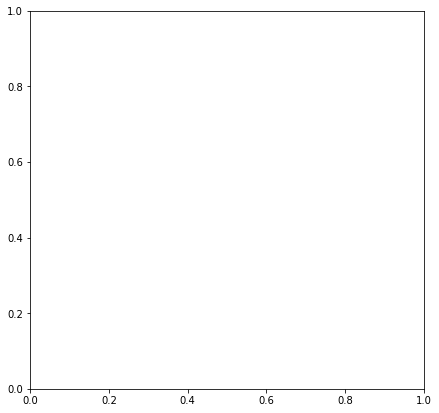

In [16]:
show_graphs(metrics)